In [5]:
import pandas as pd
import numpy as np 
df = pd.read_csv('./train.csv')
df

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
0        126283          1           1         0.667     2354     344559   
1        126283          1           1         3.667     2354     250036   
2        126283          1           1         4.968     2354     500145   
3        126283          1           1         8.200     2354     500145   
4        126283          1           1        11.633     2354     142106   
...         ...        ...         ...           ...      ...        ...   
356716   126480          2          85      2887.667     4220     143588   
356717   126480          2          85      2889.934     4220     500530   
356718   126480          2          85      2896.200     4220     500530   
356719   126480          2          87      3017.600     4639     250896   
356720   126480          2          87      3020.800     4639     250902   

        action_id  type_name   result_name    start_x    start_y      end_x  \
0               0       Pass    Successful  52.418205  33.485444  31.322445   
1               2       Pass    Successful  32.013240  38.100808  37.371285   
2               4      Carry           NaN  37.371285  30.632980  38.391570   
3               5       Pass    Successful  38.391570  24.613144  34.573350   
4               7       Pass    Successful  34.578705   6.058256  21.274470   
...           ...        ...           ...        ...        ...        ...   
356716       2905       Pass    Successful  37.357110  20.782296  62.394465   
356717       2907      Carry           NaN  62.394465   4.904160  76.747020   
356718       2908       Pass    Successful  76.747020  17.890664  86.547720   
356719       2913  Goal Kick    Successful   5.342620  24.988164  63.547890   
356720       2915       Pass  Unsuccessful  63.547890   1.930724  72.663360   

            end_y  is_home game_episode  
0       38.274752     True     126283_1  
1       30.632980     True     126283_1  
2       24.613144     True     126283_1  
3        5.545468     True     126283_1  
4       18.437112     True     126283_1  
...           ...      ...          ...  
356716   4.904160    False    126480_85  
356717  17.890664    False    126480_85  
356718  25.628656    False    126480_85  
356719   1.930724     True    126480_87  
356720   8.241736     True    126480_87  

[356721 rows x 15 columns]

## Zone Mapping

In [6]:
import numpy as np

PITCH_X, PITCH_Y = 105.0, 68.0

def xy_to_zone_id(x, y, x_bins=12, y_bins=8):
    x = float(np.clip(x, 0.0, PITCH_X - 1e-9))
    y = float(np.clip(y, 0.0, PITCH_Y - 1e-9))
    zx = int(x / (PITCH_X / x_bins))
    zy = int(y / (PITCH_Y / y_bins))
    zx = min(max(zx, 0), x_bins - 1)
    zy = min(max(zy, 0), y_bins - 1)
    return zy * x_bins + zx

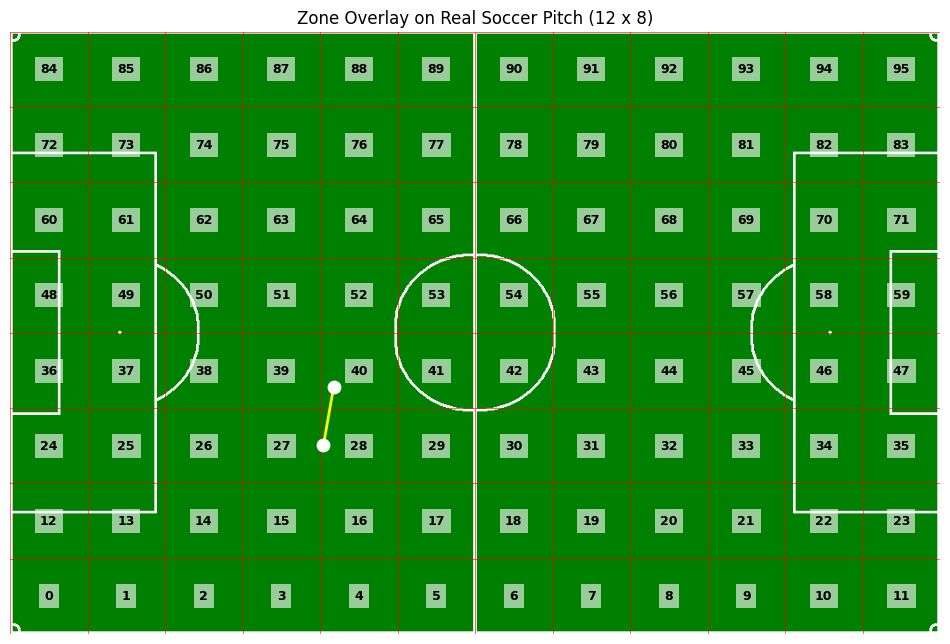

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

PITCH_X = 105.0
PITCH_Y = 68.0
x_bins = 12
y_bins = 8

# 1) 이미지 로드
img = mpimg.imread("football_field.png")

fig, ax = plt.subplots(figsize=(12, 8))

# 2) 이미지 표시
ax.imshow(
    img,
    extent=[0, PITCH_X, 0, PITCH_Y],  # 🔥 좌표계를 실제 미터로 맞춤
    origin="lower"                    # (0,0)을 왼쪽 아래로
)

# 3) grid lines
for i in range(x_bins + 1):
    x = i * PITCH_X / x_bins
    ax.plot([x, x], [0, PITCH_Y], color="red", linewidth=0.7, alpha=0.6)

for j in range(y_bins + 1):
    y = j * PITCH_Y / y_bins
    ax.plot([0, PITCH_X], [y, y], color="red", linewidth=0.7, alpha=0.6)

# 4) zone 번호
for zy in range(y_bins):
    for zx in range(x_bins):
        zone_id = zy * x_bins + zx
        cx = (zx + 0.5) * PITCH_X / x_bins
        cy = (zy + 0.5) * PITCH_Y / y_bins
        ax.text(
            cx, cy, str(zone_id),
            ha="center", va="center",
            fontsize=9, fontweight="bold",
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
        )

# 5) 좌표 표시
coord_df = df[['start_x', 'start_y','end_x','end_y']].sample(1, random_state=42)
coord_sample_start = (coord_df['start_x'].values[0], coord_df['start_y'].values[0])
coord_sample_end = (coord_df['end_x'].values[0], coord_df['end_y'].values[0])
x_start, y_start = coord_sample_start
x_end, y_end = coord_sample_end

ax.scatter(
    x_start, y_start,
    s=80,
    color="white",
    zorder=5
)
ax.scatter(
    x_end, y_end,
    s=80,
    color="white",
    zorder=5
)
ax.plot(
    [x_start, x_end], [y_start, y_end],
    color="yellow", linewidth=2, zorder=4
)

ax.set_xlim(0, PITCH_X)
ax.set_ylim(0, PITCH_Y)
ax.set_aspect("equal")
ax.axis("off")
ax.set_title("Zone Overlay on Real Soccer Pitch (12 x 8)")
plt.show()

## 그래프 생성 (Node Embedding)
- node
    - player
    - team
    - zone
    - type_name
- edge
    - player-team: 같은 팀 소속 player들
    - player-zone: 이 선수가 주로 있는 위치(포지션)
    - action-zone: 특정 지역에서 주로 행해지는 action
    - zone-zone: 공의 위치 변화

In [8]:
import pandas as pd
import networkx as nx

def build_train_graph(train_raw: pd.DataFrame, x_bins=12, y_bins=8):
    """
    노드:
      P:{player_id}, T:{team_id}, Z:{zone_id}, A:{type_name}
    엣지:
      P -- Z(start)
      Z(start) -- Z(end)   (end 있는 행만)
      T -- P
      A -- Z(start)  (action이 zone 선택에 영향)
    """
    G = nx.Graph()

    df = train_raw.copy()
    df = df.sort_values(["game_episode", "time_seconds"]).reset_index(drop=True)

    # end_x/end_y 없는 행은 Z->Z 엣지 못 만듦
    for _, r in df.iterrows():
        pid = f"P:{int(r['player_id'])}"
        tid = f"T:{int(r['team_id'])}"
        act = f"A:{str(r['type_name'])}" if pd.notna(r["type_name"]) else "A:missing"

        sz = xy_to_zone_id(r["start_x"], r["start_y"], x_bins, y_bins)
        szn = f"Z:{sz}"

        # player-team, player-startzone, action-startzone
        G.add_edge(tid, pid)
        G.add_edge(pid, szn)
        G.add_edge(act, szn)

        # zone transition (end 존재할 때만)
        if pd.notna(r.get("end_x")) and pd.notna(r.get("end_y")):
            ez = xy_to_zone_id(r["end_x"], r["end_y"], x_bins, y_bins)
            ezn = f"Z:{ez}"
            G.add_edge(szn, ezn)

    return G

### Visualization

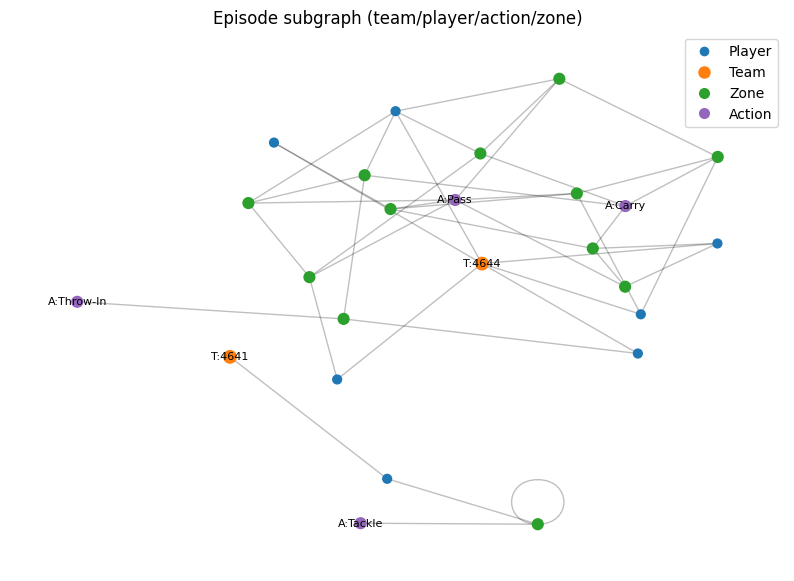

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from matplotlib.lines import Line2D


def node_style(n):
    if n.startswith("P:"): return "tab:blue", 40
    if n.startswith("T:"): return "tab:orange", 80
    if n.startswith("Z:"): return "tab:green", 60
    if n.startswith("A:"): return "tab:purple", 60
    return "gray", 30

def build_episode_graph(df_ep, x_bins=12, y_bins=8):
    G = nx.Graph()
    df_ep = df_ep.sort_values("time_seconds").reset_index(drop=True)

    for _, r in df_ep.iterrows():
        pid = f"P:{int(r['player_id'])}"
        tid = f"T:{int(r['team_id'])}"
        act = f"A:{str(r['type_name'])}" if pd.notna(r["type_name"]) else "A:missing"

        sz = xy_to_zone_id(r["start_x"], r["start_y"], x_bins, y_bins)
        szn = f"Z:{sz}"

        G.add_edge(tid, pid)
        G.add_edge(pid, szn)
        G.add_edge(act, szn)

        if pd.notna(r.get("end_x")) and pd.notna(r.get("end_y")):
            ez = xy_to_zone_id(r["end_x"], r["end_y"], x_bins, y_bins)
            ezn = f"Z:{ez}"
            G.add_edge(szn, ezn)

    return G

# 예시: 특정 episode CSV 한 개로
df_ep = pd.read_csv("/Users/jangbinlee/Desktop/Open Track 1/test/153380/153380_2.csv")
G_ep = build_episode_graph(df_ep, x_bins=12, y_bins=8)

pos = nx.spring_layout(G_ep, seed=42, k=0.8)

colors, sizes = [], []
for n in G_ep.nodes():
    c, s = node_style(n)
    colors.append(c); sizes.append(s)

plt.figure(figsize=(10, 7))
nx.draw_networkx_edges(G_ep, pos, alpha=0.25, width=1.0)
nx.draw_networkx_nodes(G_ep, pos, node_color=colors, node_size=sizes)

# 너무 복잡하면 라벨은 일부만
label_nodes = [n for n in G_ep.nodes() if n.startswith(("T:", "A:"))]  # 팀/액션만 라벨
nx.draw_networkx_labels(G_ep, pos, labels={n:n for n in label_nodes}, font_size=8)

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label='Player',
           markerfacecolor='tab:blue', markersize=8),

    Line2D([0], [0], marker='o', color='w',
           label='Team',
           markerfacecolor='tab:orange', markersize=10),

    Line2D([0], [0], marker='o', color='w',
           label='Zone',
           markerfacecolor='tab:green', markersize=9),

    Line2D([0], [0], marker='o', color='w',
           label='Action',
           markerfacecolor='tab:purple', markersize=9),
]

plt.legend(handles=legend_elements, loc="upper right")
plt.title("Episode subgraph (team/player/action/zone)")
plt.axis("off")
plt.show()

## Random Walk

In [10]:
import random
from gensim.models import Word2Vec

def random_walk(G, start, walk_len=40):
    walk = [start]
    for _ in range(walk_len - 1):
        cur = walk[-1]
        neigh = list(G.neighbors(cur))
        if not neigh:
            break
        walk.append(random.choice(neigh))
    return walk

def deepwalk_embeddings(G, dim=32, num_walks=10, walk_len=40, window=5, workers=4, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    walks = []
    for _ in range(num_walks):
        random.shuffle(nodes)
        for n in nodes:
            walks.append(random_walk(G, n, walk_len=walk_len))

    w2v = Word2Vec(
        sentences=walks,
        vector_size=dim,
        window=window,
        min_count=1,
        sg=1,          # skip-gram
        workers=workers,
        seed=seed
    )

    # dict: node -> np.array(dim,)
    emb = {n: w2v.wv[n].astype(np.float32) for n in G.nodes()}
    return emb

## Combining CatBoost

In [11]:
def make_result_bin(x):
    if x == "Successful":
        return 1
    if x == "Unsuccessful":
        return 0
    return 0  # missing -> 0

def build_table_for_train(train_raw, emb, x_bins=12, y_bins=8, emb_dim=32):
    rows = []
    # end_x/end_y가 정답이므로 train에는 마지막 row도 end가 있어야 함 (문제 셋 기준 대부분 있음)
    for ge, g in train_raw.groupby("game_episode"):
        g = g.sort_values("time_seconds").reset_index(drop=True)

        # 마지막 "유효한 end" 행을 찾는 게 안전 (end_x/end_y NaN이면 target 없음)
        valid_idx = g["end_x"].notna() & g["end_y"].notna()
        if valid_idx.sum() == 0:
            continue
        last = g.loc[valid_idx].iloc[-1]

        pid = int(last["player_id"])
        tid = int(last["team_id"])
        act = str(last["type_name"]) if pd.notna(last["type_name"]) else "missing"
        sz = xy_to_zone_id(last["start_x"], last["start_y"], x_bins, y_bins)

        # embeddings (없으면 0)
        def get_emb(key):
            return emb.get(key, np.zeros((emb_dim,), dtype=np.float32))

        eP = get_emb(f"P:{pid}")
        eT = get_emb(f"T:{tid}")
        eZ = get_emb(f"Z:{sz}")
        eA = get_emb(f"A:{act}")

        r = {
            "game_episode": ge,
            # numeric
            "time_seconds": float(last["time_seconds"]),
            "start_x": float(last["start_x"]),
            "start_y": float(last["start_y"]),
            "is_home": int(bool(last["is_home"])),
            "result_name_bin": int(make_result_bin(last.get("result_name", None))),
            "start_zone": int(sz),

            # categorical (CatBoost가 string도 처리 가능)
            "player_id": str(pid),
            "team_id": str(tid),
            "type_name": act,
            "action_id": str(int(last["action_id"])) if pd.notna(last["action_id"]) else "missing",
            "period_id": str(int(last["period_id"])) if pd.notna(last["period_id"]) else "missing",
        }

        # emb columns
        for i in range(emb_dim):
            r[f"embP_{i}"] = float(eP[i])
            r[f"embT_{i}"] = float(eT[i])
            r[f"embZ_{i}"] = float(eZ[i])
            r[f"embA_{i}"] = float(eA[i])

        # targets (meters)
        r["target_end_x_m"] = float(last["end_x"])
        r["target_end_y_m"] = float(last["end_y"])

        rows.append(r)

    return pd.DataFrame(rows)


def build_table_for_test(submission_df, emb, x_bins=12, y_bins=8, emb_dim=32):
    rows = []
    for _, row in submission_df.iterrows():
        g = pd.read_csv(row["path"]).sort_values("time_seconds").reset_index(drop=True)

        # test는 마지막 row에서 end_x/end_y가 비어있는 경우가 많으니 그냥 마지막 row 사용
        last = g.iloc[-1]

        pid = int(last["player_id"])
        tid = int(last["team_id"])
        act = str(last["type_name"]) if pd.notna(last["type_name"]) else "missing"
        sz = xy_to_zone_id(last["start_x"], last["start_y"], x_bins, y_bins)

        def get_emb(key):
            return emb.get(key, np.zeros((emb_dim,), dtype=np.float32))

        eP = get_emb(f"P:{pid}")
        eT = get_emb(f"T:{tid}")
        eZ = get_emb(f"Z:{sz}")
        eA = get_emb(f"A:{act}")

        r = {
            "game_episode": row["game_episode"],
            "time_seconds": float(last["time_seconds"]),
            "start_x": float(last["start_x"]),
            "start_y": float(last["start_y"]),
            "is_home": int(bool(last["is_home"])),
            "result_name_bin": int(make_result_bin(last.get("result_name", None))),
            "start_zone": int(sz),

            "player_id": str(pid),
            "team_id": str(tid),
            "type_name": act,
            "action_id": str(int(last["action_id"])) if pd.notna(last["action_id"]) else "missing",
            "period_id": str(int(last["period_id"])) if pd.notna(last["period_id"]) else "missing",
        }

        for i in range(emb_dim):
            r[f"embP_{i}"] = float(eP[i])
            r[f"embT_{i}"] = float(eT[i])
            r[f"embZ_{i}"] = float(eZ[i])
            r[f"embA_{i}"] = float(eA[i])

        rows.append(r)

    return pd.DataFrame(rows)

In [12]:
# 1) load
train_raw = pd.read_csv("./train.csv").sort_values(["game_episode","time_seconds"]).reset_index(drop=True)

test_meta = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv").merge(test_meta, on="game_episode", how="left")

# 2) graph + emb
G = build_train_graph(train_raw, x_bins=12, y_bins=8)
emb = deepwalk_embeddings(G, dim=32, num_walks=10, walk_len=40, window=5, workers=4)

# 3) tables
train_df = build_table_for_train(train_raw, emb, x_bins=12, y_bins=8, emb_dim=32)
test_df  = build_table_for_test(submission, emb, x_bins=12, y_bins=8, emb_dim=32)

train_df

game_episode  time_seconds     start_x    start_y  is_home  \
0         126283_1       124.367  101.054205  52.757324        1   
1        126283_10       695.473  102.213510  51.930444        0   
2        126283_11       894.237   67.934265  11.028172        0   
3        126283_12       940.933   80.991120  66.827109        1   
4        126283_13       997.233   14.527695  21.594692        0   
...            ...           ...         ...        ...      ...   
15430    126480_82      2723.500   58.451190   5.337796        0   
15431    126480_84      2847.767   67.990440  14.316380        1   
15432    126480_85      2896.200   76.747020  17.890664        0   
15433    126480_87      3020.800   63.547890   1.930724        1   
15434     126480_9       833.700   29.311275  45.776920        0   

       result_name_bin  start_zone player_id team_id type_name  ...   embP_30  \
0                    1          83    500146    2354      Pass  ...  0.018760   
1                    1          83    412018    4639      Pass  ...  0.055119   
2                    1          19     97086    4639      Pass  ... -0.038404   
3                    0          93     61979    2354      Pass  ... -0.037764   
4                    0          25    142258    4639      Pass  ...  0.242102   
...                ...         ...       ...     ...       ...  ...       ...   
15430                1           6    500549    4220      Pass  ... -0.085299   
15431                0          19    407605    4639      Pass  ... -0.019498   
15432                1          32    500530    4220      Pass  ... -0.002161   
15433                0           7    250902    4639      Pass  ... -0.059939   
15434                0          63    354820    4220      Pass  ...  0.015798   

        embT_30   embZ_30   embA_30   embP_31   embT_31   embZ_31   embA_31  \
0      0.167269  0.035996  0.025549  0.296970  0.172743  0.594812  0.164164   
1     -0.074176  0.035996  0.025549  0.185185  0.523103  0.594812  0.164164   
2     -0.074176  0.002082  0.025549  0.121268  0.523103  0.193452  0.164164   
3      0.167269  0.163004  0.025549  0.043676  0.172743  0.317897  0.164164   
4     -0.074176 -0.427187  0.025549  0.258575  0.523103  0.105479  0.164164   
...         ...       ...       ...       ...       ...       ...       ...   
15430 -0.290279  0.021017  0.025549  0.130390 -0.134671 -0.050749  0.164164   
15431 -0.074176  0.002082  0.025549  0.141801  0.523103  0.193452  0.164164   
15432 -0.290279 -0.091121  0.025549  0.114547 -0.134671  0.349658  0.164164   
15433 -0.074176 -0.224573  0.025549  0.227536  0.523103  0.215870  0.164164   
15434 -0.290279  0.065329  0.025549  0.002699 -0.134671  0.163400  0.164164   

       target_end_x_m  target_end_y_m  
0           97.134030       41.793072  
1           95.680830       59.465320  
2           90.346515       14.220024  
3           81.475905       65.480029  
4           71.613255        0.000000  
...               ...             ...  
15430       76.632360       19.146692  
15431       99.930117       30.908516  
15432       86.547720       25.628656  
15433       72.663360        8.241736  
15434       83.430585       57.047240  

[15435 rows x 142 columns]

In [13]:
from sklearn.model_selection import GroupKFold
from catboost import CatBoostRegressor, Pool

def mean_euclid(x_pred, y_pred, x_true, y_true):
    return float(np.mean(np.sqrt((x_pred-x_true)**2 + (y_pred-y_true)**2)))

def train_catboost_cv_xy(train_df, test_df, feat_cols, cat_cols, group_col="game_id", n_splits=5, seed=42):
    X = train_df[feat_cols]
    yx = train_df["target_end_x_m"].values
    yy = train_df["target_end_y_m"].values

    groups = train_df[group_col].values if group_col in train_df.columns else train_df["game_episode"].values

    cat_idx = [feat_cols.index(c) for c in cat_cols if c in feat_cols]

    oof_x = np.zeros(len(train_df), dtype=np.float32)
    oof_y = np.zeros(len(train_df), dtype=np.float32)
    test_pred_x_folds = []
    test_pred_y_folds = []

    gkf = GroupKFold(n_splits=n_splits)

    for fold, (tr, va) in enumerate(gkf.split(X, groups=groups), 1):
        tr_pool_x = Pool(X.iloc[tr], yx[tr], cat_features=cat_idx)
        va_pool_x = Pool(X.iloc[va], yx[va], cat_features=cat_idx)

        tr_pool_y = Pool(X.iloc[tr], yy[tr], cat_features=cat_idx)
        va_pool_y = Pool(X.iloc[va], yy[va], cat_features=cat_idx)

        model_x = CatBoostRegressor(
            loss_function="RMSE",
            depth=8,
            learning_rate=0.05,
            iterations=5000,
            random_seed=seed,
            verbose=200,
            early_stopping_rounds=200
        )
        model_y = CatBoostRegressor(
            loss_function="RMSE",
            depth=8,
            learning_rate=0.05,
            iterations=5000,
            random_seed=seed,
            verbose=200,
            early_stopping_rounds=200
        )

        model_x.fit(tr_pool_x, eval_set=va_pool_x, use_best_model=True)
        model_y.fit(tr_pool_y, eval_set=va_pool_y, use_best_model=True)

        oof_x[va] = model_x.predict(va_pool_x).astype(np.float32)
        oof_y[va] = model_y.predict(va_pool_y).astype(np.float32)

        # fold metric
        dist = mean_euclid(oof_x[va], oof_y[va], yx[va], yy[va])
        print(f"[Fold {fold}] val_dist={dist:.4f}")

        # test
        X_test = test_df[feat_cols]
        te_pool = Pool(X_test, cat_features=cat_idx)
        test_pred_x_folds.append(model_x.predict(te_pool).astype(np.float32))
        test_pred_y_folds.append(model_y.predict(te_pool).astype(np.float32))

    oof_dist = mean_euclid(oof_x, oof_y, yx, yy)
    print(f"[OOF] dist={oof_dist:.4f}")

    pred_x = np.mean(np.stack(test_pred_x_folds, axis=0), axis=0)
    pred_y = np.mean(np.stack(test_pred_y_folds, axis=0), axis=0)

    return oof_x, oof_y, pred_x, pred_y

In [10]:
import pandas as pd
import numpy as np

# 1) load
train_raw = pd.read_csv("./train.csv").sort_values(["game_episode","time_seconds"]).reset_index(drop=True)

test_meta = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv").merge(test_meta, on="game_episode", how="left")

# 2) graph + emb
G = build_train_graph(train_raw, x_bins=12, y_bins=8)
emb = deepwalk_embeddings(G, dim=32, num_walks=10, walk_len=40, window=5, workers=4)

# 3) tables
train_df = build_table_for_train(train_raw, emb, x_bins=12, y_bins=8, emb_dim=32)
test_df  = build_table_for_test(submission, emb, x_bins=12, y_bins=8, emb_dim=32)

# group column 준비 (없으면 game_id로)
# train_df에 game_id 넣고 싶으면 build_table_for_train에서 같이 넣어줘도 됨.
# 여기서는 game_episode에서 game_id를 다시 merge
ge2gid = train_raw.groupby("game_episode")["game_id"].first().reset_index()
train_df = train_df.merge(ge2gid, on="game_episode", how="left")

# feat cols
DROP = ["target_end_x_m", "target_end_y_m", "game_episode", "game_id"]  # ✅ game_id 추가로 drop
feat_cols = [c for c in train_df.columns if c not in DROP]

CAT_COLS = ["player_id", "team_id", "type_name", "action_id", "period_id"]
cat_cols = [c for c in CAT_COLS if c in feat_cols]

# 5) train catboost cv
oof_x, oof_y, pred_x, pred_y = train_catboost_cv_xy(
    train_df, test_df,
    feat_cols=feat_cols,
    cat_cols=cat_cols,
    group_col="game_id",
    n_splits=5,
    seed=42
)

# 6) submission
out = submission.copy()
out["end_x"] = np.clip(pred_x, 0.0, 105.0)
out["end_y"] = np.clip(pred_y, 0.0, 68.0)
out[["game_episode","end_x","end_y"]].to_csv("./graph_emb_catboost_submit.csv", index=False)
print("Saved: graph_emb_catboost_submit.csv")

0:	learn: 23.1358120	test: 23.2571823	best: 23.2571823 (0)	total: 65.7ms	remaining: 5m 28s
200:	learn: 11.5672939	test: 12.8598810	best: 12.8592021 (199)	total: 1.43s	remaining: 34.1s
400:	learn: 10.4920178	test: 12.8528281	best: 12.8335748 (273)	total: 2.73s	remaining: 31.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 12.83357485
bestIteration = 273

Shrink model to first 274 iterations.
0:	learn: 23.6592755	test: 23.6328573	best: 23.6328573 (0)	total: 7.04ms	remaining: 35.2s
200:	learn: 13.1637242	test: 14.8255442	best: 14.8217449 (129)	total: 1.4s	remaining: 33.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 14.82174486
bestIteration = 129

Shrink model to first 130 iterations.
[Fold 1] val_dist=16.3751
0:	learn: 23.1379922	test: 23.2768051	best: 23.2768051 (0)	total: 9.42ms	remaining: 47.1s
200:	learn: 11.5629442	test: 13.0279054	best: 13.0262052 (198)	total: 1.78s	remaining: 42.6s
400:	learn: 10.6553531	test: 12.9995236	best: 12.9936769

KeyboardInterrupt: 

## Meta Stacking

In [29]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold

def mean_euclid_xy(x_pred, y_pred, x_true, y_true):
    return float(np.mean(np.sqrt((x_pred-x_true)**2 + (y_pred-y_true)**2)))

def stack_with_ridge_oof(
    yx_true, yy_true,
    base_oof_list,        # list of (oof_x, oof_y) each shape (N,)
    base_test_list,       # list of (test_x, test_y) each shape (M,)
    groups,               # shape (N,)
    n_splits=5,
    alpha=1.0,
    seed=42,
    verbose=True
):
    """
    base_oof_list:  [(oof_x1, oof_y1), (oof_x2, oof_y2), ...]
    base_test_list: [(te_x1, te_y1),   (te_x2, te_y2),   ...]
    returns:
      oof_x_meta, oof_y_meta, test_x_meta, test_y_meta
    """
    N = len(yx_true)
    M = len(base_test_list[0][0])

    # meta features: [oof_x1,oof_y1,oof_x2,oof_y2,...]
    X_meta = np.stack(
        [arr for (ox, oy) in base_oof_list for arr in (ox, oy)],
        axis=1
    ).astype(np.float32)

    X_meta_test = np.stack(
        [arr for (tx, ty) in base_test_list for arr in (tx, ty)],
        axis=1
    ).astype(np.float32)

    gkf = GroupKFold(n_splits=n_splits)

    oof_x = np.zeros(N, dtype=np.float32)
    oof_y = np.zeros(N, dtype=np.float32)
    test_x_folds = []
    test_y_folds = []

    for fold, (tr, va) in enumerate(gkf.split(X_meta, groups=groups), 1):
        # x meta
        mx = Ridge(alpha=alpha, random_state=seed)
        mx.fit(X_meta[tr], yx_true[tr])
        oof_x[va] = mx.predict(X_meta[va]).astype(np.float32)
        test_x_folds.append(mx.predict(X_meta_test).astype(np.float32))

        # y meta
        my = Ridge(alpha=alpha, random_state=seed)
        my.fit(X_meta[tr], yy_true[tr])
        oof_y[va] = my.predict(X_meta[va]).astype(np.float32)
        test_y_folds.append(my.predict(X_meta_test).astype(np.float32))

        if verbose:
            dist = mean_euclid_xy(oof_x[va], oof_y[va], yx_true[va], yy_true[va])
            print(f"[Meta Fold {fold}] val_dist={dist:.4f}")

    oof_dist = mean_euclid_xy(oof_x, oof_y, yx_true, yy_true)
    if verbose:
        print(f"[Meta OOF] dist={oof_dist:.4f}")

    test_x = np.mean(np.stack(test_x_folds, axis=0), axis=0)
    test_y = np.mean(np.stack(test_y_folds, axis=0), axis=0)

    return oof_x, oof_y, test_x, test_y

In [30]:
train_raw = pd.read_csv("./train.csv")
print(train_raw.columns)

print(train_raw[["start_x","start_y","end_x","end_y"]].describe().loc[["min","max"]])
print("end missing rows:", train_raw["end_x"].isna().mean(), train_raw["end_y"].isna().mean())

Index(['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id',
       'player_id', 'action_id', 'type_name', 'result_name', 'start_x',
       'start_y', 'end_x', 'end_y', 'is_home', 'game_episode'],
      dtype='object')
     start_x  start_y  end_x  end_y
min      0.0      0.0    0.0    0.0
max    105.0     68.0  105.0   68.0
end missing rows: 0.0 0.0


## Combining with other models

In [14]:
import numpy as np
import pandas as pd

PITCH_X, PITCH_Y = 105.0, 68.0

CAT_COLS = ["player_id", "team_id", "type_name", "action_id", "period_id"]

def make_result_bin(x):
    if x == "Successful":
        return 1
    if x == "Unsuccessful":
        return 0
    return 0

def get_emb(emb, key, dim):
    v = emb.get(key, None)
    if v is None:
        return np.zeros((dim,), dtype=np.float32)
    return v.astype(np.float32)

def build_row_table_train(train_raw: pd.DataFrame, emb, x_bins=12, y_bins=8, emb_dim=32):
    df = train_raw.copy()
    df = df.sort_values(["game_episode","time_seconds"]).reset_index(drop=True)

    # 정답 존재 row만
    m = df["end_x"].notna() & df["end_y"].notna()
    df = df.loc[m].reset_index(drop=True)

    rows = []
    for _, r in df.iterrows():
        pid = int(r["player_id"])
        tid = int(r["team_id"])
        act = str(r["type_name"]) if pd.notna(r["type_name"]) else "missing"
        sz = xy_to_zone_id(r["start_x"], r["start_y"], x_bins=x_bins, y_bins=y_bins)

        eP = get_emb(emb, f"P:{pid}", emb_dim)
        eT = get_emb(emb, f"T:{tid}", emb_dim)
        eZ = get_emb(emb, f"Z:{sz}", emb_dim)
        eA = get_emb(emb, f"A:{act}", emb_dim)

        out = {
            # group keys
            "game_id": int(r["game_id"]),
            "game_episode": r["game_episode"],

            # numeric (원본 스케일 그대로 둠; 필요하면 나중에 스케일링 추가)
            "time_seconds": float(r["time_seconds"]),
            "start_x": float(r["start_x"]),
            "start_y": float(r["start_y"]),
            "is_home": int(bool(r["is_home"])),
            "result_name_bin": int(make_result_bin(r.get("result_name", None))),
            "start_zone": int(sz),

            # categorical raw
            "player_id": str(pid),
            "team_id": str(tid),
            "type_name": act,
            "action_id": str(int(r["action_id"])) if pd.notna(r["action_id"]) else "missing",
            "period_id": str(int(r["period_id"])) if pd.notna(r["period_id"]) else "missing",

            # targets (meters)
            "target_end_x_m": float(r["end_x"]),
            "target_end_y_m": float(r["end_y"]),
        }

        # embeddings
        for i in range(emb_dim):
            out[f"embP_{i}"] = float(eP[i])
            out[f"embT_{i}"] = float(eT[i])
            out[f"embZ_{i}"] = float(eZ[i])
            out[f"embA_{i}"] = float(eA[i])

        rows.append(out)

    return pd.DataFrame(rows)

def build_row_table_test(submission_df: pd.DataFrame, emb, x_bins=12, y_bins=8, emb_dim=32):
    rows = []
    for _, row in submission_df.iterrows():
        g = pd.read_csv(row["path"]).sort_values("time_seconds").reset_index(drop=True)
        last = g.iloc[-1]

        pid = int(last["player_id"])
        tid = int(last["team_id"])
        act = str(last["type_name"]) if pd.notna(last["type_name"]) else "missing"
        sz = xy_to_zone_id(last["start_x"], last["start_y"], x_bins=x_bins, y_bins=y_bins)

        eP = get_emb(emb, f"P:{pid}", emb_dim)
        eT = get_emb(emb, f"T:{tid}", emb_dim)
        eZ = get_emb(emb, f"Z:{sz}", emb_dim)
        eA = get_emb(emb, f"A:{act}", emb_dim)

        out = {
            "game_episode": row["game_episode"],
            "time_seconds": float(last["time_seconds"]),
            "start_x": float(last["start_x"]),
            "start_y": float(last["start_y"]),
            "is_home": int(bool(last["is_home"])),
            "result_name_bin": int(make_result_bin(last.get("result_name", None))),
            "start_zone": int(sz),

            "player_id": str(pid),
            "team_id": str(tid),
            "type_name": act,
            "action_id": str(int(last["action_id"])) if pd.notna(last["action_id"]) else "missing",
            "period_id": str(int(last["period_id"])) if pd.notna(last["period_id"]) else "missing",
        }

        for i in range(emb_dim):
            out[f"embP_{i}"] = float(eP[i])
            out[f"embT_{i}"] = float(eT[i])
            out[f"embZ_{i}"] = float(eZ[i])
            out[f"embA_{i}"] = float(eA[i])

        rows.append(out)

    return pd.DataFrame(rows)

In [15]:
def factorize_cats(train_df, test_df, cat_cols):
    train_df = train_df.copy()
    test_df = test_df.copy()
    for c in cat_cols:
        allv = pd.concat([train_df[c].astype(str), test_df[c].astype(str)], axis=0)
        codes, uniques = pd.factorize(allv, sort=True)
        train_df[c] = codes[:len(train_df)].astype(np.int32)
        test_df[c]  = codes[len(train_df):].astype(np.int32)
    return train_df, test_df

In [16]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def mean_euclid_xy(px, py, tx, ty):
    return float(np.mean(np.sqrt((px-tx)**2 + (py-ty)**2)))

def oof_predict_reg_xy(model_x, model_y, X, yx, yy, groups, X_test=None, n_splits=5, name="model"):
    gkf = GroupKFold(n_splits=n_splits)
    oof_x = np.zeros(len(X), dtype=np.float32)
    oof_y = np.zeros(len(X), dtype=np.float32)
    test_pred_x_folds, test_pred_y_folds = [], []

    for fold, (tr, va) in enumerate(gkf.split(X, yx, groups=groups), 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        yxtr, yxva = yx[tr], yx[va]
        yytr, yyva = yy[tr], yy[va]

        mx = model_x()
        my = model_y()

        mx.fit(Xtr, yxtr)
        my.fit(Xtr, yytr)

        px = mx.predict(Xva).astype(np.float32)
        py = my.predict(Xva).astype(np.float32)

        oof_x[va] = px
        oof_y[va] = py

        dist = mean_euclid_xy(px, py, yxva, yyva)
        print(f"[{name} Fold {fold}] val_dist={dist:.4f}")

        if X_test is not None:
            test_pred_x_folds.append(mx.predict(X_test).astype(np.float32))
            test_pred_y_folds.append(my.predict(X_test).astype(np.float32))

    oof_dist = mean_euclid_xy(oof_x, oof_y, yx, yy)
    print(f"[{name} OOF] dist={oof_dist:.4f}")

    if X_test is None:
        return oof_x, oof_y, None, None

    test_x = np.mean(np.stack(test_pred_x_folds, axis=0), axis=0)
    test_y = np.mean(np.stack(test_pred_y_folds, axis=0), axis=0)
    return oof_x, oof_y, test_x, test_y

def ridge_meta_stack(oof_list, test_list, y_true_x, y_true_y, groups, n_splits=5, alpha=1.0):
    """
    oof_list: [(oof_x1,oof_y1), (oof_x2,oof_y2), ...]
    test_list: [(te_x1,te_y1), (te_x2,te_y2), ...]
    """
    X_meta = np.stack([v for pair in oof_list for v in pair], axis=1)   # (N, 2*K)
    X_te   = np.stack([v for pair in test_list for v in pair], axis=1)  # (M, 2*K)

    gkf = GroupKFold(n_splits=n_splits)
    oof_x = np.zeros(len(y_true_x), dtype=np.float32)
    oof_y = np.zeros(len(y_true_y), dtype=np.float32)
    te_x_folds, te_y_folds = [], []

    for fold, (tr, va) in enumerate(gkf.split(X_meta, y_true_x, groups=groups), 1):
        rx = Ridge(alpha=alpha, random_state=42)
        ry = Ridge(alpha=alpha, random_state=42)

        rx.fit(X_meta[tr], y_true_x[tr])
        ry.fit(X_meta[tr], y_true_y[tr])

        px = rx.predict(X_meta[va]).astype(np.float32)
        py = ry.predict(X_meta[va]).astype(np.float32)
        oof_x[va] = px
        oof_y[va] = py

        dist = mean_euclid_xy(px, py, y_true_x[va], y_true_y[va])
        print(f"[META Fold {fold}] val_dist={dist:.4f}")

        te_x_folds.append(rx.predict(X_te).astype(np.float32))
        te_y_folds.append(ry.predict(X_te).astype(np.float32))

    print("[META OOF] dist=", mean_euclid_xy(oof_x, oof_y, y_true_x, y_true_y))
    te_x = np.mean(np.stack(te_x_folds, axis=0), axis=0)
    te_y = np.mean(np.stack(te_y_folds, axis=0), axis=0)
    return oof_x, oof_y, te_x, te_y

In [ ]:
import lightgbm as lgb
import xgboost as xgb

# 1) load
train_raw = pd.read_csv("./train.csv").sort_values(["game_episode","time_seconds"]).reset_index(drop=True)

test_meta = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv").merge(test_meta, on="game_episode", how="left")

# 2) graph + emb (너가 이미 갖고 있는 함수 사용)
G = build_train_graph(train_raw, x_bins=12, y_bins=8)
emb = deepwalk_embeddings(G, dim=32, num_walks=10, walk_len=40, window=5, workers=4, seed=42)

# 3) row tables
train_df = build_row_table_train(train_raw, emb, x_bins=12, y_bins=8, emb_dim=32)
test_df  = build_row_table_test(submission, emb, x_bins=12, y_bins=8, emb_dim=32)

print("train rows:", len(train_df), "test episodes:", len(test_df))

# 4) features
DROP = {"target_end_x_m", "target_end_y_m", "game_episode"}  
feat_cols = [c for c in train_df.columns if c not in DROP]

# ✅ game_id는 feature에서 제거 (group용으로만 사용)
if "game_id" in feat_cols:
    feat_cols.remove("game_id")

# ✅ test_df에 없는 컬럼도 제거 (이게 핵심)
feat_cols = [c for c in feat_cols if c in test_df.columns]
print("feat_cols size:", len(feat_cols))

# 그룹(누수 방지)
groups = train_df["game_id"].values  # row-level이면 game_id 기준 강추

# 5) factorize cats for LGBM/XGB
cat_cols = [c for c in CAT_COLS if c in feat_cols]

train_enc, test_enc = factorize_cats(
    train_df[feat_cols + ["target_end_x_m", "target_end_y_m"]],  # ✅ game_id 넣지마
    test_df[feat_cols],
    cat_cols
)

X = train_enc[feat_cols]
yx = train_enc["target_end_x_m"].values.astype(np.float32)
yy = train_enc["target_end_y_m"].values.astype(np.float32)
X_test = test_enc[feat_cols]

# 6) base model: LightGBM
def lgb_x():
    return lgb.LGBMRegressor(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

def lgb_y():
    return lgb.LGBMRegressor(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

oof_x_lgb, oof_y_lgb, te_x_lgb, te_y_lgb = oof_predict_reg_xy(
    lgb_x, lgb_y, X, yx, yy, groups=groups, X_test=X_test, n_splits=5, name="LGBM"
)

# 7) base model: XGBoost
def xgb_x():
    return xgb.XGBRegressor(
        n_estimators=4000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

def xgb_y():
    return xgb.XGBRegressor(
        n_estimators=4000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

oof_x_xgb, oof_y_xgb, te_x_xgb, te_y_xgb = oof_predict_reg_xy(
    xgb_x, xgb_y, X, yx, yy, groups=groups, X_test=X_test, n_splits=5, name="XGB"
)

# 8) META stacking (Ridge)
oof_list  = [(oof_x_lgb, oof_y_lgb), (oof_x_xgb, oof_y_xgb)]
test_list = [(te_x_lgb,  te_y_lgb),  (te_x_xgb,  te_y_xgb)]

oof_x_meta, oof_y_meta, pred_x, pred_y = ridge_meta_stack(
    oof_list, test_list,
    y_true_x=yx, y_true_y=yy,
    groups=groups,
    n_splits=5,
    alpha=1.0
)

print("FINAL META OOF dist:", mean_euclid_xy(oof_x_meta, oof_y_meta, yx, yy))

# 9) submission
out = submission.copy()
out["end_x"] = np.clip(pred_x, 0.0, 105.0)
out["end_y"] = np.clip(pred_y, 0.0, 68.0)
out[["game_episode","end_x","end_y"]].to_csv("./graph_row_lgb_xgb_ridge_submit.csv", index=False)
print("Saved: graph_row_lgb_xgb_ridge_submit.csv")

train rows: 356721 test episodes: 2414
feat_cols size: 139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13649
[LightGBM] [Info] Number of data points in the train set: 284829, number of used features: 139
[LightGBM] [Info] Start training from score 51.110425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13649
[LightGBM] [Info] Number of data points in the train set: 284829, number of used features: 139
[LightGBM] [Info] Start training from score 34.083299
[LGBM Fold 1] val_dist=11.0866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00

/Users/jangbinlee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jangbinlee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jangbinlee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jangbinlee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jangbinlee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jangbinlee/Library/Python/3.9/lib/python/site-packages/sklearn/linear_m

## Compare with other models

In [17]:
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge, ElasticNet

# =========================
# 0) 모델 팩토리들 (x,y 따로)
# =========================

def make_lgb():
    return lgb.LGBMRegressor(
        n_estimators=6000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

def make_xgb():
    return xgb.XGBRegressor(
        n_estimators=6000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

def make_et():
    return ExtraTreesRegressor(
        n_estimators=2500,
        max_depth=None,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )

def make_ridge():
    return Ridge(alpha=3.0, random_state=42)

def make_elastic():
    return ElasticNet(alpha=1e-3, l1_ratio=0.1, random_state=42)

# (필요하면 x,y 각각 다른 하이퍼파라미터를 주고 싶을 때는 make_lgb_x/make_lgb_y로 쪼개면 됨)
def lgb_x(): return make_lgb()
def lgb_y(): return make_lgb()

def xgb_x(): return make_xgb()
def xgb_y(): return make_xgb()

def et_x(): return make_et()
def et_y(): return make_et()

def ridge_x(): return make_ridge()
def ridge_y(): return make_ridge()

def enet_x(): return make_elastic()
def enet_y(): return make_elastic()

# =========================
# 1) OOF 비교 실행
# =========================

candidates = [
    ("LGBM",  lgb_x,   lgb_y),
    ("XGB",   xgb_x,   xgb_y),
    ("ET",    et_x,    et_y),
    ("Ridge", ridge_x, ridge_y),
    ("ENet",  enet_x,  enet_y),
]

results = []

for name, fx, fy in candidates:
    oof_x, oof_y, te_x, te_y = oof_predict_reg_xy(
        fx, fy,
        X, yx, yy,
        groups=groups,
        X_test=X_test,
        n_splits=5,
        name=name
    )
    score = mean_euclid_xy(oof_x, oof_y, yx, yy)
    results.append((name, score))
    
    print(f"[{name}] OOF mean euclid = {score:.6f}")

# 정렬 출력
results_sorted = sorted(results, key=lambda x: x[1])
print("\n=== RANKING ===")
for name, score in results_sorted:
    print(f"{name:6s} : {score:.6f}")

NameError: name 'X' is not defined

In [18]:
from sklearn.model_selection import GroupKFold
import numpy as np

def mean_euclid_xy(px, py, tx, ty):
    return float(np.mean(np.sqrt((px - tx)**2 + (py - ty)**2)))

# def group_cv_loop(
#     model_x_fn,
#     model_y_fn,
#     X, yx, yy,
#     X_test,
#     groups,
#     n_splits=5,
#     name="MODEL"
# ):
#     oof_x = np.zeros(len(X), dtype=np.float32)
#     oof_y = np.zeros(len(X), dtype=np.float32)
#     te_x_folds, te_y_folds = [], []

#     gkf = GroupKFold(n_splits=n_splits)

#     for fold, (tr, va) in enumerate(gkf.split(X, groups=groups), 1):
#         mx = model_x_fn()
#         my = model_y_fn()

#         mx.fit(X.iloc[tr], yx[tr])
#         my.fit(X.iloc[tr], yy[tr])

#         oof_x[va] = mx.predict(X.iloc[va])
#         oof_y[va] = my.predict(X.iloc[va])

#         dist = mean_euclid_xy(oof_x[va], oof_y[va], yx[va], yy[va])
#         print(f"[{name} Fold {fold}] val_dist={dist:.4f}")

#         te_x_folds.append(mx.predict(X_test))
#         te_y_folds.append(my.predict(X_test))

#     print(f"[{name} OOF] dist={mean_euclid_xy(oof_x, oof_y, yx, yy):.4f}")

#     return (
#         oof_x, oof_y,
#         np.mean(te_x_folds, axis=0),
#         np.mean(te_y_folds, axis=0)
#     )

import numpy as np
from sklearn.model_selection import GroupKFold

def group_cv_loop(
    model_x_fn, model_y_fn,
    X, yx, yy,
    X_test,
    groups,
    n_splits=5,
    name="Model",
    # CatBoost 전용
    cat_idx=None,
    use_catboost_pool=False,
    # 모델별 fit 파라미터
    fit_params_x=None,
    fit_params_y=None,
):
    fit_params_x = fit_params_x or {}
    fit_params_y = fit_params_y or {}

    oof_x = np.zeros(len(X), dtype=np.float32)
    oof_y = np.zeros(len(X), dtype=np.float32)
    pred_x = np.zeros(len(X_test), dtype=np.float32)
    pred_y = np.zeros(len(X_test), dtype=np.float32)

    gkf = GroupKFold(n_splits=n_splits)

    for fold, (tr, va) in enumerate(gkf.split(X, yx, groups=groups), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        yx_tr, yx_va = yx[tr], yx[va]
        yy_tr, yy_va = yy[tr], yy[va]

        mx = model_x_fn()
        my = model_y_fn()

        # --- CatBoost path ---
        if use_catboost_pool:
            from catboost import Pool
            tr_pool_x = Pool(X_tr, yx_tr, cat_features=cat_idx)
            va_pool_x = Pool(X_va, yx_va, cat_features=cat_idx)
            tr_pool_y = Pool(X_tr, yy_tr, cat_features=cat_idx)
            va_pool_y = Pool(X_va, yy_va, cat_features=cat_idx)
            te_pool   = Pool(X_test, cat_features=cat_idx)

            mx.fit(tr_pool_x, eval_set=va_pool_x, **fit_params_x)
            my.fit(tr_pool_y, eval_set=va_pool_y, **fit_params_y)

            oof_x[va] = mx.predict(X_va).astype(np.float32)
            oof_y[va] = my.predict(X_va).astype(np.float32)
            pred_x   += mx.predict(te_pool).astype(np.float32) / n_splits
            pred_y   += my.predict(te_pool).astype(np.float32) / n_splits

        # --- non-CatBoost path (LGBM/XGB/sklearn) ---
        else:
            mx.fit(X_tr, yx_tr, **fit_params_x)
            my.fit(X_tr, yy_tr, **fit_params_y)

            oof_x[va] = mx.predict(X_va).astype(np.float32)
            oof_y[va] = my.predict(X_va).astype(np.float32)
            pred_x   += mx.predict(X_test).astype(np.float32) / n_splits
            pred_y   += my.predict(X_test).astype(np.float32) / n_splits

        # fold score는 너 기존 mean_euclid_xy로 출력하면 됨
        print(f"[{name} Fold {fold}] done")

    return oof_x, oof_y, pred_x, pred_y

In [19]:
from catboost import CatBoostRegressor

def cb_x():
    return CatBoostRegressor(
        loss_function="RMSE",
        depth=8,
        learning_rate=0.05,
        iterations=3000,
        random_seed=42,
        verbose=False
    )

def cb_y():
    return CatBoostRegressor(
        loss_function="RMSE",
        depth=8,
        learning_rate=0.05,
        iterations=3000,
        random_seed=42,
        verbose=False
    )



In [20]:
import lightgbm as lgb

def lgb_x():
    return lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

def lgb_y():
    return lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )



In [21]:
import xgboost as xgb

def xgb_x():
    return xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=42
    )

def xgb_y():
    return xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=42
    )



In [22]:
import pandas as pd
import numpy as np

FULL_ROW = 0

# 1) load
train_raw = pd.read_csv("./train.csv").sort_values(["game_episode","time_seconds"]).reset_index(drop=True)

test_meta = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv").merge(test_meta, on="game_episode", how="left")

# 2) graph + emb
G = build_train_graph(train_raw, x_bins=12, y_bins=8)
emb = deepwalk_embeddings(G, dim=32, num_walks=10, walk_len=40, window=5, workers=4)

# 3) tables

if not FULL_ROW:
    train_df = build_table_for_train(train_raw, emb, x_bins=12, y_bins=8, emb_dim=32)
    test_df  = build_table_for_test(submission, emb, x_bins=12, y_bins=8, emb_dim=32)
else:
    train_df = build_row_table_train(train_raw, emb, x_bins=12, y_bins=8, emb_dim=32)
    test_df  = build_row_table_test(submission, emb, x_bins=12, y_bins=8, emb_dim=32)

print("train rows:", len(train_df), "test episodes:", len(test_df))


# group column 준비 (없으면 game_id로)
# train_df에 game_id 넣고 싶으면 build_table_for_train에서 같이 넣어줘도 됨.
# 여기서는 game_episode에서 game_id를 다시 merge
ge2gid = train_raw.groupby("game_episode")["game_id"].first().reset_index()
train_df = train_df.merge(ge2gid, on="game_episode", how="left")

# feat cols
DROP = ["target_end_x_m", "target_end_y_m", "game_episode", "game_id"]  # ✅ game_id 추가로 drop
feat_cols = [c for c in train_df.columns if c not in DROP]

CAT_COLS = ["player_id", "team_id", "type_name", "action_id", "period_id"]
cat_cols = [c for c in CAT_COLS if c in feat_cols]

train rows: 15435 test episodes: 2414


In [36]:
## CatBoost CV
X = train_df[feat_cols]
X_test = test_df[feat_cols]
yx = train_df["target_end_x_m"].values
yy = train_df["target_end_y_m"].values
groups = train_df["game_id"].values
cat_idx = [feat_cols.index(c) for c in cat_cols]

oof_x_cb, oof_y_cb, pred_x_cb, pred_y_cb = group_cv_loop(
    cb_x, cb_y,
    X, yx, yy,
    X_test,
    groups,
    cat_idx=cat_idx,
    use_catboost_pool=True,
    name="CatBoost"
)

# ## LGBM CV
# oof_x_lgb, oof_y_lgb, pred_x_lgb, pred_y_lgb = group_cv_loop(
#     lgb_x, lgb_y,
#     X, yx, yy,
#     X_test,
#     groups,
#     name="LightGBM"
# )

# ## XGB CV
# oof_x_xgb, oof_y_xgb, pred_x_xgb, pred_y_xgb = group_cv_loop(
#     xgb_x, xgb_y,
#     X, yx, yy,
#     X_test,
#     groups,
#     name="XGBoost"
# )



# # 6) submission
# out = submission.copy()
# out["end_x"] = np.clip(pred_x, 0.0, 105.0)
# out["end_y"] = np.clip(pred_y, 0.0, 68.0)
# out[["game_episode","end_x","end_y"]].to_csv("./graph_emb_catboost_submit.csv", index=False)
# print("Saved: graph_emb_catboost_submit.csv")

[CatBoost Fold 1] done
[CatBoost Fold 2] done
[CatBoost Fold 3] done
[CatBoost Fold 4] done
[CatBoost Fold 5] done


In [37]:
## LGBM CV
train_enc, test_enc = factorize_cats(
    train_df[feat_cols + ["target_end_x_m", "target_end_y_m"]],  # ✅ game_id 넣지마
    test_df[feat_cols],
    cat_cols
)

X = train_enc[feat_cols]
yx = train_enc["target_end_x_m"].values.astype(np.float32)
yy = train_enc["target_end_y_m"].values.astype(np.float32)
X_test = test_enc[feat_cols]
oof_x_lgb, oof_y_lgb, pred_x_lgb, pred_y_lgb = group_cv_loop(
    lgb_x, lgb_y,
    X, yx, yy,
    X_test,
    groups,
    name="LightGBM"
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12806
[LightGBM] [Info] Number of data points in the train set: 12324, number of used features: 106
[LightGBM] [Info] Start training from score 68.500746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12806
[LightGBM] [Info] Number of data points in the train set: 12324, number of used features: 106
[LightGBM] [Info] Start training from score 33.577997
[LightGBM Fold 1] done
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12821
[LightGBM] [Info] Number of data points in the train set: 12382, number of used features: 

In [38]:
## XGB CV
train_enc, test_enc = factorize_cats(
    train_df[feat_cols + ["target_end_x_m", "target_end_y_m"]],  # ✅ game_id 넣지마
    test_df[feat_cols],
    cat_cols
)

X = train_enc[feat_cols]
yx = train_enc["target_end_x_m"].values.astype(np.float32)
yy = train_enc["target_end_y_m"].values.astype(np.float32)
X_test = test_enc[feat_cols]
oof_x_xgb, oof_y_xgb, pred_x_xgb, pred_y_xgb = group_cv_loop(
    xgb_x, xgb_y,
    X, yx, yy,
    X_test,
    groups,
    name="XGBoost"
)


[XGBoost Fold 1] done
[XGBoost Fold 2] done
[XGBoost Fold 3] done
[XGBoost Fold 4] done
[XGBoost Fold 5] done


In [23]:
print("\n=== OOF SCORES ===")
print("CatBoost OOF dist:", mean_euclid_xy(oof_x_cb, oof_y_cb, yx, yy))
print("LightGBM OOF dist:", mean_euclid_xy(oof_x_lgb, oof_y_lgb, yx, yy))
print("XGBoost OOF dist:", mean_euclid_xy(oof_x_xgb, oof_y_xgb, yx, yy))



=== OOF SCORES ===
CatBoost OOF dist: 16.182720184326172
LightGBM OOF dist: 16.899263381958008
XGBoost OOF dist: 17.105606079101562


## GNN

In [23]:
# train_df (episode-level) 에 target이 있다고 했으니 여기서 맵 만들기
y_map = (
    train_df
    .set_index("game_episode")[["target_end_x_m", "target_end_y_m"]]
    .astype(np.float32)
)

# 혹시 중복 game_episode가 있으면(Full row일 때) first로 정리
y_map = y_map.groupby(level=0).first()

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# =========================
# 0) metric
# =========================
def mean_euclid_xy(pred_xy, true_xy):
    # pred_xy, true_xy: (N,2)
    d = np.sqrt(((pred_xy - true_xy) ** 2).sum(axis=1))
    return float(d.mean())

# =========================
# 1) episode -> PyG graph
# =========================
CAT_COLS = ["player_id", "team_id", "type_name", "action_id", "period_id"]

def build_episode_graph(ep_df, cat_maps, y_map):
    ep_df = ep_df.sort_values("time_seconds").reset_index(drop=True)
    n = len(ep_df)

    if n == 1:
        edge_index = torch.tensor([[0],[0]], dtype=torch.long)
    else:
        src = np.arange(n-1)
        dst = np.arange(1, n)
        edge_index = torch.tensor([src, dst], dtype=torch.long)

    # numeric node feats
    num_feats = np.concatenate([
        ep_df["time_seconds"].values.reshape(-1,1),
        ep_df["start_x"].values.reshape(-1,1),
        ep_df["start_y"].values.reshape(-1,1),
        ep_df["is_home"].astype(int).values.reshape(-1,1),
    ], axis=1).astype(np.float32)

    # categorical -> integer index
    used_cat_cols = [c for c in CAT_COLS if c in ep_df.columns]
    cat_feats = []
    for c in used_cat_cols:
        m = cat_maps[c]
        arr = ep_df[c].map(lambda v: m.get(v, 0)).values.reshape(-1,1)
        cat_feats.append(arr)
    cat_feats = np.concatenate(cat_feats, axis=1).astype(np.int64) if len(cat_feats)>0 else np.zeros((n,0), dtype=np.int64)

    data = Data()
    data.x_num = torch.tensor(num_feats, dtype=torch.float)
    data.x_cat = torch.tensor(cat_feats, dtype=torch.long)
    data.edge_index = edge_index
    data.num_nodes = data.x_num.size(0)  # ✅ 이 줄 추가

    # ✅ graph label은 y_map에서 episode 키로 가져오기
    ep_key = ep_df["game_episode"].iloc[0]
    y = y_map.loc[ep_key].values.astype(np.float32)   # shape (2,)
    data.y = torch.tensor(y, dtype=torch.float).view(1,2)

    return data

# =========================
# 2) PyG Dataset
# =========================
class EpisodeGraphDataset(Dataset):
    def __init__(self, raw_df, cat_maps, episode_keys, y_map):
        super().__init__()
        self.raw_df = raw_df
        self.cat_maps = cat_maps
        self.episode_keys = episode_keys
        self.y_map = y_map

    def len(self):
        return len(self.episode_keys)

    def get(self, idx):
        ep = self.episode_keys[idx]
        ep_df = self.raw_df[self.raw_df["game_episode"] == ep]
        return build_episode_graph(ep_df, self.cat_maps, self.y_map)

# =========================
# 3) GNN Model (simple)
# =========================
class SimpleGNN(nn.Module):
    def __init__(self, cat_cardinalities, cat_emb_dim=16, hidden=64):
        super().__init__()
        self.cat_embs = nn.ModuleList([
            nn.Embedding(card, cat_emb_dim) for card in cat_cardinalities
        ])

        # x_num(4개) + cat_emb(cat_cols*emb_dim)
        in_dim = 4 + len(cat_cardinalities)*cat_emb_dim

        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)

        self.mlp = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)
        )

    def forward(self, data):
        x = data.x_num
        if data.x_cat.size(1) > 0:
            embs = []
            for i, emb in enumerate(self.cat_embs):
                embs.append(emb(data.x_cat[:, i]))
            x_cat = torch.cat(embs, dim=1)
            x = torch.cat([x, x_cat], dim=1)

        x = F.relu(self.conv1(x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))

        # graph pooling
        xg = global_mean_pool(x, data.batch)
        out = self.mlp(xg)
        return out

# =========================
# 4) train / eval loop
# =========================
def train_one_fold(model, train_loader, val_loader, device, lr=1e-3, epochs=20):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best = 1e9
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(-1,2)
            loss = loss_fn(pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()

        # val
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch).cpu().numpy()
                y = batch.y.view(-1,2).cpu().numpy()
                preds.append(pred); trues.append(y)
        preds = np.vstack(preds); trues = np.vstack(trues)
        score = mean_euclid_xy(preds, trues)

        if score < best:
            best = score
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

        print(f"epoch {ep:02d} val_dist={score:.4f} best={best:.4f}")

    model.load_state_dict(best_state)
    return model, best

# =========================
# 5) OOF CV
# =========================
def gnn_oof_cv(train_raw, y_map, n_splits=5, batch_size=4, epochs=20, lr=1e-3, device="cpu"):
    eps = train_raw["game_episode"].unique()

    # group: game_id per episode
    ge2gid = train_raw.groupby("game_episode")["game_id"].first()
    groups = ge2gid.loc[eps].values

    # categorical mapping
    cat_maps = {}
    used_cat_cols = [c for c in CAT_COLS if c in train_raw.columns]
    cat_cards = []
    for c in used_cat_cols:
        vals = train_raw[c].dropna().unique().tolist()
        mapping = {v:i+1 for i,v in enumerate(vals)}  # 0 unknown
        cat_maps[c] = mapping
        cat_cards.append(len(mapping)+1)

    oof_pred = np.zeros((len(eps),2), dtype=np.float32)

    gkf = GroupKFold(n_splits=n_splits)
    for fold,(tr_idx, va_idx) in enumerate(gkf.split(eps, groups=groups), 1):
        tr_eps = eps[tr_idx]
        va_eps = eps[va_idx]

        ds_tr = EpisodeGraphDataset(train_raw, cat_maps, tr_eps, y_map)
        ds_va = EpisodeGraphDataset(train_raw, cat_maps, va_eps, y_map)

        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=0)
        dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)

        model = SimpleGNN(cat_cardinalities=cat_cards, cat_emb_dim=16, hidden=64).to(device)
        print("[DEBUG] build datasets done")
        print("[DEBUG] len(ds_tr)=", len(ds_tr), "len(ds_va)=", len(ds_va))

        print("[DEBUG] dataloader start")
        for i, batch in enumerate(dl_tr):
            print("[DEBUG] first batch ok", i, batch)
            break
        print("[DEBUG] entering train loop")
        model, best = train_one_fold(model, dl_tr, dl_va, device, lr=lr, epochs=epochs)

        # val prediction 저장
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in dl_va:
                batch = batch.to(device)
                preds.append(model(batch).cpu().numpy())
        preds = np.vstack(preds).astype(np.float32)
        oof_pred[va_idx] = preds
        print(f"[Fold {fold}] best_val_dist={best:.4f}")

    # ✅ true는 y_map에서
    y_true = y_map.loc[eps].values.astype(np.float32)
    oof_score = mean_euclid_xy(oof_pred, y_true)
    print("[GNN OOF] dist=", oof_score)

    return oof_pred, y_true

In [28]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

oof_pred, y_true = gnn_oof_cv(
    train_raw=train_raw.sample(frac=0.2, random_state=42),
    y_map=y_map,
    n_splits=2,
    batch_size=64,
    epochs=5,
    lr=1e-3,
    device=device
)

[DEBUG] build datasets done
[DEBUG] len(ds_tr)= 6798 len(ds_va)= 6797
[DEBUG] dataloader start
[DEBUG] first batch ok 0 DataBatch(x_num=[387, 4], x_cat=[387, 5], edge_index=[2, 334], num_nodes=387, y=[64, 2], batch=[387], ptr=[65])
[DEBUG] entering train loop
epoch 01 val_dist=34.3950 best=34.3950
epoch 02 val_dist=33.2103 best=33.2103
epoch 03 val_dist=32.6102 best=32.6102
epoch 04 val_dist=33.5362 best=32.6102
epoch 05 val_dist=32.9019 best=32.6102
[Fold 1] best_val_dist=32.6102
[DEBUG] build datasets done
[DEBUG] len(ds_tr)= 6797 len(ds_va)= 6798
[DEBUG] dataloader start
[DEBUG] first batch ok 0 DataBatch(x_num=[327, 4], x_cat=[327, 5], edge_index=[2, 273], num_nodes=327, y=[64, 2], batch=[327], ptr=[65])
[DEBUG] entering train loop
epoch 01 val_dist=34.8511 best=34.8511
epoch 02 val_dist=33.7637 best=33.7637
epoch 03 val_dist=32.7099 best=32.7099
epoch 04 val_dist=32.4595 best=32.4595
epoch 05 val_dist=32.0653 best=32.0653
[Fold 2] best_val_dist=32.0653
[GNN OOF] dist= 32.337749481

In [26]:
import numpy as np

def mean_euclid(pred, true):
    return np.mean(np.sqrt(np.sum((pred - true) ** 2, axis=1)))

score = mean_euclid(oof_pred, y_true)
print("GNN OOF Mean Euclid:", score)

GNN OOF Mean Euclid: 32.072895


## LSTM/GRU

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# =========================
# 0) Metric: end 기준 mean euclid
# =========================
def mean_euclid_end_from_delta(pred_delta: np.ndarray,
                              true_end: np.ndarray,
                              start0: np.ndarray) -> float:
    """
    pred_delta: (N,2)  [dx,dy]
    true_end  : (N,2)  [end_x,end_y]
    start0    : (N,2)  [start0_x,start0_y]
    """
    pred_end = start0 + pred_delta
    d = np.sqrt(((pred_end - true_end) ** 2).sum(axis=1))
    return float(d.mean())


# =========================
# 1) episode-level maps
# =========================
def build_episode_start0_end_last_delta(train_raw: pd.DataFrame):
    """
    returns:
      start0_map: index=game_episode, columns=[start0_x, start0_y]
      end_map   : index=game_episode, columns=[end_last_x, end_last_y]
      delta_map : index=game_episode, columns=[target_dx, target_dy]
    """
    df = train_raw.sort_values(["game_episode", "time_seconds"])

    first = df.groupby("game_episode", sort=False).head(1).set_index("game_episode")
    last  = df.groupby("game_episode", sort=False).tail(1).set_index("game_episode")

    start0 = first[["start_x", "start_y"]].astype(np.float32)
    start0.columns = ["start0_x", "start0_y"]

    end_last = last[["end_x", "end_y"]].astype(np.float32)
    end_last.columns = ["end_last_x", "end_last_y"]

    delta = (end_last.values - start0.values).astype(np.float32)
    delta = pd.DataFrame(delta, index=start0.index, columns=["target_dx", "target_dy"])

    return start0, end_last, delta


# =========================
# 2) Embedding lookup helper
# =========================
def get_emb(emb_dict, key, dim):
    v = emb_dict.get(key, None)
    if v is None:
        return np.zeros((dim,), dtype=np.float32)

    v = np.asarray(v, dtype=np.float32).reshape(-1)
    if v.shape[0] != dim:
        v = v[:dim]
        if v.shape[0] < dim:
            v = np.pad(v, (0, dim - v.shape[0]))
    return v


# =========================
# 3) Dataset: episode -> variable length sequence
# =========================
CAT_COLS = ["player_id", "team_id", "type_name", "action_id", "period_id"]

class EpisodeSeqDataset(Dataset):
    """
    episode 단위로:
      x_num: (T, num_dim)
      x_cat: (T, len(CAT_COLS))   # 항상 CAT_COLS 순서 고정
      x_ge : (T, ge_dim)
      y_delta: (2,)
      start0: (2,)
      true_end: (2,)
    """
    def __init__(self,
                 raw_df: pd.DataFrame,
                 episode_keys,
                 delta_map: pd.DataFrame,
                 start0_map: pd.DataFrame,
                 end_map: pd.DataFrame,
                 emb_dict,
                 emb_dim=32,
                 cat_maps=None,
                 use_dxdy=False,
                 ge_keys=("P","T","TP","A")):
        self.raw = raw_df
        self.episodes = list(episode_keys)

        self.delta_map = delta_map
        self.start0_map = start0_map
        self.end_map = end_map

        self.emb = emb_dict
        self.emb_dim = emb_dim
        self.use_dxdy = use_dxdy
        self.ge_keys = ge_keys  # 어떤 타입들을 embedding concat할지

        # categorical mapping (0 = unknown)
        if cat_maps is None:
            cat_maps = {}
            for c in CAT_COLS:
                if c in raw_df.columns:
                    vals = raw_df[c].dropna().unique().tolist()
                    cat_maps[c] = {v: i+1 for i, v in enumerate(vals)}
        self.cat_maps = cat_maps
        self.cat_cards = {c: (len(self.cat_maps[c]) + 1) for c in self.cat_maps.keys()}

    def __len__(self):
        return len(self.episodes)

    def __getitem__(self, idx):
        ep = self.episodes[idx]
        ep_df = self.raw[self.raw["game_episode"] == ep].sort_values("time_seconds").reset_index(drop=True)
        T = len(ep_df)

        # ---- numeric per-event features
        t = ep_df["time_seconds"].values.astype(np.float32)
        start_x = ep_df["start_x"].values.astype(np.float32)
        start_y = ep_df["start_y"].values.astype(np.float32)
        is_home = ep_df["is_home"].astype(int).values.astype(np.float32)

        dt = np.zeros_like(t)
        dt[1:] = t[1:] - t[:-1]

        num_list = [dt, start_x, start_y, is_home]  # (T,4)

        # (선택) 이벤트 이동벡터 특징: 누수 의심되면 False로 돌려 비교
        if self.use_dxdy and ("end_x" in ep_df.columns) and ("end_y" in ep_df.columns):
            end_x = ep_df["end_x"].values.astype(np.float32)
            end_y = ep_df["end_y"].values.astype(np.float32)
            dx = end_x - start_x
            dy = end_y - start_y
            dist = np.sqrt(dx*dx + dy*dy)
            num_list += [dx, dy, dist]  # +3
        x_num = np.stack(num_list, axis=1).astype(np.float32)  # (T,num_dim)

        # ---- categorical indices: 항상 CAT_COLS 순서로 고정
        cat_feats = []
        for c in CAT_COLS:
            if c in ep_df.columns and c in self.cat_maps:
                m = self.cat_maps[c]
                cat_feats.append(ep_df[c].map(lambda v: m.get(v, 0)).values.astype(np.int64))
            else:
                cat_feats.append(np.zeros((T,), dtype=np.int64))
        x_cat = np.stack(cat_feats, axis=1)  # (T, len(CAT_COLS))

        # ---- graph embeddings per event (concat)
        # ⚠️ 여기 key는 예시. 너의 deepwalk/node2vec node naming 규칙에 맞춰 수정!
        ge_list = []
        for i in range(T):
            parts = []

            if "P" in self.ge_keys and "player_id" in ep_df.columns:
                p = ep_df["player_id"].iloc[i]
                parts.append(get_emb(self.emb, f"P_{p}", self.emb_dim))

            if "T" in self.ge_keys and "team_id" in ep_df.columns:
                tm = ep_df["team_id"].iloc[i]
                parts.append(get_emb(self.emb, f"T_{tm}", self.emb_dim))

            if "TP" in self.ge_keys and "type_name" in ep_df.columns:
                tp = ep_df["type_name"].iloc[i]
                parts.append(get_emb(self.emb, f"TP_{tp}", self.emb_dim))

            if "A" in self.ge_keys and "action_id" in ep_df.columns:
                ac = ep_df["action_id"].iloc[i]
                parts.append(get_emb(self.emb, f"A_{ac}", self.emb_dim))

            if len(parts) == 0:
                ge = np.zeros((0,), dtype=np.float32)
            else:
                ge = np.concatenate(parts, axis=0).astype(np.float32)  # (k*emb_dim,)
            ge_list.append(ge)

        x_ge = np.stack(ge_list, axis=0).astype(np.float32)  # (T, ge_dim)

        # ---- episode targets/helpers
        y_delta = self.delta_map.loc[ep].values.astype(np.float32)     # (2,)
        start0 = self.start0_map.loc[ep].values.astype(np.float32)     # (2,)
        true_end = self.end_map.loc[ep].values.astype(np.float32)      # (2,)

        return {
            "x_num": torch.tensor(x_num, dtype=torch.float),
            "x_cat": torch.tensor(x_cat, dtype=torch.long),
            "x_ge":  torch.tensor(x_ge, dtype=torch.float),
            "y_delta": torch.tensor(y_delta, dtype=torch.float),
            "start0": torch.tensor(start0, dtype=torch.float),
            "true_end": torch.tensor(true_end, dtype=torch.float),
            "len": T
        }


def collate_pad(batch):
    lens = [b["len"] for b in batch]
    maxlen = max(lens)

    def pad_2d(x, maxlen, pad_value=0.0):
        T, D = x.shape
        if T == maxlen:
            return x
        pad = x.new_full((maxlen - T, D), pad_value)
        return torch.cat([x, pad], dim=0)

    x_num = torch.stack([pad_2d(b["x_num"], maxlen, 0.0) for b in batch], dim=0)  # (B,L,num_dim)
    x_ge  = torch.stack([pad_2d(b["x_ge"],  maxlen, 0.0) for b in batch], dim=0)  # (B,L,ge_dim)

    # x_cat: (T,C) where C=len(CAT_COLS) fixed
    C = batch[0]["x_cat"].shape[1]
    def pad_cat(x):
        T, C = x.shape
        if T == maxlen:
            return x
        pad = x.new_zeros((maxlen - T, C))
        return torch.cat([x, pad], dim=0)

    x_cat = torch.stack([pad_cat(b["x_cat"]) for b in batch], dim=0)  # (B,L,C)

    y_delta = torch.stack([b["y_delta"] for b in batch], dim=0)  # (B,2)
    start0  = torch.stack([b["start0"] for b in batch], dim=0)   # (B,2)
    true_end= torch.stack([b["true_end"] for b in batch], dim=0) # (B,2)

    lens = torch.tensor(lens, dtype=torch.long)
    return x_num, x_cat, x_ge, lens, y_delta, start0, true_end


# =========================
# 4) Model: (num + ge + cat_emb) -> GRU/LSTM -> delta(dx,dy)
# =========================
class SeqRNNDeltaRegressor(nn.Module):
    def __init__(self,
                 cat_cards: dict,
                 cat_emb_dim=16,
                 num_dim=4,
                 ge_dim=128,
                 rnn_hidden=128,
                 rnn_layers=1,
                 bidir=False,
                 rnn_type="gru"):
        super().__init__()
        # 항상 CAT_COLS 순서로 Embedding을 만들되,
        # cat_cards에 없는 컬럼은 embedding 없이 0으로 처리
        self.used_cats = [c for c in CAT_COLS if c in cat_cards]

        self.cat_embs = nn.ModuleDict({
            c: nn.Embedding(cat_cards[c], cat_emb_dim) for c in self.used_cats
        })

        in_dim = num_dim + ge_dim + len(self.used_cats) * cat_emb_dim

        rnn_type = rnn_type.lower()
        if rnn_type == "lstm":
            self.rnn = nn.LSTM(in_dim, rnn_hidden, num_layers=rnn_layers,
                               batch_first=True, bidirectional=bidir)
        else:
            self.rnn = nn.GRU(in_dim, rnn_hidden, num_layers=rnn_layers,
                              batch_first=True, bidirectional=bidir)

        out_dim = rnn_hidden * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, 2)  # dx, dy
        )

    def forward(self, x_num, x_cat, x_ge, lens):
        # x_num: (B,L,num_dim), x_cat: (B,L,len(CAT_COLS)), x_ge: (B,L,ge_dim)
        parts = [x_num, x_ge]

        # cat embedding: x_cat의 열은 항상 CAT_COLS 순서
        if x_cat is not None and x_cat.shape[2] == len(CAT_COLS) and len(self.used_cats) > 0:
            emb_parts = []
            for i, c in enumerate(CAT_COLS):
                if c in self.used_cats:
                    emb_parts.append(self.cat_embs[c](x_cat[:, :, i]))
            if len(emb_parts) > 0:
                x_cat_emb = torch.cat(emb_parts, dim=2)
                parts.append(x_cat_emb)

        x = torch.cat(parts, dim=2)  # (B,L,in_dim)

        # pack
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lens.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, h = self.rnn(packed)

        # last hidden
        if isinstance(h, tuple):  # LSTM: (h,c)
            h = h[0]
        last = h[-1]  # (B, hidden*(dir))

        out = self.head(last)
        return out


# =========================
# 5) Train / OOF CV
# =========================
def train_one_fold_seq(model, dl_tr, dl_va, device, lr=1e-3, epochs=15):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best = 1e18
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        for x_num, x_cat, x_ge, lens, y_delta, start0, true_end in dl_tr:
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            x_ge  = x_ge.to(device)
            lens  = lens.to(device)
            y_delta = y_delta.to(device)

            pred_delta = model(x_num, x_cat, x_ge, lens)
            loss = loss_fn(pred_delta, y_delta)

            opt.zero_grad()
            loss.backward()
            opt.step()

        # ---- val: end 기준 metric
        model.eval()
        preds_delta, start0s, true_ends = [], [], []
        with torch.no_grad():
            for x_num, x_cat, x_ge, lens, y_delta, start0, true_end in dl_va:
                x_num = x_num.to(device)
                x_cat = x_cat.to(device)
                x_ge  = x_ge.to(device)
                lens  = lens.to(device)

                pred_delta = model(x_num, x_cat, x_ge, lens).cpu().numpy()
                preds_delta.append(pred_delta)
                start0s.append(start0.numpy())
                true_ends.append(true_end.numpy())

        preds_delta = np.vstack(preds_delta).astype(np.float32)
        start0s     = np.vstack(start0s).astype(np.float32)
        true_ends   = np.vstack(true_ends).astype(np.float32)

        score = mean_euclid_end_from_delta(preds_delta, true_ends, start0s)

        if score < best:
            best = score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"epoch {ep:02d} val_dist={score:.4f} best={best:.4f}")

    model.load_state_dict(best_state)
    return model, best


def seq_oof_cv(train_raw: pd.DataFrame,
               emb_dict: dict,
               n_splits=5,
               batch_size=64,
               epochs=15,
               lr=1e-3,
               emb_dim=32,
               device="cpu",
               rnn_type="gru",
               cat_emb_dim=16,
               rnn_hidden=128,
               rnn_layers=1,
               bidir=False,
               use_dxdy=False,
               ge_keys=("P","T","TP","A")):

    # episode maps
    start0_map, end_map, delta_map = build_episode_start0_end_last_delta(train_raw)

    eps = train_raw["game_episode"].unique()

    # groups: same game_id가 fold를 넘지 않도록
    ge2gid = train_raw.groupby("game_episode")["game_id"].first()
    groups = ge2gid.loc[eps].values

    # cat_maps: 전체에서 한번 만들어 공유 (fold leakage 아님: feature 인덱싱 규칙일 뿐)
    cat_maps = {}
    for c in CAT_COLS:
        if c in train_raw.columns:
            vals = train_raw[c].dropna().unique().tolist()
            cat_maps[c] = {v: i+1 for i, v in enumerate(vals)}
    cat_cards = {c: (len(cat_maps[c]) + 1) for c in cat_maps.keys()}

    # infer dims
    num_dim = 4 + (3 if use_dxdy else 0)                 # dt,start_x,start_y,is_home (+dx,dy,dist)
    ge_dim  = emb_dim * len(ge_keys)                     # concat 개수 * emb_dim

    oof_delta = np.zeros((len(eps), 2), dtype=np.float32)

    gkf = GroupKFold(n_splits=n_splits)
    for fold, (tr_idx, va_idx) in enumerate(gkf.split(eps, groups=groups), 1):
        tr_eps = eps[tr_idx]
        va_eps = eps[va_idx]

        ds_tr = EpisodeSeqDataset(
            raw_df=train_raw,
            episode_keys=tr_eps,
            delta_map=delta_map,
            start0_map=start0_map,
            end_map=end_map,
            emb_dict=emb_dict,
            emb_dim=emb_dim,
            cat_maps=cat_maps,
            use_dxdy=use_dxdy,
            ge_keys=ge_keys
        )
        ds_va = EpisodeSeqDataset(
            raw_df=train_raw,
            episode_keys=va_eps,
            delta_map=delta_map,
            start0_map=start0_map,
            end_map=end_map,
            emb_dict=emb_dict,
            emb_dim=emb_dim,
            cat_maps=cat_maps,
            use_dxdy=use_dxdy,
            ge_keys=ge_keys
        )

        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=0, collate_fn=collate_pad)
        dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_pad)

        model = SeqRNNDeltaRegressor(
            cat_cards=cat_cards,
            cat_emb_dim=cat_emb_dim,
            num_dim=num_dim,
            ge_dim=ge_dim,
            rnn_hidden=rnn_hidden,
            rnn_layers=rnn_layers,
            bidir=bidir,
            rnn_type=rnn_type
        ).to(device)

        model, best = train_one_fold_seq(model, dl_tr, dl_va, device, lr=lr, epochs=epochs)

        # fold val pred (delta)
        model.eval()
        preds = []
        with torch.no_grad():
            for x_num, x_cat, x_ge, lens, y_delta, start0, true_end in dl_va:
                x_num = x_num.to(device)
                x_cat = x_cat.to(device)
                x_ge  = x_ge.to(device)
                lens  = lens.to(device)
                preds.append(model(x_num, x_cat, x_ge, lens).cpu().numpy())

        preds = np.vstack(preds).astype(np.float32)
        oof_delta[va_idx] = preds

        print(f"[Fold {fold}] best_val_dist={best:.4f}")

    # ---- final OOF metric (end 기준)
    start0_all = start0_map.loc[eps].values.astype(np.float32)
    true_end_all = end_map.loc[eps].values.astype(np.float32)
    oof_score = mean_euclid_end_from_delta(oof_delta, true_end_all, start0_all)
    print(f"[{rnn_type.upper()} OOF] end_dist={oof_score:.6f}")

    return oof_delta, start0_all, true_end_all

In [33]:
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("device:", device)

oof_delta, start0_all, true_end_all = seq_oof_cv(
    train_raw=train_raw,
    emb_dict=emb,

    n_splits=5,
    batch_size=64,
    epochs=7,
    lr=1e-3,

    emb_dim=32,
    device=device,

    rnn_type="gru",     # "lstm"도 가능
    use_dxdy=False,     # ⭐ 누수 방지 핵심
    ge_keys=("P","T","TP","A")  # 네 graph embedding 구성에 맞게
)

device: mps
epoch 01 val_dist=27.7735 best=27.7735
epoch 02 val_dist=17.8484 best=17.8484
epoch 03 val_dist=17.0813 best=17.0813
epoch 04 val_dist=16.8419 best=16.8419
epoch 05 val_dist=17.1651 best=16.8419
epoch 06 val_dist=16.8339 best=16.8339
epoch 07 val_dist=17.0949 best=16.8339
[Fold 1] best_val_dist=16.8339
epoch 01 val_dist=28.4753 best=28.4753
epoch 02 val_dist=17.7065 best=17.7065
epoch 03 val_dist=17.2755 best=17.2755
epoch 04 val_dist=16.8816 best=16.8816
epoch 05 val_dist=17.3917 best=16.8816
epoch 06 val_dist=16.9264 best=16.8816
epoch 07 val_dist=16.8435 best=16.8435
[Fold 2] best_val_dist=16.8435
epoch 01 val_dist=27.9144 best=27.9144
epoch 02 val_dist=17.3958 best=17.3958
epoch 03 val_dist=17.1727 best=17.1727
epoch 04 val_dist=16.9100 best=16.9100
epoch 05 val_dist=16.7625 best=16.7625
epoch 06 val_dist=16.8694 best=16.7625
epoch 07 val_dist=16.9393 best=16.7625
[Fold 3] best_val_dist=16.7625
epoch 01 val_dist=29.0786 best=29.0786
epoch 02 val_dist=17.2785 best=17.278

In [58]:
y_map

target_end_x_m  target_end_y_m
game_episode                                
126283_1           97.134033       41.793072
126283_10          95.680832       59.465321
126283_11          90.346512       14.220024
126283_12          81.475906       65.480026
126283_13          71.613258        0.000000
...                      ...             ...
126480_82          76.632362       19.146692
126480_84          99.930115       30.908516
126480_85          86.547722       25.628656
126480_87          72.663361        8.241736
126480_9           83.430588       57.047241

[15435 rows x 2 columns]

In [74]:
train_df

game_episode  time_seconds     start_x    start_y  is_home  \
0         126283_1       124.367  101.054205  52.757324        1   
1        126283_10       695.473  102.213510  51.930444        0   
2        126283_11       894.237   67.934265  11.028172        0   
3        126283_12       940.933   80.991120  66.827109        1   
4        126283_13       997.233   14.527695  21.594692        0   
...            ...           ...         ...        ...      ...   
15430    126480_82      2723.500   58.451190   5.337796        0   
15431    126480_84      2847.767   67.990440  14.316380        1   
15432    126480_85      2896.200   76.747020  17.890664        0   
15433    126480_87      3020.800   63.547890   1.930724        1   
15434     126480_9       833.700   29.311275  45.776920        0   

       result_name_bin  start_zone player_id team_id type_name  ...   embT_30  \
0                    1          83    500146    2354      Pass  ...  0.210297   
1                    1          83    412018    4639      Pass  ...  0.057001   
2                    1          19     97086    4639      Pass  ...  0.057001   
3                    0          93     61979    2354      Pass  ...  0.210297   
4                    0          25    142258    4639      Pass  ...  0.057001   
...                ...         ...       ...     ...       ...  ...       ...   
15430                1           6    500549    4220      Pass  ... -0.130550   
15431                0          19    407605    4639      Pass  ...  0.057001   
15432                1          32    500530    4220      Pass  ... -0.130550   
15433                0           7    250902    4639      Pass  ...  0.057001   
15434                0          63    354820    4220      Pass  ... -0.130550   

        embZ_30   embA_30   embP_31   embT_31   embZ_31   embA_31  \
0     -0.011653 -0.078913  0.325354  0.199959  0.689385  0.208498   
1     -0.011653 -0.078913  0.255366  0.503162  0.689385  0.208498   
2     -0.020637 -0.078913  0.279841  0.503162  0.258719  0.208498   
3      0.100865 -0.078913  0.077044  0.199959  0.454891  0.208498   
4     -0.455824 -0.078913  0.147918  0.503162  0.152352  0.208498   
...         ...       ...       ...       ...       ...       ...   
15430  0.099993 -0.078913  0.117904 -0.111916 -0.008441  0.208498   
15431 -0.020637 -0.078913  0.134590  0.503162  0.258719  0.208498   
15432 -0.058208 -0.078913  0.073813 -0.111916  0.336978  0.208498   
15433 -0.252654 -0.078913  0.218468  0.503162  0.112435  0.208498   
15434 -0.158338 -0.078913 -0.130134 -0.111916  0.175613  0.208498   

       target_end_x_m  target_end_y_m  game_id  
0           97.134030       41.793072   126283  
1           95.680830       59.465320   126283  
2           90.346515       14.220024   126283  
3           81.475905       65.480029   126283  
4           71.613255        0.000000   126283  
...               ...             ...      ...  
15430       76.632360       19.146692   126480  
15431       99.930117       30.908516   126480  
15432       86.547720       25.628656   126480  
15433       72.663360        8.241736   126480  
15434       83.430585       57.047240   126480  

[15435 rows x 143 columns]

In [82]:
train_df['type_name'].unique()

array(['Pass', 'Carry'], dtype=object)

In [76]:
y_start = train_df.groupby('game_episode')[['start_x','start_y','type_name','result_name_bin']].sum()
y_start

start_x    start_y type_name  result_name_bin
game_episode                                                  
126283_1      101.054205  52.757324      Pass                1
126283_10     102.213510  51.930444      Pass                1
126283_11      67.934265  11.028172      Pass                1
126283_12      80.991120  66.827109      Pass                0
126283_13      14.527695  21.594692      Pass                0
...                  ...        ...       ...              ...
126480_82      58.451190   5.337796      Pass                1
126480_84      67.990440  14.316380      Pass                0
126480_85      76.747020  17.890664      Pass                1
126480_87      63.547890   1.930724      Pass                0
126480_9       29.311275  45.776920      Pass                0

[15435 rows x 4 columns]

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# helper: eps alignment check
# -------------------------
def get_eps_order(train_raw, y_map):
    # y_map index 기준으로 eps 순서 결정 (가장 안전)
    eps = y_map.index.values
    return eps

def sample_eps(eps, k=12, seed=42):
    rng = np.random.default_rng(seed)
    k = min(k, len(eps))
    return rng.choice(eps, size=k, replace=False)

# -------------------------
# main plot function
# -------------------------
def plot_episode_predictions(
    train_raw,
    y_map,
    preds_dict,        # {"GNN": oof_pred_gnn, "GRU": oof_pred_gru, ...}
    eps=None,          # 전체 eps 순서 (None이면 y_map 기준)
    sample_k=12,
    seed=42,
    flip_y=False,      # 축 뒤집어야 하면 True
    title="OOF prediction scatter (per episode)"
):
    """
    preds_dict value: (N_eps,2) numpy array
    y_map: index=game_episode, columns=[target_end_x_m,target_end_y_m]
    eps: episode 순서 (N_eps,)
    """

    # eps order
    if eps is None:
        eps = get_eps_order(train_raw, y_map)
    eps = np.asarray(eps)

    # sanity: y_true aligned
    y_true = y_map.loc[eps, ["target_end_x_m", "target_end_y_m"]].values.astype(np.float32)
    start = y_start.loc[eps, ["start_x", "start_y"]].values.astype(np.float32)
    # label sources (Series) - eps 순서로 정렬된 상태
    type_s   = y_start.loc[eps, "type_name"].astype(str)
    result_s = y_start.loc[eps, "result_name_bin"].astype(str)

    # sample
    samp_eps = sample_eps(eps, k=sample_k, seed=seed)
    samp_idx = np.array([np.where(eps == e)[0][0] for e in samp_eps])

    # plot
    plt.figure(figsize=(10.5, 6.8))
    # truth
    tx = y_true[samp_idx, 0]
    ty = y_true[samp_idx, 1]
    sx = start[samp_idx, 0]
    sy = start[samp_idx, 1]

    plt.scatter(tx, ty, marker="x", s=120, label="TRUE")
    plt.scatter(sx, sy, marker="X", s=80, alpha=0.5, label="START")
    plt.plot([sx, tx], [sy, ty], linestyle="--", linewidth=1.0, alpha=0.4, color="gray")

    # ✅ 라벨(문자열)도 samp_idx로 맞춰서 뽑기
    for i, idx in enumerate(samp_idx):
        lab = f"{type_s.iloc[idx]} / {result_s.iloc[idx]}"
        plt.annotate(
            lab,
            (sx[i], sy[i]),
            xytext=(5, 5), textcoords="offset points",  # 점에서 살짝 띄우기
            fontsize=8,
            ha="left", va="bottom",
            alpha=0.9
        )

  
    # each model
    for name, pred in preds_dict.items():
        pred = np.asarray(pred)
        px = pred[samp_idx, 0]
        py = pred[samp_idx, 1]
        plt.scatter(px, py, s=60, alpha=0.85, label=name)

        # optional: connect to truth with line (오차 방향 보기 좋음)
        for i in range(len(samp_idx)):
            plt.plot([sx[i], px[i]], [sy[i], py[i]], linewidth=0.8, alpha=0.35)

    plt.xlabel("end_x")
    plt.ylabel("end_y")
    if flip_y:
        plt.gca().invert_yaxis()
    plt.title(title + f" | sample_k={len(samp_idx)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # return sample table for inspection
    out = pd.DataFrame({
        "game_episode": samp_eps,
        "true_x": tx,
        "true_y": ty,
    })
    for name, pred in preds_dict.items():
        out[f"{name}_x"] = np.asarray(pred)[samp_idx, 0]
        out[f"{name}_y"] = np.asarray(pred)[samp_idx, 1]
    return out

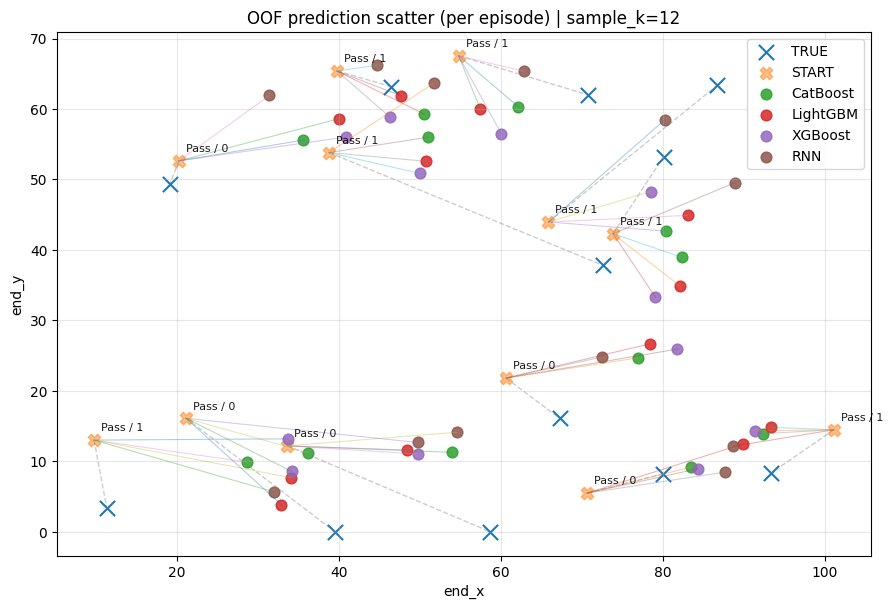

game_episode     true_x     true_y  CatBoost_x  CatBoost_y  LightGBM_x  \
0     126367_77  19.173420  49.407440   35.541645   55.570671   40.019123   
1     126299_63  67.266777  16.102196   76.905151   24.676046   78.425880   
2      126436_8  58.717892   0.000000   53.972633   11.273827   48.495247   
3     126385_51  46.502506  63.178772   50.542892   59.292812   47.695511   
4     126411_69  86.712257  63.335670   80.393234   42.667484   83.072342   
5     126453_61  72.595528  37.829079   50.999321   55.984425   50.780376   
6     126300_24  11.384310   3.325132   28.707043    9.882897   34.080379   
7     126366_72  93.365997   8.309464   92.388672   13.929677   93.405983   
8     126301_22  39.557072   0.000000   36.256481   11.221292   32.928818   
9     126420_80  80.115417  53.229176   82.340477   38.957668   82.160889   
10    126476_46  70.831947  61.993382   62.198753   60.304848   57.477238   
11     126321_2  80.088539   8.218616   83.504395    9.181068   89.963043   

    LightGBM_y  XGBoost_x  XGBoost_y      RNN_x      RNN_y  
0    58.616562  40.891331  56.014225  31.443190  61.918747  
1    26.676634  81.830894  25.928505  72.540207  24.808880  
2    11.598429  49.786579  11.037538  54.621887  14.137243  
3    61.864811  46.384693  58.807339  44.753792  66.210152  
4    44.900177  78.544769  48.285900  80.237022  58.451019  
5    52.577465  50.001152  50.863094  51.826981  63.729698  
6     7.690404  33.769035  13.190310  32.072605   5.646393  
7    14.823883  91.454384  14.329992  88.744423  12.146561  
8     3.852021  34.181812   8.588523  49.739662  12.674156  
9    34.858349  79.110130  33.282135  88.951820  49.558662  
10   60.032909  60.068623  56.520294  62.921608  65.339256  
11   12.471419  84.313354   8.939935  87.722572   8.473730

In [80]:
oof_cb = np.array([[x,y] for x,y in zip(oof_x_cb, oof_y_cb)], dtype=np.float32)
oof_lgb = np.array([[x,y] for x,y in zip(oof_x_lgb, oof_y_lgb)], dtype=np.float32)
oof_xgb = np.array([[x,y] for x,y in zip(oof_x_xgb, oof_y_xgb)], dtype=np.float32)

preds_dict = {
    "CatBoost": oof_cb,
    "LightGBM": oof_lgb,
    "XGBoost": oof_xgb,
    "RNN": oof_delta + start0_all  # delta -> end
}

plot_episode_predictions(
    train_raw,
    preds_dict=preds_dict,
    y_map=y_map,      
)

## MLP softgating

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# -------------------------
# metric
# -------------------------
def mean_euclid_xy(pred_xy, true_xy):
    d = np.sqrt(((pred_xy - true_xy) ** 2).sum(axis=1))
    return float(d.mean())


# -------------------------
# helper: make sure pred is end_xy
# -------------------------
def to_end_pred(pred, start_xy=None, mode="end"):
    """
    pred: (N,2)
    start_xy: (N,2) required if mode="delta"
    """
    pred = np.asarray(pred, dtype=np.float32)
    if mode == "end":
        return pred
    elif mode == "delta":
        assert start_xy is not None
        return (start_xy.astype(np.float32) + pred).astype(np.float32)
    else:
        raise ValueError("mode must be 'end' or 'delta'")


# -------------------------
# build meta features
# -------------------------
def build_meta_features(df_ep: pd.DataFrame, cat_cols=("type_name",), num_cols=("start_x","start_y")):
    """
    returns:
      X_num: (N, Dn) float32
      X_cat: dict col -> int64 indices (N,)
      cat_maps: dict col -> {value: idx}
    """
    # numeric
    X_num = df_ep.loc[:, list(num_cols)].copy()

    # optional numeric features
    if "start_zone" in df_ep.columns:
        X_num["start_zone"] = df_ep["start_zone"].astype(np.float32)
    if "time_seconds" in df_ep.columns:
        X_num["time_seconds"] = df_ep["time_seconds"].astype(np.float32)

    # simple length proxy if you have end targets (train only)
    # (this is allowed because it's target-dependent; DO NOT include this for test-time meta-features)
    # 대신 start 기반 proxy(예: field position)만 쓰는 걸 추천.
    # 여기서는 안전하게 넣지 않음.

    X_num = X_num.astype(np.float32).values

    # categorical -> indices
    X_cat = {}
    cat_maps = {}
    for c in cat_cols:
        if c in df_ep.columns:
            vals = df_ep[c].fillna("__NA__").astype(str).values
            uniq = pd.unique(vals)
            m = {v:i+1 for i,v in enumerate(uniq)}  # 0 unknown
            X_cat[c] = np.array([m.get(v, 0) for v in vals], dtype=np.int64)
            cat_maps[c] = m

    return X_num, X_cat, cat_maps


# -------------------------
# Dataset
# -------------------------
class GateDataset(Dataset):
    def __init__(self, X_num, X_cat_dict, base_preds, y_true):
        """
        X_num: (N,Dn)
        X_cat_dict: dict col -> (N,)
        base_preds: (N, M, 2)  base model end predictions
        y_true: (N,2)
        """
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.base = torch.tensor(base_preds, dtype=torch.float32)
        self.y = torch.tensor(y_true, dtype=torch.float32)

        self.cat_cols = sorted(list(X_cat_dict.keys()))
        self.X_cat = {}
        for c in self.cat_cols:
            self.X_cat[c] = torch.tensor(X_cat_dict[c], dtype=torch.long)

    def __len__(self):
        return self.X_num.size(0)

    def __getitem__(self, idx):
        item = {
            "x_num": self.X_num[idx],
            "base": self.base[idx],
            "y": self.y[idx],
        }
        for c in self.cat_cols:
            item[c] = self.X_cat[c][idx]
        return item


def gate_collate(batch, cat_cols):
    x_num = torch.stack([b["x_num"] for b in batch], dim=0)
    base  = torch.stack([b["base"] for b in batch], dim=0)
    y     = torch.stack([b["y"] for b in batch], dim=0)
    cats = {}
    for c in cat_cols:
        cats[c] = torch.stack([b[c] for b in batch], dim=0)
    return x_num, cats, base, y


# -------------------------
# Gate Model (softmax weights)
# -------------------------
class SoftGateMLP(nn.Module):
    def __init__(self, num_dim, cat_cardinalities=None, cat_emb_dim=8,
                 n_models=4, hidden=128, dropout=0.1, use_base_as_input=True):
        """
        cat_cardinalities: dict col -> card
        use_base_as_input: gate input에 base preds (M*2)를 넣을지 여부 (추천: True)
        """
        super().__init__()
        self.n_models = n_models
        self.use_base_as_input = use_base_as_input

        self.cat_cols = []
        self.cat_embs = nn.ModuleDict()
        cat_total_dim = 0
        if cat_cardinalities:
            self.cat_cols = sorted(list(cat_cardinalities.keys()))
            for c in self.cat_cols:
                self.cat_embs[c] = nn.Embedding(cat_cardinalities[c], cat_emb_dim)
                cat_total_dim += cat_emb_dim

        base_dim = n_models * 2 if use_base_as_input else 0
        in_dim = num_dim + cat_total_dim + base_dim

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_models)
        )

    def forward(self, x_num, x_cats, base_preds):
        parts = [x_num]
        for c in self.cat_cols:
            parts.append(self.cat_embs[c](x_cats[c]))
        if self.use_base_as_input:
            parts.append(base_preds.view(base_preds.size(0), -1))  # (B, M*2)

        x = torch.cat(parts, dim=1)
        logits = self.mlp(x)                      # (B, M)
        w = F.softmax(logits, dim=1)              # (B, M)
        pred = torch.einsum("bm,bmd->bd", w, base_preds)  # weighted sum -> (B,2)
        return pred, w


# -------------------------
# Train one fold
# -------------------------
def train_gate_one_fold(model, dl_tr, dl_va, device, lr=2e-3, epochs=30, wd=1e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.MSELoss()

    best = 1e9
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        for x_num, x_cats, base, y in dl_tr:
            x_num, base, y = x_num.to(device), base.to(device), y.to(device)
            x_cats = {k:v.to(device) for k,v in x_cats.items()}

            pred, w = model(x_num, x_cats, base)
            loss = loss_fn(pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

        # val
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for x_num, x_cats, base, y in dl_va:
                x_num, base = x_num.to(device), base.to(device)
                x_cats = {k:v.to(device) for k,v in x_cats.items()}
                pred, w = model(x_num, x_cats, base)
                preds.append(pred.cpu().numpy())
                trues.append(y.numpy())

        preds = np.vstack(preds).astype(np.float32)
        trues = np.vstack(trues).astype(np.float32)
        score = mean_euclid_xy(preds, trues)

        if score < best:
            best = score
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

        if ep == 1 or ep % 5 == 0:
            print(f"[Gate] epoch {ep:02d} val_dist={score:.4f} best={best:.4f}")

    model.load_state_dict(best_state)
    return model, best


# -------------------------
# OOF CV for gate
# -------------------------
def gate_oof_cv(
    df_ep: pd.DataFrame,
    base_oof_dict: dict,  # name -> (N,2) end preds
    y_true: np.ndarray,   # (N,2)
    groups: np.ndarray,
    cat_cols=("type_name","result_name_bin"),
    num_cols=("start_x","start_y"),
    n_splits=5,
    batch_size=256,
    epochs=30,
    lr=2e-3,
    device="cpu",
    use_base_as_input=True,
):
    assert len(df_ep) == y_true.shape[0]
    model_names = list(base_oof_dict.keys())
    M = len(model_names)

    # meta features
    X_num, X_cat, cat_maps = build_meta_features(df_ep, cat_cols=cat_cols, num_cols=num_cols)

    # scale numeric (important for MLP)
    scaler = StandardScaler()
    X_num = scaler.fit_transform(X_num).astype(np.float32)

    # cat cardinalities
    cat_cards = {c: (len(cat_maps[c]) + 1) for c in cat_maps.keys()}

    # base preds stack: (N,M,2)
    base_stack = np.stack([base_oof_dict[n] for n in model_names], axis=1).astype(np.float32)

    oof_pred = np.zeros((len(df_ep), 2), dtype=np.float32)
    oof_w    = np.zeros((len(df_ep), M), dtype=np.float32)

    gkf = GroupKFold(n_splits=n_splits)
    for fold, (tr_idx, va_idx) in enumerate(gkf.split(df_ep, groups=groups), 1):
        ds_tr = GateDataset(X_num[tr_idx], {c:X_cat[c][tr_idx] for c in X_cat}, base_stack[tr_idx], y_true[tr_idx])
        ds_va = GateDataset(X_num[va_idx], {c:X_cat[c][va_idx] for c in X_cat}, base_stack[va_idx], y_true[va_idx])

        cat_list = sorted(list(X_cat.keys()))
        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,
                           collate_fn=lambda b: gate_collate(b, cat_list))
        dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False,
                           collate_fn=lambda b: gate_collate(b, cat_list))

        model = SoftGateMLP(
            num_dim=X_num.shape[1],
            cat_cardinalities=cat_cards if len(cat_cards)>0 else None,
            cat_emb_dim=8,
            n_models=M,
            hidden=128,
            dropout=0.10,
            use_base_as_input=use_base_as_input
        ).to(device)

        model, best = train_gate_one_fold(model, dl_tr, dl_va, device, lr=lr, epochs=epochs)

        # predict fold
        model.eval()
        preds, ws = [], []
        with torch.no_grad():
            for x_num_b, x_cats_b, base_b, y_b in dl_va:
                x_num_b, base_b = x_num_b.to(device), base_b.to(device)
                x_cats_b = {k:v.to(device) for k,v in x_cats_b.items()}
                pred_b, w_b = model(x_num_b, x_cats_b, base_b)
                preds.append(pred_b.cpu().numpy())
                ws.append(w_b.cpu().numpy())

        preds = np.vstack(preds).astype(np.float32)
        ws = np.vstack(ws).astype(np.float32)
        oof_pred[va_idx] = preds
        oof_w[va_idx] = ws

        fold_score = mean_euclid_xy(preds, y_true[va_idx])
        print(f"[Fold {fold}] gate_val_dist={fold_score:.4f} best={best:.4f}")

    oof_score = mean_euclid_xy(oof_pred, y_true)
    print(f"[GATE OOF] dist={oof_score:.6f}")

    return oof_pred, oof_w, model_names

In [85]:
# df_ep: episode-level train df (N rows)
# 필수: game_episode, start_x, start_y, target_end_x_m, target_end_y_m, game_id
df_ep = train_df.copy()

# y_true
y_true = df_ep[["target_end_x_m","target_end_y_m"]].values.astype(np.float32)

# groups (game_id per episode)
groups = df_ep["game_id"].values

# start
start_xy = df_ep[["start_x","start_y"]].values.astype(np.float32)

# base OOF preds 준비 (모두 (N,2) end pred로)
# 예시: 네가 이미 oof_x_cb, oof_y_cb 같은 걸 갖고 있다면:
oof_cb_end  = np.stack([oof_x_cb,  oof_y_cb],  axis=1).astype(np.float32)
oof_lgb_end = np.stack([oof_x_lgb, oof_y_lgb], axis=1).astype(np.float32)
oof_xgb_end = np.stack([oof_x_xgb, oof_y_xgb], axis=1).astype(np.float32)

# RNN/GRU가 delta 예측이면 end로 변환
# (너 로그에 GRU는 delta였던 것 같으니 예시로)
# oof_delta_gru: (N,2) 이면
oof_delta_gru = oof_delta
oof_gru_end = to_end_pred(oof_delta_gru, start_xy=start_xy, mode="delta")

base_oof_dict = {
    "CatBoost": oof_cb_end,
    "LightGBM": oof_lgb_end,
    "XGBoost":  oof_xgb_end,
    "GRU":      oof_gru_end,
}

device = "mps" if torch.backends.mps.is_available() else "cpu"

gate_oof_pred, gate_oof_w, model_names = gate_oof_cv(
    df_ep=df_ep,
    base_oof_dict=base_oof_dict,
    y_true=y_true,
    groups=groups,
    cat_cols=("type_name","result_name_bin"),  # 없으면 ("type_name",) 또는 ()
    num_cols=("start_x","start_y"),
    n_splits=5,
    batch_size=256,
    epochs=40,
    lr=2e-3,
    device=device,
    use_base_as_input=True,  # base preds도 gate 입력으로 줌 (강추)
)

print("Gate OOF:", mean_euclid_xy(gate_oof_pred, y_true))

[Gate] epoch 01 val_dist=17.0807 best=17.0807
[Gate] epoch 05 val_dist=16.3520 best=16.3520
[Gate] epoch 10 val_dist=16.3520 best=16.3520
[Gate] epoch 15 val_dist=16.3520 best=16.3520
[Gate] epoch 20 val_dist=16.3520 best=16.3520
[Gate] epoch 25 val_dist=16.3520 best=16.3520
[Gate] epoch 30 val_dist=16.3520 best=16.3520
[Gate] epoch 35 val_dist=16.3520 best=16.3520
[Gate] epoch 40 val_dist=16.3520 best=16.3520
[Fold 1] gate_val_dist=16.3520 best=16.3520
[Gate] epoch 01 val_dist=16.4865 best=16.4865
[Gate] epoch 05 val_dist=16.4867 best=16.4865
[Gate] epoch 10 val_dist=16.4867 best=16.4865
[Gate] epoch 15 val_dist=16.4868 best=16.4865
[Gate] epoch 20 val_dist=16.4868 best=16.4865
[Gate] epoch 25 val_dist=16.4868 best=16.4865
[Gate] epoch 30 val_dist=16.4868 best=16.4845
[Gate] epoch 35 val_dist=16.4868 best=16.4845
[Gate] epoch 40 val_dist=16.4868 best=16.4845
[Fold 2] gate_val_dist=16.4845 best=16.4845
[Gate] epoch 01 val_dist=16.3206 best=16.3206
[Gate] epoch 05 val_dist=16.3205 best=

In [86]:
# gate_oof_w: (N, M)
w_df = pd.DataFrame(gate_oof_w, columns=model_names)
w_df["game_episode"] = df_ep["game_episode"].values
w_df["start_x"] = df_ep["start_x"].values
w_df["start_y"] = df_ep["start_y"].values
w_df["type_name"] = df_ep["type_name"].values if "type_name" in df_ep.columns else None

w_df.head()

CatBoost      LightGBM       XGBoost           GRU game_episode  \
0       1.0  6.342551e-14  7.052812e-15  1.863159e-36     126283_1   
1       1.0  5.765510e-12  1.662653e-13  5.686314e-33    126283_10   
2       1.0  2.137528e-10  3.725947e-11  1.025157e-29    126283_11   
3       1.0  1.269543e-12  6.944280e-14  5.444372e-33    126283_12   
4       1.0  3.134544e-07  2.077146e-08  2.192122e-22    126283_13   

      start_x    start_y type_name  
0  101.054205  52.757324      Pass  
1  102.213510  51.930444      Pass  
2   67.934265  11.028172      Pass  
3   80.991120  66.827109      Pass  
4   14.527695  21.594692      Pass

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

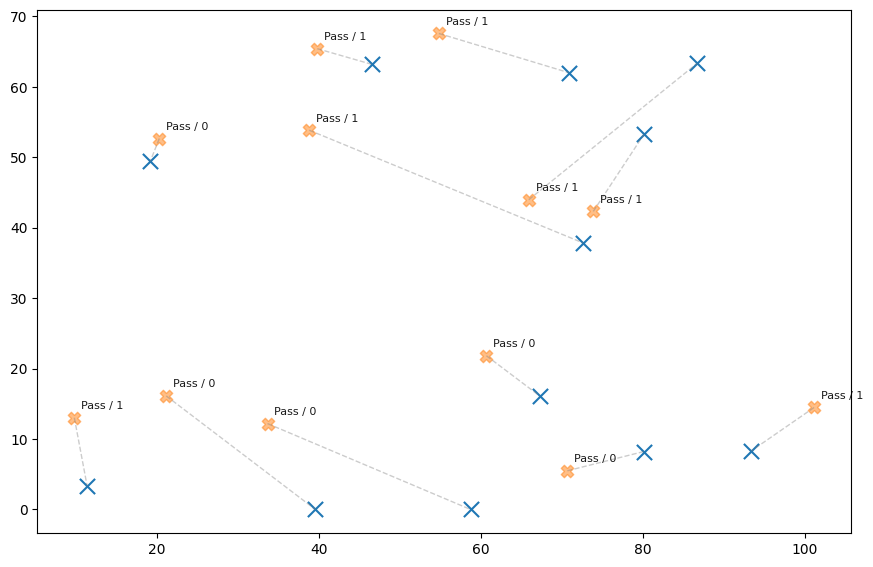

In [89]:
# episode index i
i = 0

preds = {
  "CatBoost": base_oof_dict["CatBoost"][i],
  "LightGBM": base_oof_dict["LightGBM"][i],
  "XGBoost":  base_oof_dict["XGBoost"][i],
  "GRU":      base_oof_dict["GRU"][i],
  "GATE":     gate_oof_pred[i],
}
# pred_mode="end" 로

plot_episode_predictions(df, preds_dict=preds,  y_map=y_map)

In [90]:
import random
import numpy as np
import pandas as pd
import networkx as nx

from gensim.models import Word2Vec
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# =========================
# A. Constants / Utils
# =========================
PITCH_X = 105.0
PITCH_Y = 68.0

X_BINS = 12
Y_BINS = 8
N_ZONES = X_BINS * Y_BINS  # 96


def clamp_xy(x, y):
    x = float(np.clip(x, 0, PITCH_X))
    y = float(np.clip(y, 0, PITCH_Y))
    return x, y


def xy_to_zone(x, y, x_bins=X_BINS, y_bins=Y_BINS, pitch_x=PITCH_X, pitch_y=PITCH_Y):
    # x in [0,105], y in [0,68]
    x = np.clip(x, 0, pitch_x - 1e-6)
    y = np.clip(y, 0, pitch_y - 1e-6)
    zx = int(x / (pitch_x / x_bins))
    zy = int(y / (pitch_y / y_bins))
    return zy * x_bins + zx  # 0..95


def mean_euclid_end(pred_end, true_end):
    d = np.sqrt(((pred_end - true_end) ** 2).sum(axis=1))
    return float(d.mean())


def mean_euclid_end_from_delta(pred_delta, true_end, start0):
    pred_end = start0 + pred_delta
    return mean_euclid_end(pred_end, true_end)


# =========================
# B. Build episode maps (start0, end_last, delta)
# =========================
def build_episode_start0_end_last_delta(train_raw: pd.DataFrame):
    df = train_raw.sort_values(["game_episode", "time_seconds"])

    first = df.groupby("game_episode", sort=False).head(1).set_index("game_episode")
    last  = df.groupby("game_episode", sort=False).tail(1).set_index("game_episode")

    start0 = first[["start_x", "start_y"]].astype(np.float32)
    start0.columns = ["start0_x", "start0_y"]

    end_last = last[["end_x", "end_y"]].astype(np.float32)
    end_last.columns = ["end_x", "end_y"]

    delta = (end_last.values - start0.values).astype(np.float32)
    delta = pd.DataFrame(delta, index=start0.index, columns=["dx", "dy"])

    # end zone label (from end_last)
    end_zone = end_last.apply(lambda r: xy_to_zone(r["end_x"], r["end_y"]), axis=1).astype(int)
    end_zone.name = "end_zone"

    return start0, end_last, delta, end_zone


# =========================
# C. DeepWalk
# =========================
def random_walk(G: nx.Graph, start, walk_len=40):
    walk = [start]
    cur = start
    for _ in range(walk_len - 1):
        nbrs = list(G.neighbors(cur))
        if len(nbrs) == 0:
            break
        cur = random.choice(nbrs)
        walk.append(cur)
    return walk


def deepwalk_embeddings(G: nx.Graph, dim=32, num_walks=10, walk_len=40, window=5, workers=4, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    walks = []
    for _ in range(num_walks):
        random.shuffle(nodes)
        for n in nodes:
            walks.append(random_walk(G, n, walk_len=walk_len))

    w2v = Word2Vec(
        sentences=walks,
        vector_size=dim,
        window=window,
        min_count=1,
        sg=1,
        workers=workers,
        seed=seed
    )

    emb = {n: w2v.wv[n].astype(np.float32) for n in G.nodes()}
    return emb


def get_emb(emb_dict, key, dim):
    v = emb_dict.get(key, None)
    if v is None:
        return np.zeros((dim,), dtype=np.float32)
    v = np.asarray(v, dtype=np.float32)
    if v.shape[0] != dim:
        v = v[:dim]
        if v.shape[0] < dim:
            v = np.pad(v, (0, dim - v.shape[0]))
    return v


# =========================
# D. Graph builder for DeepWalk (fold-only)
# =========================
def make_node_keys_from_row(row: pd.Series):
    """
    ⚠️ 너가 build_train_graph에서 만들었던 노드명 규칙과 동일해야 함.

    아래는 예시:
      player: "P_{player_id}"
      team  : "T_{team_id}"
      type  : "TP_{type_name}"
      zone  : "Z_{start_zone}"

    네 그래프가 action도 포함했으면 "A_{action_id}"도 추가 가능.
    """
    keys = []
    if "player_id" in row and pd.notna(row["player_id"]):
        keys.append(f"P_{row['player_id']}")
    if "team_id" in row and pd.notna(row["team_id"]):
        keys.append(f"T_{row['team_id']}")
    if "type_name" in row and pd.notna(row["type_name"]):
        keys.append(f"TP_{row['type_name']}")
    if "start_zone" in row and pd.notna(row["start_zone"]):
        keys.append(f"Z_{int(row['start_zone'])}")

    # optional
    if "action_id" in row and pd.notna(row["action_id"]):
        keys.append(f"A_{row['action_id']}")

    return keys


def build_deepwalk_graph_from_df(df: pd.DataFrame, add_temporal_edges=True):
    """
    fold train df만 넣어서 G를 만든다.
    - 이벤트(row)마다 속성 노드들(player/team/type/zone/action)을 가져오고,
      같은 row 안의 노드들을 완전연결(클릭)로 연결.
    - 선택: 시간흐름을 반영하려면 "같은 episode의 연속 row에서 player->next player"
      같은 temporal edge도 추가 가능. (기본은 가볍게)
    """
    G = nx.Graph()

    df = df.sort_values(["game_episode", "time_seconds"]).reset_index(drop=True)

    # 1) co-occur edges within a row
    for _, row in df.iterrows():
        nodes = make_node_keys_from_row(row)
        # add nodes
        for n in nodes:
            if not G.has_node(n):
                G.add_node(n)

        # fully connect inside this event
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                a, b = nodes[i], nodes[j]
                if a != b:
                    G.add_edge(a, b)

    # 2) optional temporal edges within episode (light)
    if add_temporal_edges:
        # connect consecutive players/types/zones to give "flow" signal
        grp = df.groupby("game_episode", sort=False)
        for _, g in grp:
            g = g.sort_values("time_seconds")
            prev_nodes = None
            for _, row in g.iterrows():
                cur_nodes = make_node_keys_from_row(row)
                if prev_nodes is not None and len(prev_nodes) > 0 and len(cur_nodes) > 0:
                    # connect one representative pair for cheapness
                    G.add_edge(prev_nodes[0], cur_nodes[0])
                prev_nodes = cur_nodes

    return G


# =========================
# E. Episode Dataset for GRU + pooling + multitask
# =========================
CAT_COLS = ["player_id", "team_id", "type_name", "period_id"]  # action_id는 선택 (너 데이터에 맞춰)


class EpisodeSeqDataset(Dataset):
    """
    episode -> variable length sequence:
      x_num: (T, num_dim)
      x_cat: (T, C)
      x_ge:  (T, emb_dim)  # emb_sum (32d) 추천
      pool:  episode pooling vector (pool_dim)
      y_delta: (2,)
      y_zone:  int
      start0: (2,)
      label: (type_name, result_name_bin) from first row (for plotting)
    """
    def __init__(self,
                 raw_df: pd.DataFrame,
                 episode_keys,
                 start0_map: pd.DataFrame,
                 end_map: pd.DataFrame,
                 delta_map: pd.DataFrame,
                 end_zone_map: pd.Series,
                 emb_dict: dict,
                 emb_dim=32,
                 cat_maps=None,
                 use_emb_sum=True,
                 pool_last_k=5):

        self.raw = raw_df
        self.eps = list(episode_keys)

        self.start0_map = start0_map
        self.end_map = end_map
        self.delta_map = delta_map
        self.end_zone_map = end_zone_map

        self.emb = emb_dict
        self.emb_dim = emb_dim
        self.use_emb_sum = use_emb_sum
        self.pool_last_k = pool_last_k

        # build cat maps if not given (0 unknown)
        if cat_maps is None:
            cat_maps = {}
            for c in CAT_COLS:
                if c in raw_df.columns:
                    vals = raw_df[c].dropna().unique().tolist()
                    cat_maps[c] = {v: i + 1 for i, v in enumerate(vals)}
        self.cat_maps = cat_maps
        self.used_cats = [c for c in CAT_COLS if c in self.cat_maps]

    def __len__(self):
        return len(self.eps)

    def _event_emb(self, row):
        # keys from row -> fetch -> sum or concat
        keys = make_node_keys_from_row(row)
        if len(keys) == 0:
            return np.zeros((self.emb_dim,), dtype=np.float32)

        vecs = [get_emb(self.emb, k, self.emb_dim) for k in keys]

        if self.use_emb_sum:
            # 32d 유지 (추천)
            return np.sum(vecs, axis=0).astype(np.float32)
        else:
            # concat: (len(keys)*emb_dim)  (권장X: 길이 변동 -> 보통 고정 subset만 concat해야 함)
            return np.concatenate(vecs, axis=0).astype(np.float32)

    def __getitem__(self, idx):
        ep = self.eps[idx]
        ep_df = self.raw[self.raw["game_episode"] == ep].sort_values("time_seconds").reset_index(drop=True)

        # ---------- numeric sequence features (NO end_x/end_y 기반 feature!)
        t = ep_df["time_seconds"].values.astype(np.float32)
        dt = np.zeros_like(t)
        dt[1:] = t[1:] - t[:-1]

        start_x = ep_df["start_x"].values.astype(np.float32)
        start_y = ep_df["start_y"].values.astype(np.float32)
        is_home = ep_df["is_home"].astype(int).values.astype(np.float32)

        # basic num feats (추천: 최소한으로 시작)
        x_num = np.stack([dt, start_x, start_y, is_home], axis=1).astype(np.float32)  # (T,4)

        # ---------- categorical indices per step
        cats = []
        for c in self.used_cats:
            m = self.cat_maps[c]
            cats.append(ep_df[c].map(lambda v: m.get(v, 0)).values.astype(np.int64))
        x_cat = np.stack(cats, axis=1).astype(np.int64) if len(cats) > 0 else np.zeros((len(ep_df), 0), dtype=np.int64)

        # ---------- graph embedding per step
        ge_list = [self._event_emb(ep_df.iloc[i]) for i in range(len(ep_df))]
        x_ge = np.stack(ge_list, axis=0).astype(np.float32)  # (T, emb_dim)

        # ---------- episode pooling features (mean, last-k mean, delta)
        mean_emb = x_ge.mean(axis=0)
        k = min(self.pool_last_k, len(x_ge))
        lastk = x_ge[-k:].mean(axis=0)
        firstk = x_ge[:k].mean(axis=0)
        delta_emb = (lastk - firstk).astype(np.float32)
        pool = np.concatenate([mean_emb, lastk, delta_emb], axis=0).astype(np.float32)  # (3*emb_dim,)

        # ---------- targets
        y_delta = self.delta_map.loc[ep].values.astype(np.float32)   # (2,)
        y_zone = int(self.end_zone_map.loc[ep])                      # int 0..95
        start0 = self.start0_map.loc[ep].values.astype(np.float32)   # (2,)

        # label for plotting: first event type_name, result_name_bin
        type0 = ep_df["type_name"].iloc[0] if "type_name" in ep_df.columns else ""
        res0  = int(ep_df["result_name_bin"].iloc[0]) if "result_name_bin" in ep_df.columns else -1

        return {
            "x_num": torch.tensor(x_num, dtype=torch.float),
            "x_cat": torch.tensor(x_cat, dtype=torch.long),
            "x_ge":  torch.tensor(x_ge, dtype=torch.float),
            "pool":  torch.tensor(pool, dtype=torch.float),
            "len":   len(ep_df),
            "y_delta": torch.tensor(y_delta, dtype=torch.float),
            "y_zone":  torch.tensor(y_zone, dtype=torch.long),
            "start0":  torch.tensor(start0, dtype=torch.float),
            "label_type": str(type0),
            "label_res": int(res0),
            "ep": ep
        }


def collate_pad(batch):
    lens = [b["len"] for b in batch]
    maxlen = max(lens)

    def pad_2d(x, maxlen, pad_value=0.0):
        T, D = x.shape
        if T == maxlen:
            return x
        pad = x.new_full((maxlen - T, D), pad_value)
        return torch.cat([x, pad], dim=0)

    x_num = torch.stack([pad_2d(b["x_num"], maxlen) for b in batch], dim=0)  # (B,L,4)
    x_ge  = torch.stack([pad_2d(b["x_ge"],  maxlen) for b in batch], dim=0)  # (B,L,emb_dim)

    # cat
    C = batch[0]["x_cat"].shape[1]
    if C > 0:
        def pad_cat(x):
            T, C = x.shape
            if T == maxlen:
                return x
            pad = x.new_zeros((maxlen - T, C))
            return torch.cat([x, pad], dim=0)
        x_cat = torch.stack([pad_cat(b["x_cat"]) for b in batch], dim=0)  # (B,L,C)
    else:
        x_cat = torch.zeros((len(batch), maxlen, 0), dtype=torch.long)

    pool = torch.stack([b["pool"] for b in batch], dim=0)  # (B, pool_dim)
    y_delta = torch.stack([b["y_delta"] for b in batch], dim=0)  # (B,2)
    y_zone  = torch.stack([b["y_zone"] for b in batch], dim=0)   # (B,)
    start0  = torch.stack([b["start0"] for b in batch], dim=0)   # (B,2)

    lens = torch.tensor(lens, dtype=torch.long)

    # keep meta for plotting
    eps = [b["ep"] for b in batch]
    label_type = [b["label_type"] for b in batch]
    label_res  = [b["label_res"] for b in batch]

    return x_num, x_cat, x_ge, pool, lens, y_delta, y_zone, start0, eps, label_type, label_res


# =========================
# F. Model: GRU + Pooling + Multi-task (delta + end_zone)
# =========================
class GRUMultiTask(nn.Module):
    def __init__(self,
                 cat_cards: dict,
                 cat_emb_dim=16,
                 num_dim=4,
                 emb_dim=32,
                 pool_mult=3,         # pool is 3*emb_dim
                 rnn_hidden=128,
                 rnn_layers=1,
                 bidir=False):

        super().__init__()
        self.used_cats = list(cat_cards.keys())
        self.cat_embs = nn.ModuleDict({
            c: nn.Embedding(cat_cards[c], cat_emb_dim) for c in self.used_cats
        })

        in_dim = num_dim + emb_dim + len(self.used_cats) * cat_emb_dim

        self.rnn = nn.GRU(in_dim, rnn_hidden, num_layers=rnn_layers,
                          batch_first=True, bidirectional=bidir)

        hdim = rnn_hidden * (2 if bidir else 1)
        pool_dim = pool_mult * emb_dim  # 3*emb_dim

        trunk_out = hdim + pool_dim

        self.delta_head = nn.Sequential(
            nn.Linear(trunk_out, trunk_out),
            nn.ReLU(),
            nn.Linear(trunk_out, 2)
        )

        self.zone_head = nn.Sequential(
            nn.Linear(trunk_out, trunk_out),
            nn.ReLU(),
            nn.Linear(trunk_out, N_ZONES)
        )

    def forward(self, x_num, x_cat, x_ge, pool, lens):
        # x_num (B,L,4), x_ge (B,L,emb_dim)
        B, L, _ = x_num.shape

        cat_parts = []
        # x_cat is (B,L,C) where C == len(self.used_cats) if you keep consistent ordering.
        # We'll assume Dataset self.used_cats order equals CAT_COLS filtered order;
        # simplest: enforce same order when creating cat_maps below.
        if x_cat.shape[2] > 0:
            # map along CAT_COLS order
            col_order = [c for c in CAT_COLS if c in self.used_cats]
            for i, c in enumerate(col_order):
                cat_parts.append(self.cat_embs[c](x_cat[:, :, i]))
            x_cat_emb = torch.cat(cat_parts, dim=2)
            x = torch.cat([x_num, x_ge, x_cat_emb], dim=2)
        else:
            x = torch.cat([x_num, x_ge], dim=2)

        # pack
        packed = nn.utils.rnn.pack_padded_sequence(x, lens.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h = self.rnn(packed)

        last = h[-1]  # (B, hdim)
        feat = torch.cat([last, pool], dim=1)  # (B, hdim + pool_dim)

        pred_delta = self.delta_head(feat)  # (B,2)
        logits_zone = self.zone_head(feat)  # (B,96)
        return pred_delta, logits_zone


# =========================
# G. Train / Eval
# =========================
def train_one_fold_multitask(model, dl_tr, dl_va, device,
                             lr=1e-3, epochs=20,
                             lambda_zone=0.2):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    ce = nn.CrossEntropyLoss()

    best = 1e9
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        for x_num, x_cat, x_ge, pool, lens, y_delta, y_zone, start0, eps, lt, lr0 in dl_tr:
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            x_ge  = x_ge.to(device)
            pool  = pool.to(device)
            lens  = lens.to(device)
            y_delta = y_delta.to(device)
            y_zone  = y_zone.to(device)

            pred_delta, logits_zone = model(x_num, x_cat, x_ge, pool, lens)

            loss_delta = mse(pred_delta, y_delta)
            loss_zone  = ce(logits_zone, y_zone)
            loss = loss_delta + lambda_zone * loss_zone

            opt.zero_grad()
            loss.backward()
            opt.step()

        # val
        model.eval()
        preds_delta = []
        trues_end = []
        starts = []
        with torch.no_grad():
            for x_num, x_cat, x_ge, pool, lens, y_delta, y_zone, start0, eps, lt, lr0 in dl_va:
                x_num = x_num.to(device)
                x_cat = x_cat.to(device)
                x_ge  = x_ge.to(device)
                pool  = pool.to(device)
                lens  = lens.to(device)

                pred_delta, _ = model(x_num, x_cat, x_ge, pool, lens)
                preds_delta.append(pred_delta.cpu().numpy())

                # build true_end from start0 + true_delta (or you can use end_map separately)
                starts.append(start0.numpy())
                trues_end.append((start0.numpy() + y_delta.numpy()))

        preds_delta = np.vstack(preds_delta).astype(np.float32)
        starts = np.vstack(starts).astype(np.float32)
        trues_end = np.vstack(trues_end).astype(np.float32)

        score = mean_euclid_end_from_delta(preds_delta, trues_end, starts)

        if score < best:
            best = score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if ep == 1 or ep % 5 == 0:
            print(f"[MultiTask] epoch {ep:02d} val_end_dist={score:.4f} best={best:.4f}")

    model.load_state_dict(best_state)
    return model, best


# =========================
# H. Full OOF Pipeline (Fold DeepWalk + MultiTask GRU)
# =========================
def oof_fold_deepwalk_gru_multitask(train_raw: pd.DataFrame,
                                   n_splits=5,
                                   emb_dim=32,
                                   deepwalk_dim=32,
                                   num_walks=10,
                                   walk_len=40,
                                   window=5,
                                   workers=4,
                                   batch_size=64,
                                   epochs=20,
                                   lr=1e-3,
                                   lambda_zone=0.2,
                                   device="cpu",
                                   seed=42):

    # episode maps
    start0_map, end_map, delta_map, end_zone_map = build_episode_start0_end_last_delta(train_raw)

    # eps list aligned
    eps = train_raw["game_episode"].unique()
    ge2gid = train_raw.groupby("game_episode")["game_id"].first()
    groups = ge2gid.loc[eps].values

    # cat maps (global, OK)
    cat_maps = {}
    for c in CAT_COLS:
        if c in train_raw.columns:
            vals = train_raw[c].dropna().unique().tolist()
            cat_maps[c] = {v: i + 1 for i, v in enumerate(vals)}
    # cat_cards (for Embedding)
    cat_cards = {c: (len(cat_maps[c]) + 1) for c in cat_maps.keys()}

    # store OOF preds
    oof_pred_delta = np.zeros((len(eps), 2), dtype=np.float32)
    oof_pred_zone  = np.zeros((len(eps), N_ZONES), dtype=np.float32)  # logits or probs

    gkf = GroupKFold(n_splits=n_splits)

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(eps, groups=groups), 1):
        tr_eps = eps[tr_idx]
        va_eps = eps[va_idx]

        df_tr = train_raw[train_raw["game_episode"].isin(tr_eps)].copy()
        df_va = train_raw[train_raw["game_episode"].isin(va_eps)].copy()

        # ---- Fold-only DeepWalk
        random.seed(seed + fold)
        print(f"\n[Fold {fold}] build graph for DeepWalk...")
        G_tr = build_deepwalk_graph_from_df(df_tr, add_temporal_edges=True)

        print(f"[Fold {fold}] deepwalk on |V|={G_tr.number_of_nodes()} |E|={G_tr.number_of_edges()} ...")
        emb_dict = deepwalk_embeddings(
            G_tr,
            dim=deepwalk_dim,
            num_walks=num_walks,
            walk_len=walk_len,
            window=window,
            workers=workers,
            seed=seed + fold
        )

        # ---- Datasets (train/val) using emb_dict trained only on train fold
        ds_tr = EpisodeSeqDataset(
            raw_df=train_raw,
            episode_keys=tr_eps,
            start0_map=start0_map,
            end_map=end_map,
            delta_map=delta_map,
            end_zone_map=end_zone_map,
            emb_dict=emb_dict,
            emb_dim=emb_dim,
            cat_maps=cat_maps,
            use_emb_sum=True,
            pool_last_k=5
        )
        ds_va = EpisodeSeqDataset(
            raw_df=train_raw,
            episode_keys=va_eps,
            start0_map=start0_map,
            end_map=end_map,
            delta_map=delta_map,
            end_zone_map=end_zone_map,
            emb_dict=emb_dict,
            emb_dim=emb_dim,
            cat_maps=cat_maps,
            use_emb_sum=True,
            pool_last_k=5
        )

        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=0, collate_fn=collate_pad)
        dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_pad)

        # ---- Model
        model = GRUMultiTask(
            cat_cards=cat_cards,
            cat_emb_dim=16,
            num_dim=4,
            emb_dim=emb_dim,
            pool_mult=3,
            rnn_hidden=128,
            rnn_layers=1,
            bidir=False
        ).to(device)

        # ---- Train
        model, best = train_one_fold_multitask(
            model, dl_tr, dl_va, device,
            lr=lr, epochs=epochs, lambda_zone=lambda_zone
        )
        print(f"[Fold {fold}] best_val_end_dist={best:.4f}")

        # ---- Val prediction store
        model.eval()
        all_delta = []
        all_zone_logits = []
        with torch.no_grad():
            for x_num, x_cat, x_ge, pool, lens, y_delta, y_zone, start0, eps_batch, lt, lr0 in dl_va:
                x_num = x_num.to(device)
                x_cat = x_cat.to(device)
                x_ge  = x_ge.to(device)
                pool  = pool.to(device)
                lens  = lens.to(device)

                pred_delta, logits_zone = model(x_num, x_cat, x_ge, pool, lens)
                all_delta.append(pred_delta.cpu().numpy())
                all_zone_logits.append(logits_zone.cpu().numpy())

        all_delta = np.vstack(all_delta).astype(np.float32)
        all_zone_logits = np.vstack(all_zone_logits).astype(np.float32)

        oof_pred_delta[va_idx] = all_delta
        oof_pred_zone[va_idx]  = all_zone_logits

    # ---- OOF score (end distance)
    start0_all = start0_map.loc[eps, ["start0_x", "start0_y"]].values.astype(np.float32)
    true_end   = end_map.loc[eps, ["end_x", "end_y"]].values.astype(np.float32)

    pred_end = start0_all + oof_pred_delta
    oof_dist = mean_euclid_end(pred_end, true_end)

    print(f"\n[OOF MultiTask GRU] end_dist={oof_dist:.6f}")

    # Return everything needed for plotting/ensembling
    out = {
        "eps": eps,
        "start0": start0_all,
        "true_end": true_end,
        "oof_pred_delta": oof_pred_delta,
        "oof_pred_end": pred_end,
        "oof_zone_logits": oof_pred_zone,
        "true_end_zone": end_zone_map.loc[eps].values.astype(int)
    }
    return out

In [91]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def _resolve_pred_end(start0_xy, pred_xy_or_delta, mode="end"):
    v = np.asarray(pred_xy_or_delta, dtype=float).reshape(2,)
    if mode == "delta":
        return start0_xy + v
    return v


def plot_episode_predictions(
    raw_df: pd.DataFrame,
    episode_key: str,
    preds: dict,
    pred_mode: dict,            # {"ModelA":"end", "ModelB":"delta", ...}
    pitch_img_path="football_field.png",
    x_bins=12, y_bins=8,
    show_sequence=True,
    alpha_seq=0.7
):
    """
    preds: dict[name] -> either (end_x,end_y) OR (dx,dy)
    pred_mode: dict[name] -> "end" or "delta"
    """

    ep_df = raw_df[raw_df["game_episode"] == episode_key].sort_values("time_seconds").reset_index(drop=True)
    if len(ep_df) == 0:
        raise ValueError(f"episode_key={episode_key} not found")

    # start0 and true_end (use first row start, last row end)
    start0 = ep_df.loc[0, ["start_x","start_y"]].values.astype(float)
    true_end = ep_df.loc[len(ep_df)-1, ["end_x","end_y"]].values.astype(float)

    start0[0], start0[1] = clamp_xy(start0[0], start0[1])
    true_end[0], true_end[1] = clamp_xy(true_end[0], true_end[1])

    # label from first event
    type0 = ep_df["type_name"].iloc[0] if "type_name" in ep_df.columns else ""
    res0  = int(ep_df["result_name_bin"].iloc[0]) if "result_name_bin" in ep_df.columns else -1
    lab = f"{type0}/{res0}"

    # image
    img = mpimg.imread(pitch_img_path)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(img, extent=[0, PITCH_X, 0, PITCH_Y], origin="lower")

    # grid
    for i in range(x_bins + 1):
        x = i * PITCH_X / x_bins
        ax.plot([x, x], [0, PITCH_Y], color="red", linewidth=0.7, alpha=0.35)
    for j in range(y_bins + 1):
        y = j * PITCH_Y / y_bins
        ax.plot([0, PITCH_X], [y, y], color="red", linewidth=0.7, alpha=0.35)

    # show sequence (start positions)
    if show_sequence:
        xs = ep_df["start_x"].values.astype(float)
        ys = ep_df["start_y"].values.astype(float)
        ax.plot(xs, ys, linewidth=1.2, alpha=alpha_seq)

    # START / TRUE
    ax.scatter(start0[0], start0[1], s=140, marker="X", zorder=6, label="START")
    ax.scatter(true_end[0], true_end[1], s=160, marker="x", zorder=7, label="TRUE END")

    # label near start
    ax.text(
        start0[0], start0[1], lab,
        fontsize=9, ha="left", va="bottom",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
    )

    # connect start->true
    ax.plot([start0[0], true_end[0]], [start0[1], true_end[1]], linestyle="--", linewidth=1.2, alpha=0.6)

    # model preds
    for name, pred in preds.items():
        mode = pred_mode.get(name, "end")
        pred_end = _resolve_pred_end(start0, pred, mode=mode)
        pred_end[0], pred_end[1] = clamp_xy(pred_end[0], pred_end[1])

        ax.scatter(pred_end[0], pred_end[1], s=140, zorder=8, label=f"{name} pred")
        ax.plot([start0[0], pred_end[0]], [start0[1], pred_end[1]], linewidth=2.0, alpha=0.8)

    ax.set_xlim(0, PITCH_X)
    ax.set_ylim(0, PITCH_Y)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(f"Episode {episode_key}: TRUE vs Predictions")
    ax.legend(loc="upper right")
    plt.show()

In [92]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("device:", device)

# train_raw: 원본 event-level DF (game_episode, time_seconds, start_x,start_y,end_x,end_y,...)
# ✅ start_zone 컬럼이 없으면 먼저 만들어줘야 함
if "start_zone" not in train_raw.columns:
    train_raw["start_zone"] = train_raw.apply(lambda r: xy_to_zone(r["start_x"], r["start_y"]), axis=1).astype(int)

# result_name_bin 없으면 (있다고 했지만) 안전하게
if "result_name_bin" not in train_raw.columns and "result_name" in train_raw.columns:
    train_raw["result_name_bin"] = (train_raw["result_name"] == "Successful").astype(int)



device: mps


In [93]:
train_raw

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
0        126283          1           1         0.667     2354     344559   
1        126283          1           1         3.667     2354     250036   
2        126283          1           1         4.968     2354     500145   
3        126283          1           1         8.200     2354     500145   
4        126283          1           1        11.633     2354     142106   
...         ...        ...         ...           ...      ...        ...   
356716   126480          1           9       801.901     4220     500552   
356717   126480          1           9       804.400     4220     500552   
356718   126480          1           9       806.101     4220     143588   
356719   126480          1           9       830.600     4220     143588   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name    start_x    start_y      end_x  \
0               0      Pass    Successful  52.418205  33.485444  31.322445   
1               2      Pass    Successful  32.013240  38.100808  37.371285   
2               4     Carry           NaN  37.371285  30.632980  38.391570   
3               5      Pass    Successful  38.391570  24.613144  34.573350   
4               7      Pass    Successful  34.578705   6.058256  21.274470   
...           ...       ...           ...        ...        ...        ...   
356716        502     Carry           NaN  12.462030  28.467860  15.703905   
356717        503      Pass    Successful  15.703905  31.839572  19.799745   
356718        505     Carry           NaN  19.799745  42.499592  34.005720   
356719        506      Pass    Successful  34.005720  31.293056  29.062320   
356720        508      Pass  Unsuccessful  29.311275  45.776920  83.430585   

            end_y  is_home game_episode  start_zone  result_name_bin  
0       38.274752     True     126283_1          41                1  
1       30.632980     True     126283_1          51                1  
2       24.613144     True     126283_1          40                0  
3        5.545468     True     126283_1          28                1  
4       18.437112     True     126283_1           3                1  
...           ...      ...          ...         ...              ...  
356716  31.839572    False     126480_9          37                0  
356717  42.499592    False     126480_9          37                1  
356718  31.293056    False     126480_9          50                0  
356719  47.929460    False     126480_9          39                1  
356720  57.047240    False     126480_9          63                0  

[356721 rows x 17 columns]

In [95]:
out = oof_fold_deepwalk_gru_multitask(
    train_raw=train_raw,
    n_splits=2,
    emb_dim=32,
    deepwalk_dim=32,
    num_walks=10,
    walk_len=40,
    window=5,
    workers=4,
    batch_size=64,
    epochs=5,
    lr=1e-3,
    lambda_zone=0.2,     # 0.1~0.5 스윕 추천
    device=device,
    seed=42
)

# OOF 결과 확인
eps = out["eps"]
true_end = out["true_end"]
pred_end = out["oof_pred_end"]
print("OOF mean euclid:", mean_euclid_end(pred_end, true_end))


[Fold 1] build graph for DeepWalk...
[Fold 1] deepwalk on |V|=3928 |E|=396035 ...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


[MultiTask] epoch 01 val_end_dist=36.6492 best=36.6492
[MultiTask] epoch 05 val_end_dist=16.8054 best=16.8054
[Fold 1] best_val_end_dist=16.8054

[Fold 2] build graph for DeepWalk...
[Fold 2] deepwalk on |V|=4041 |E|=399404 ...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


[MultiTask] epoch 01 val_end_dist=38.5084 best=38.5084
[MultiTask] epoch 05 val_end_dist=16.9274 best=16.9274
[Fold 2] best_val_end_dist=16.9274

[OOF MultiTask GRU] end_dist=16.866396
OOF mean euclid: 16.866395950317383


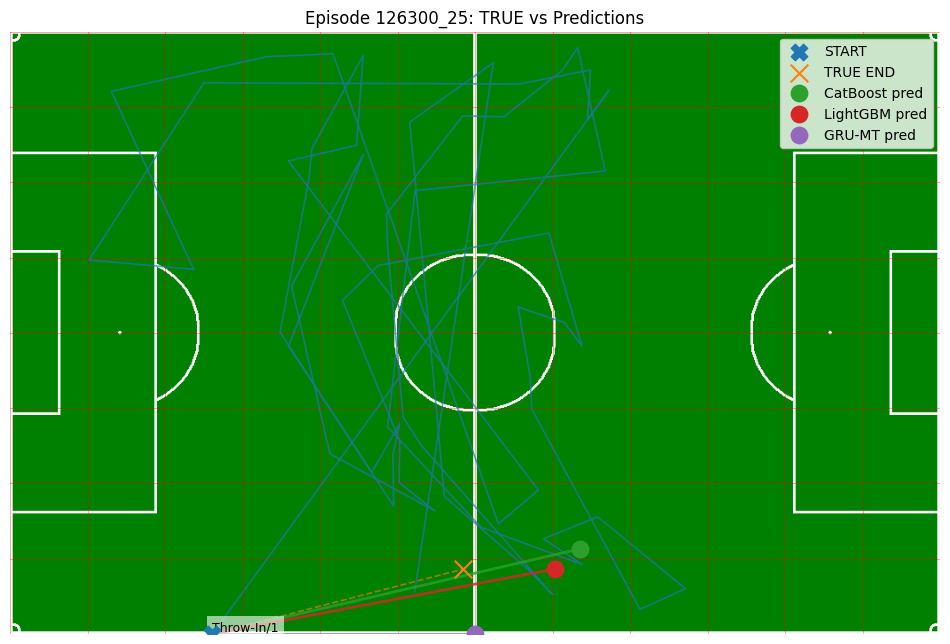

In [96]:
# sample one episode
rng = np.random.default_rng(42)
i = int(rng.integers(0, len(eps)))
ep = eps[i]

preds = {
    "CatBoost": oof_cb_end[i],          # (2,)
    "LightGBM": oof_lgb_end[i],         # (2,)
    "GRU-MT":   out["oof_pred_delta"][i]  # (2,) delta
}
pred_mode = {
    "CatBoost": "end",
    "LightGBM": "end",
    "GRU-MT": "delta"
}

plot_episode_predictions(
    raw_df=train_raw,
    episode_key=ep,
    preds=preds,
    pred_mode=pred_mode,
    pitch_img_path="football_field.png",
    show_sequence=True
)

In [98]:
train_df

game_episode  time_seconds     start_x    start_y  is_home  \
0         126283_1       124.367  101.054205  52.757324        1   
1        126283_10       695.473  102.213510  51.930444        0   
2        126283_11       894.237   67.934265  11.028172        0   
3        126283_12       940.933   80.991120  66.827109        1   
4        126283_13       997.233   14.527695  21.594692        0   
...            ...           ...         ...        ...      ...   
15430    126480_82      2723.500   58.451190   5.337796        0   
15431    126480_84      2847.767   67.990440  14.316380        1   
15432    126480_85      2896.200   76.747020  17.890664        0   
15433    126480_87      3020.800   63.547890   1.930724        1   
15434     126480_9       833.700   29.311275  45.776920        0   

       result_name_bin  start_zone player_id team_id type_name  ...   embT_30  \
0                    1          83    500146    2354      Pass  ...  0.210297   
1                    1          83    412018    4639      Pass  ...  0.057001   
2                    1          19     97086    4639      Pass  ...  0.057001   
3                    0          93     61979    2354      Pass  ...  0.210297   
4                    0          25    142258    4639      Pass  ...  0.057001   
...                ...         ...       ...     ...       ...  ...       ...   
15430                1           6    500549    4220      Pass  ... -0.130550   
15431                0          19    407605    4639      Pass  ...  0.057001   
15432                1          32    500530    4220      Pass  ... -0.130550   
15433                0           7    250902    4639      Pass  ...  0.057001   
15434                0          63    354820    4220      Pass  ... -0.130550   

        embZ_30   embA_30   embP_31   embT_31   embZ_31   embA_31  \
0     -0.011653 -0.078913  0.325354  0.199959  0.689385  0.208498   
1     -0.011653 -0.078913  0.255366  0.503162  0.689385  0.208498   
2     -0.020637 -0.078913  0.279841  0.503162  0.258719  0.208498   
3      0.100865 -0.078913  0.077044  0.199959  0.454891  0.208498   
4     -0.455824 -0.078913  0.147918  0.503162  0.152352  0.208498   
...         ...       ...       ...       ...       ...       ...   
15430  0.099993 -0.078913  0.117904 -0.111916 -0.008441  0.208498   
15431 -0.020637 -0.078913  0.134590  0.503162  0.258719  0.208498   
15432 -0.058208 -0.078913  0.073813 -0.111916  0.336978  0.208498   
15433 -0.252654 -0.078913  0.218468  0.503162  0.112435  0.208498   
15434 -0.158338 -0.078913 -0.130134 -0.111916  0.175613  0.208498   

       target_end_x_m  target_end_y_m  game_id  
0           97.134030       41.793072   126283  
1           95.680830       59.465320   126283  
2           90.346515       14.220024   126283  
3           81.475905       65.480029   126283  
4           71.613255        0.000000   126283  
...               ...             ...      ...  
15430       76.632360       19.146692   126480  
15431       99.930117       30.908516   126480  
15432       86.547720       25.628656   126480  
15433       72.663360        8.241736   126480  
15434       83.430585       57.047240   126480  

[15435 rows x 143 columns]

In [99]:
PITCH_X = 105.0

def canonicalize_attack_direction(ep_df: pd.DataFrame):
    """
    episode DataFrame 하나를 받아서
    공격 방향이 항상 +x가 되도록 좌표를 뒤집음
    """
    sx = ep_df["start_x"].values
    ex = ep_df["end_x"].values

    # 공격 방향 판단 (평균 이동)
    if np.nanmean(ex - sx) < 0:
        # 공격이 -x 방향 → flip
        ep_df = ep_df.copy()
        for c in ["start_x", "end_x"]:
            ep_df[c] = PITCH_X - ep_df[c]

    return ep_df

In [101]:
canonicalize_attack_direction(train_raw)

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
0        126283          1           1         0.667     2354     344559   
1        126283          1           1         3.667     2354     250036   
2        126283          1           1         4.968     2354     500145   
3        126283          1           1         8.200     2354     500145   
4        126283          1           1        11.633     2354     142106   
...         ...        ...         ...           ...      ...        ...   
356716   126480          1           9       801.901     4220     500552   
356717   126480          1           9       804.400     4220     500552   
356718   126480          1           9       806.101     4220     143588   
356719   126480          1           9       830.600     4220     143588   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name    start_x    start_y      end_x  \
0               0      Pass    Successful  52.418205  33.485444  31.322445   
1               2      Pass    Successful  32.013240  38.100808  37.371285   
2               4     Carry           NaN  37.371285  30.632980  38.391570   
3               5      Pass    Successful  38.391570  24.613144  34.573350   
4               7      Pass    Successful  34.578705   6.058256  21.274470   
...           ...       ...           ...        ...        ...        ...   
356716        502     Carry           NaN  12.462030  28.467860  15.703905   
356717        503      Pass    Successful  15.703905  31.839572  19.799745   
356718        505     Carry           NaN  19.799745  42.499592  34.005720   
356719        506      Pass    Successful  34.005720  31.293056  29.062320   
356720        508      Pass  Unsuccessful  29.311275  45.776920  83.430585   

            end_y  is_home game_episode  start_zone  result_name_bin  
0       38.274752     True     126283_1          41                1  
1       30.632980     True     126283_1          51                1  
2       24.613144     True     126283_1          40                0  
3        5.545468     True     126283_1          28                1  
4       18.437112     True     126283_1           3                1  
...           ...      ...          ...         ...              ...  
356716  31.839572    False     126480_9          37                0  
356717  42.499592    False     126480_9          37                1  
356718  31.293056    False     126480_9          50                0  
356719  47.929460    False     126480_9          39                1  
356720  57.047240    False     126480_9          63                0  

[356721 rows x 17 columns]

In [102]:
def apply_canonicalization(train_raw: pd.DataFrame):
    dfs = []
    for ep, ep_df in train_raw.groupby("game_episode"):
        dfs.append(canonicalize_attack_direction(ep_df))
    return pd.concat(dfs, axis=0).reset_index(drop=True)

In [104]:
train_raw_can = apply_canonicalization(train_raw)

In [105]:
# episode-level table (마지막 row만 사용)
last = (
    train_raw_can
    .sort_values(["game_episode", "time_seconds"])
    .groupby("game_episode")
    .tail(1)
)

X = last[[
    "start_x", "start_y",
    "time_seconds",
    "is_home",
    "type_name"
]]

y = last[["end_x", "end_y"]]

groups = last["game_id"].values

In [108]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import numpy as np

def cv_lgb_fast(X, y, groups):
    oof = np.zeros((len(X), 2), dtype=np.float32)
    gkf = GroupKFold(n_splits=5)

    for fold, (tr, va) in enumerate(gkf.split(X, groups=groups), 1):
        for d in [0, 1]:  # x, y 각각
            model = lgb.LGBMRegressor(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=6,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )
            X = X.copy()
            X["type_name"] = X["type_name"].astype("category")
            model.fit(
                X.iloc[tr], y.iloc[tr, d],
                categorical_feature=["type_name"]
            )
            oof[va, d] = model.predict(X.iloc[va])

        dist = np.mean(np.sqrt(((oof[va] - y.iloc[va].values) ** 2).sum(1)))
        print(f"[Fold {fold}] dist={dist:.4f}")

    final = np.mean(np.sqrt(((oof - y.values) ** 2).sum(1)))
    print("OOF mean euclid:", final)
    return final

In [109]:
cv_lgb_fast(X, y, groups)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 12324, number of used features: 4
[LightGBM] [Info] Start training from score 67.135186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

np.float64(17.625409923986275)

## 성능 안좋게 나온 case 확인하기

In [202]:
df = train_raw.copy()

# 정렬 안전성 확보
df = df.sort_index()

In [203]:
oof_gru = oof_delta + start0_all
oof_x_gru = np.array([oof[0] for oof in oof_gru])
oof_y_gru = np.array([oof[1] for oof in oof_gru])

In [204]:
oof_x_gru

array([96.42158 , 96.92952 , 78.504875, ..., 87.098206, 77.70675 ,
       57.5569  ], dtype=float32)

In [ ]:
train_rowtrain_df

game_episode  time_seconds     start_x    start_y  is_home  \
0         126283_1       124.367  101.054205  52.757324        1   
1        126283_10       695.473  102.213510  51.930444        0   
2        126283_11       894.237   67.934265  11.028172        0   
3        126283_12       940.933   80.991120  66.827109        1   
4        126283_13       997.233   14.527695  21.594692        0   
...            ...           ...         ...        ...      ...   
15430    126480_82      2723.500   58.451190   5.337796        0   
15431    126480_84      2847.767   67.990440  14.316380        1   
15432    126480_85      2896.200   76.747020  17.890664        0   
15433    126480_87      3020.800   63.547890   1.930724        1   
15434     126480_9       833.700   29.311275  45.776920        0   

       result_name_bin  start_zone player_id team_id type_name  ...   embT_30  \
0                    1          83    500146    2354      Pass  ...  0.210297   
1                    1          83    412018    4639      Pass  ...  0.057001   
2                    1          19     97086    4639      Pass  ...  0.057001   
3                    0          93     61979    2354      Pass  ...  0.210297   
4                    0          25    142258    4639      Pass  ...  0.057001   
...                ...         ...       ...     ...       ...  ...       ...   
15430                1           6    500549    4220      Pass  ... -0.130550   
15431                0          19    407605    4639      Pass  ...  0.057001   
15432                1          32    500530    4220      Pass  ... -0.130550   
15433                0           7    250902    4639      Pass  ...  0.057001   
15434                0          63    354820    4220      Pass  ... -0.130550   

        embZ_30   embA_30   embP_31   embT_31   embZ_31   embA_31  \
0     -0.011653 -0.078913  0.325354  0.199959  0.689385  0.208498   
1     -0.011653 -0.078913  0.255366  0.503162  0.689385  0.208498   
2     -0.020637 -0.078913  0.279841  0.503162  0.258719  0.208498   
3      0.100865 -0.078913  0.077044  0.199959  0.454891  0.208498   
4     -0.455824 -0.078913  0.147918  0.503162  0.152352  0.208498   
...         ...       ...       ...       ...       ...       ...   
15430  0.099993 -0.078913  0.117904 -0.111916 -0.008441  0.208498   
15431 -0.020637 -0.078913  0.134590  0.503162  0.258719  0.208498   
15432 -0.058208 -0.078913  0.073813 -0.111916  0.336978  0.208498   
15433 -0.252654 -0.078913  0.218468  0.503162  0.112435  0.208498   
15434 -0.158338 -0.078913 -0.130134 -0.111916  0.175613  0.208498   

       target_end_x_m  target_end_y_m  game_id  
0           97.134030       41.793072   126283  
1           95.680830       59.465320   126283  
2           90.346515       14.220024   126283  
3           81.475905       65.480029   126283  
4           71.613255        0.000000   126283  
...               ...             ...      ...  
15430       76.632360       19.146692   126480  
15431       99.930117       30.908516   126480  
15432       86.547720       25.628656   126480  
15433       72.663360        8.241736   126480  
15434       83.430585       57.047240   126480  

[15435 rows x 143 columns]

In [205]:
df = (
    train_raw
    .sort_values(["game_episode", "time_seconds"])
    .groupby("game_episode")
    .tail(1)
    .copy()
)
df["pred_cat_x"] = oof_x_cb
df["pred_cat_y"] = oof_y_cb

df["pred_lgb_x"] = oof_x_lgb
df["pred_lgb_y"] = oof_y_lgb

df["pred_xgb_x"] = oof_x_xgb
df["pred_xgb_y"] = oof_y_xgb

df["pred_gru_x"] = oof_x_gru
df["pred_gru_y"] = oof_y_gru

df["err_cb"] = np.sqrt(
    (df["pred_cat_x"] - df["end_x"])**2 +
    (df["pred_cat_y"] - df["end_y"])**2
)
df["err_lgb"] = np.sqrt(
    (df["pred_lgb_x"] - df["end_x"])**2 +
    (df["pred_lgb_y"] - df["end_y"])**2
)      
df["err_xgb"] = np.sqrt(
    (df["pred_xgb_x"] - df["end_x"])**2 +
    (df["pred_xgb_y"] - df["end_y"])**2
)
df["err_gru"] = np.sqrt(
    (df["pred_gru_x"] - df["end_x"])**2 +
    (df["pred_gru_y"] - df["end_y"])**2
)


In [142]:
df

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
48       126283          1           1       124.367     2354     500146   
50       126283          1          10       695.473     4639     412018   
146      126283          1          11       894.237     4639      97086   
149      126283          1          12       940.933     2354      61979   
177      126283          1          13       997.233     4639     142258   
...         ...        ...         ...           ...      ...        ...   
356620   126480          2          82      2723.500     4220     500549   
356625   126480          2          84      2847.767     4639     407605   
356637   126480          2          85      2896.200     4220     500530   
356639   126480          2          87      3020.800     4639     250902   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name     start_x  ...  pred_lgb_x  \
48             68      Pass    Successful  101.054205  ...   92.053291   
50            425      Pass    Successful  102.213510  ...   92.979744   
146           573      Pass    Successful   67.934265  ...   77.670891   
149           588      Pass  Unsuccessful   80.991120  ...   86.719582   
177           629      Pass  Unsuccessful   14.527695  ...   79.807785   
...           ...       ...           ...         ...  ...         ...   
356620       2878      Pass    Successful   58.451190  ...   79.336021   
356625       2892      Pass  Unsuccessful   67.990440  ...   88.349289   
356637       2908      Pass    Successful   76.747020  ...   81.868828   
356639       2915      Pass  Unsuccessful   63.547890  ...   90.137451   
356720        508      Pass  Unsuccessful   29.311275  ...   54.872120   

        pred_lgb_y  pred_xgb_x  pred_xgb_y pred_gru_x  pred_gru_y     err_cb  \
48       47.913643   91.093147   48.258850  96.421577   45.810104  12.067051   
50       53.566261   93.826866   51.199406  96.929520   53.811317   9.202250   
146       6.877738   75.383369    6.781130  78.504875   17.112526  11.352530   
149      59.501629   91.197304   61.085045  79.571182   61.387169  10.340545   
177      31.482405   82.551399   29.045584  68.812912   19.569126  19.224874   
...            ...         ...         ...        ...         ...        ...   
356620   11.665645   78.745560   10.979227  80.835388    8.982727  10.926219   
356625   24.191864   88.623711   23.640528  80.018333   14.622526  21.494716   
356637   21.796679   82.196411   25.615139  87.098206   29.290798   6.638597   
356639   15.193080   90.938866   16.966484  77.706749    6.598537   3.446285   
356720   44.481331   60.508347   50.711754  57.556900   56.358131  26.315868   

          err_lgb    err_xgb    err_gru  
48       7.954577   8.848647   4.079723  
50       6.488047   8.471276   5.790248  
146     14.648570  16.710262  12.189791  
149      7.952195  10.668715   4.514363  
177     32.531402  31.036896  19.768475  
...           ...        ...        ...  
356620   7.954612   8.436415  10.998710  
356625  13.387643  13.440926  25.723775  
356637   6.047816   4.351330   3.703285  
356639  18.805984  20.251305   5.304326  
356720  31.200769  23.781661  25.882860  

[15435 rows x 29 columns]

In [163]:
raw_features  = train_raw.columns.tolist()
result_cols = {"cat": ["pred_cat_x", "pred_cat_y", 'err_cb'],
               "lgb": ["pred_lgb_x", "pred_lgb_y", 'err_lgb'],
               "xgb": ["pred_xgb_x", "pred_xgb_y", 'err_xgb'],
               "gru": ["pred_gru_x", "pred_gru_y", 'err_gru']}

In [170]:
df[df['result_name'] == 'Unsuccessful']

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
149      126283          1          12       940.933     2354      61979   
177      126283          1          13       997.233     4639     142258   
214      126283          1          14      1087.986     4639     188348   
244      126283          1          15      1169.467     2354     250037   
253      126283          1          18      1250.814     4639     412018   
...         ...        ...         ...           ...      ...        ...   
356423   126480          2          70      2037.400     4639     345445   
356438   126480          2          74      2150.533     4220     500530   
356625   126480          2          84      2847.767     4639     407605   
356639   126480          2          87      3020.800     4639     250902   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name    start_x  ...  pred_lgb_x  \
149           588      Pass  Unsuccessful  80.991120  ...   86.719582   
177           629      Pass  Unsuccessful  14.527695  ...   79.807785   
214           688      Pass  Unsuccessful  67.065180  ...   87.104355   
244           737      Pass  Unsuccessful  82.461225  ...   91.079475   
253           761      Pass  Unsuccessful  36.823500  ...   43.824287   
...           ...       ...           ...        ...  ...         ...   
356423       2574      Pass  Unsuccessful  94.347435  ...   95.392014   
356438       2608      Pass  Unsuccessful  63.731640  ...   74.839378   
356625       2892      Pass  Unsuccessful  67.990440  ...   88.349289   
356639       2915      Pass  Unsuccessful  63.547890  ...   90.137451   
356720        508      Pass  Unsuccessful  29.311275  ...   54.872120   

        pred_lgb_y  pred_xgb_x  pred_xgb_y pred_gru_x  pred_gru_y     err_cb  \
149      59.501629   91.197304   61.085045  79.571182   61.387169  10.340545   
177      31.482405   82.551399   29.045584  68.812912   19.569126  19.224874   
214      44.834324   85.349312   42.523140  73.329010   40.836391  27.091284   
244      18.587770   93.447998   16.916401  87.427917   26.135300   9.083516   
253      60.366428   44.749554   61.938381  50.202747   61.480415   3.542110   
...            ...         ...         ...        ...         ...        ...   
356423    6.968207   96.636444    5.780243  91.367287   11.281008  26.500152   
356438   46.721031   73.241730   47.933464  75.804024   48.115768  29.838981   
356625   24.191864   88.623711   23.640528  80.018333   14.622526  21.494716   
356639   15.193080   90.938866   16.966484  77.706749    6.598537   3.446285   
356720   44.481331   60.508347   50.711754  57.556900   56.358131  26.315868   

          err_lgb    err_xgb    err_gru  
149      7.952195  10.668715   4.514363  
177     32.531402  31.036896  19.768475  
214     20.198642  20.281391  30.639763  
244     11.637483  10.502050  14.442326  
253      3.146149   2.885478   8.283581  
...           ...        ...        ...  
356423  25.168440  25.984471  22.807208  
356438  33.570555  35.428519  34.329098  
356625  13.387643  13.440926  25.723775  
356639  18.805984  20.251305   5.304326  
356720  31.200769  23.781661  25.882860  

[6801 rows x 29 columns]

In [164]:
df[df['err_cb']>15][raw_features + result_cols["cat"]]

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
177      126283          1          13       997.233     4639     142258   
214      126283          1          14      1087.986     4639     188348   
269      126283          1          19      1288.691     4639     407605   
321      126283          1          22      1430.853     4639     412018   
483      126283          1          25      1850.367     2354     250036   
...         ...        ...         ...           ...      ...        ...   
356428   126480          2          72      2073.800     4220     354812   
356438   126480          2          74      2150.533     4220     500530   
356539   126480          1           8       641.333     4220     354812   
356625   126480          2          84      2847.767     4639     407605   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name    start_x    start_y       end_x  \
177           629      Pass  Unsuccessful  14.527695  21.594692   71.613255   
214           688      Pass  Unsuccessful  67.065180  53.216936  102.647076   
269           788      Pass  Unsuccessful  52.639650  13.371044   58.463055   
321           867      Pass  Unsuccessful  57.254925  41.138640   58.112985   
483          1108      Pass    Successful  93.907170  37.503836   94.921785   
...           ...       ...           ...        ...        ...         ...   
356428       2588      Pass    Successful  50.364090  29.935300   88.281270   
356438       2608      Pass  Unsuccessful  63.731640  50.077920   91.648830   
356539        386      Pass    Successful  58.100490  28.202252   72.181095   
356625       2892      Pass  Unsuccessful  67.990440  14.316380   99.930117   
356720        508      Pass  Unsuccessful  29.311275  45.776920   83.430585   

            end_y  is_home game_episode  start_zone  result_name_bin  \
177      0.000000    False    126283_13          25                0   
214     31.934364    False    126283_14          79                0   
269     11.569248    False    126283_19          18                0   
321     68.000000    False    126283_22          54                0   
483     14.487264     True    126283_25          58                1   
...           ...      ...          ...         ...              ...   
356428  63.291666    False    126480_72          41                1   
356438  17.662048    False    126480_74          67                0   
356539  56.092316    False     126480_8          42                1   
356625  30.908516     True    126480_84          19                0   
356720  57.047240    False     126480_9          63                0   

        pred_cat_x  pred_cat_y     err_cb  
177      66.785622   18.608862  19.224874  
214      84.384453   51.944717  27.091284  
269      75.861282   16.266966  18.021289  
321      72.069016   42.106895  29.414684  
483      93.687462   37.554367  23.100104  
...            ...         ...        ...  
356428   67.633102   35.219368  34.848253  
356438   78.381271   44.389126  29.838981  
356539   73.241638   31.345736  24.769295  
356625   85.649879   14.843099  21.494716  
356720   58.415218   48.876785  26.315868  

[6592 rows x 20 columns]

In [177]:
miss_predicted_cb = df[df['err_cb']>15][raw_features + result_cols["cat"]]
miss_predicted_lgb = df[df['err_lgb']>15][raw_features + result_cols["lgb"]]
miss_predicted_xgb = df[df['err_xgb']>15][raw_features + result_cols["xgb"]]
miss_predicted_gru = df[df['err_gru']>15][raw_features + result_cols["gru"]]

In [178]:
binary_features = [
    'is_home', 'result_name', 'period_id'
]
for model in ['cb', 'lgb', 'xgb', 'gru']:
    print(f"\n=== Miss-predicted analysis for {model} ===")
    for col in binary_features:
        print(f"--- {col} value counts ---")
        print(miss_predicted_cb[col].value_counts() )


=== Miss-predicted analysis for cb ===
--- is_home value counts ---
is_home
True     3371
False    3221
Name: count, dtype: int64
--- result_name value counts ---
result_name
Unsuccessful    3334
Successful      3258
Name: count, dtype: int64
--- period_id value counts ---
period_id
2    3368
1    3224
Name: count, dtype: int64

=== Miss-predicted analysis for lgb ===
--- is_home value counts ---
is_home
True     3371
False    3221
Name: count, dtype: int64
--- result_name value counts ---
result_name
Unsuccessful    3334
Successful      3258
Name: count, dtype: int64
--- period_id value counts ---
period_id
2    3368
1    3224
Name: count, dtype: int64

=== Miss-predicted analysis for xgb ===
--- is_home value counts ---
is_home
True     3371
False    3221
Name: count, dtype: int64
--- result_name value counts ---
result_name
Unsuccessful    3334
Successful      3258
Name: count, dtype: int64
--- period_id value counts ---
period_id
2    3368
1    3224
Name: count, dtype: int64

=== 

In [159]:
result_cols = {"cat": ["pred_cat_x", "pred_cat_y", 'error_cat'],
               "lgb": ["pred_lgb_x", "pred_lgb_y", 'error_lgb'],
               "xgb": ["pred_xgb_x", "pred_xgb_y", 'error_xgb'],
               "gru": ["pred_gru_x", "pred_gru_y", 'error_gru']}
result_cols["cat"]

['pred_cat_x', 'pred_cat_y', 'error_cat']

In [175]:
df[df['err_gru']>15][raw_features + result_cols["gru"]]

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
177      126283          1          13       997.233     4639     142258   
214      126283          1          14      1087.986     4639     188348   
249      126283          1          17      1228.500     4639     491802   
312      126283          1          21      1382.989     4639      77845   
321      126283          1          22      1430.853     4639     412018   
...         ...        ...         ...           ...      ...        ...   
356438   126480          2          74      2150.533     4220     500530   
356527   126480          2          79      2498.300     4639     187316   
356539   126480          1           8       641.333     4220     354812   
356625   126480          2          84      2847.767     4639     407605   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name    start_x    start_y       end_x  \
177           629      Pass  Unsuccessful  14.527695  21.594692   71.613255   
214           688      Pass  Unsuccessful  67.065180  53.216936  102.647076   
249           751      Pass    Successful  19.583550  64.167561   15.825915   
312           850      Pass    Successful   2.190247  60.122540    5.775987   
321           867      Pass  Unsuccessful  57.254925  41.138640   58.112985   
...           ...       ...           ...        ...        ...         ...   
356438       2608      Pass  Unsuccessful  63.731640  50.077920   91.648830   
356527       2756      Pass    Successful   3.460160  21.290120   17.218425   
356539        386      Pass    Successful  58.100490  28.202252   72.181095   
356625       2892      Pass  Unsuccessful  67.990440  14.316380   99.930117   
356720        508      Pass  Unsuccessful  29.311275  45.776920   83.430585   

            end_y  is_home game_episode  start_zone  result_name_bin  \
177      0.000000    False    126283_13          25                0   
214     31.934364    False    126283_14          79                0   
249     67.121460    False    126283_17          86                1   
312     68.000000    False    126283_21          84                1   
321     68.000000    False    126283_22          54                0   
...           ...      ...          ...         ...              ...   
356438  17.662048    False    126480_74          67                0   
356527   5.559748     True    126480_79          24                1   
356539  56.092316    False     126480_8          42                1   
356625  30.908516     True    126480_84          19                0   
356720  57.047240    False     126480_9          63                0   

        pred_gru_x  pred_gru_y    err_gru  
177      68.812912   19.569126  19.768475  
214      73.329010   40.836391  30.639763  
249      30.464760   57.725868  17.394624  
312      22.286625   63.384628  17.143594  
321      68.549301   44.883453  25.363190  
...            ...         ...        ...  
356438   75.804024   48.115768  34.329098  
356527   29.408094   19.625662  18.612844  
356539   74.121460   27.484097  28.673947  
356625   80.018333   14.622526  25.723775  
356720   57.556900   56.358131  25.882860  

[7134 rows x 20 columns]

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc

def draw_pitch(ax, length=105, width=68):
    # Outer lines
    ax.add_patch(Rectangle((0, 0), length, width, fill=False))
    # Halfway line
    ax.plot([length/2, length/2], [0, width], linewidth=1)

    # Center circle + spot
    ax.add_patch(Circle((length/2, width/2), 9.15, fill=False))
    ax.add_patch(Circle((length/2, width/2), 0.3, fill=True))

    # Penalty areas
    # Left
    ax.add_patch(Rectangle((0, (width-40.32)/2), 16.5, 40.32, fill=False))
    ax.add_patch(Rectangle((0, (width-18.32)/2), 5.5, 18.32, fill=False))
    ax.add_patch(Circle((11, width/2), 0.3, fill=True))
    ax.add_patch(Arc((11, width/2), 18.3, 18.3, angle=0, theta1=310, theta2=50))
    # Right
    ax.add_patch(Rectangle((length-16.5, (width-40.32)/2), 16.5, 40.32, fill=False))
    ax.add_patch(Rectangle((length-5.5, (width-18.32)/2), 5.5, 18.32, fill=False))
    ax.add_patch(Circle((length-11, width/2), 0.3, fill=True))
    ax.add_patch(Arc((length-11, width/2), 18.3, 18.3, angle=0, theta1=130, theta2=230))

    ax.set_xlim(-2, length+2)
    ax.set_ylim(-2, width+2)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([])
    ax.set_yticks([])

def plot_on_pitch(
    df,
    start_cols=("start_x","start_y"),
    true_cols=("end_x","end_y"),          # 또는 ("target_end_x_m","target_end_y_m")
    pred_cols=("pred_x","pred_y"),        # 예: ("pred_gru_x","pred_gru_y")
    err_col=None,                         # 없으면 내부에서 계산
    only_bad=False,
    bad_th=15,
    max_points=2000,                      # 너무 많으면 느리니 샘플링
    with_lines=False                      # True면 true->pred 선도 그림
):
    dfp = df.copy()

    sx, sy = start_cols
    tx, ty = true_cols
    px, py = pred_cols

    if err_col is None:
        dfp["__err__"] = np.sqrt((dfp[px]-dfp[tx])**2 + (dfp[py]-dfp[ty])**2)
        err_col = "__err__"

    if only_bad:
        dfp = dfp[dfp[err_col] >= bad_th]

    # 너무 많으면 샘플링
    if len(dfp) > max_points:
        dfp = dfp.sample(max_points, random_state=42)

    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)

    # start / true / pred
    ax.scatter(dfp[sx], dfp[sy], s=12, alpha=0.6, label="start")
    ax.scatter(dfp[tx], dfp[ty], s=18, alpha=0.8, label="true_end")
    ax.scatter(dfp[px], dfp[py], s=18, alpha=0.8, label="pred_end")

    if with_lines:
        # true -> pred (오차 벡터)
        for _, r in dfp.iterrows():
            ax.plot([r[sx], r[px]], [r[sy], r[py]], linewidth=0.5, alpha=0.4)
            ax.plot([r[sx], r[tx]], [r[sy], r[ty]], linewidth=0.5, alpha=0.4)

    ax.set_title(f"Pitch scatter | n={len(dfp)} | only_bad={only_bad} (th={bad_th})")
    ax.legend()
    plt.show()

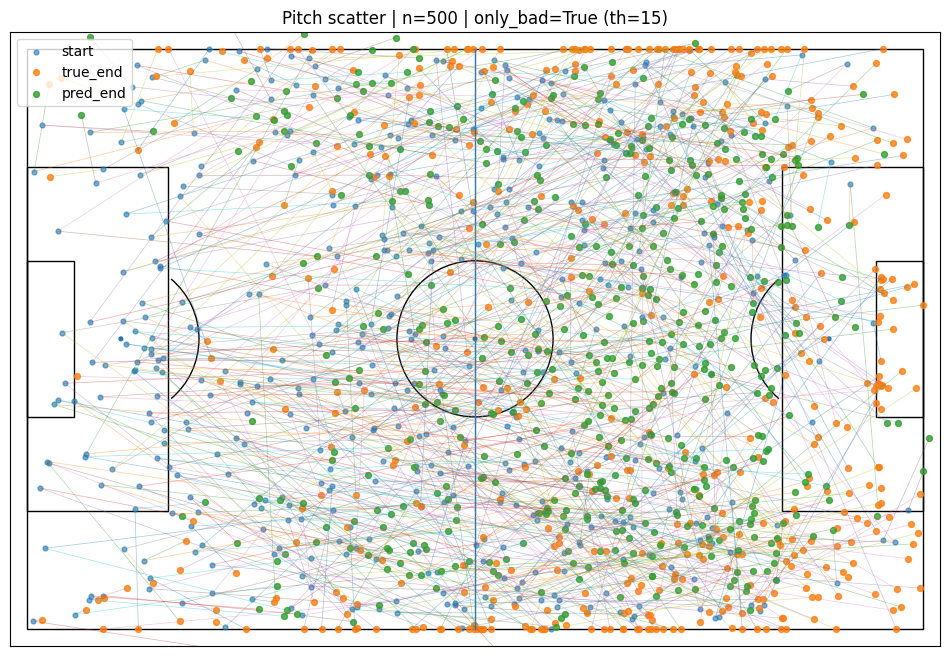

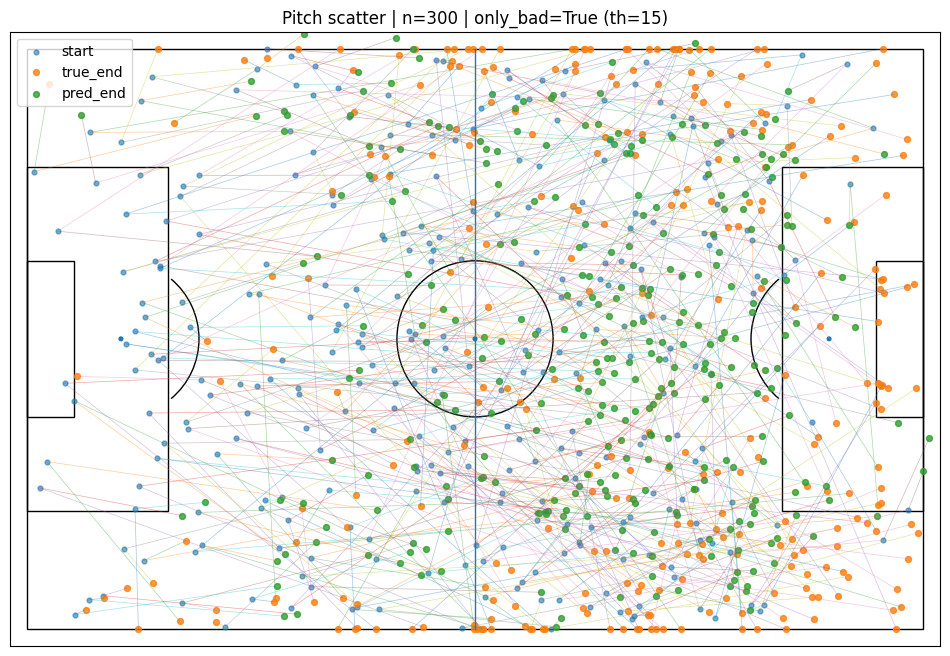

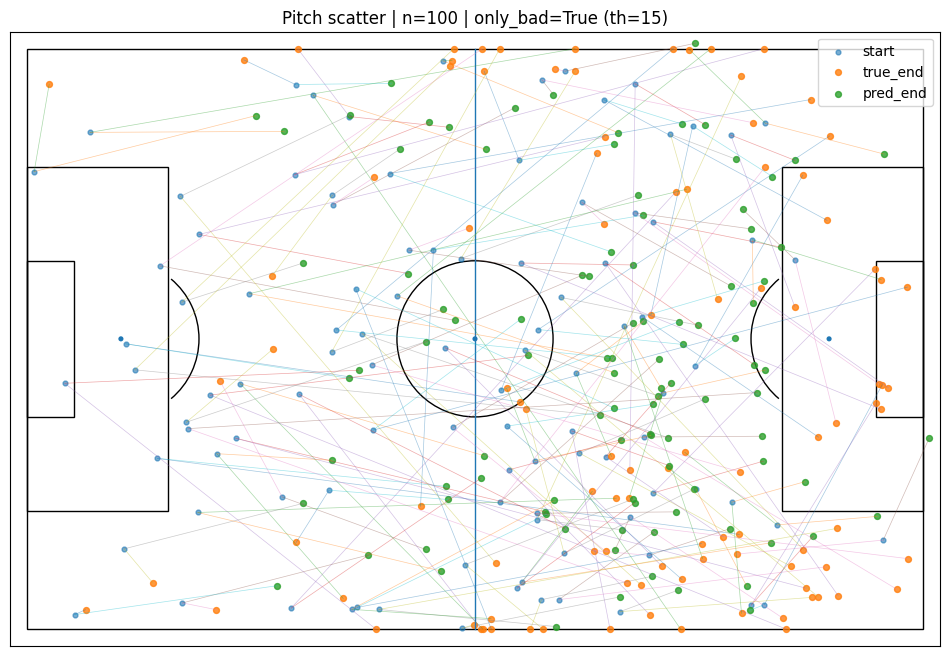

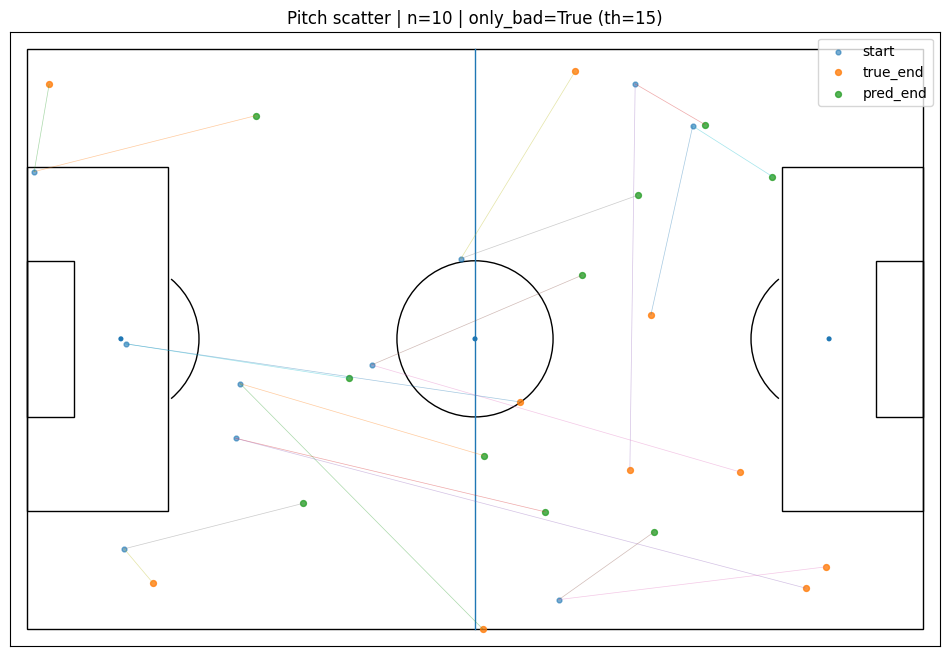

In [189]:
plot_on_pitch(
    miss_predicted_gru.sample(500, random_state=42),
    true_cols=("end_x","end_y"),
    pred_cols=("pred_gru_x","pred_gru_y"),
    err_col="err_gru",
    only_bad=True,
    bad_th=15,
    with_lines=True,
    max_points=1500
)
plot_on_pitch(
    miss_predicted_gru.sample(300, random_state=42),
    true_cols=("end_x","end_y"),
    pred_cols=("pred_gru_x","pred_gru_y"),
    err_col="err_gru",
    only_bad=True,
    bad_th=15,
    with_lines=True,
    max_points=1500
)
plot_on_pitch(
    miss_predicted_gru.sample(100, random_state=42),
    true_cols=("end_x","end_y"),
    pred_cols=("pred_gru_x","pred_gru_y"),
    err_col="err_gru",
    only_bad=True,
    bad_th=15,
    with_lines=True,
    max_points=1500
)
plot_on_pitch(
    miss_predicted_gru.sample(10, random_state=42),
    true_cols=("end_x","end_y"),
    pred_cols=("pred_gru_x","pred_gru_y"),
    err_col="err_gru",
    only_bad=True,
    bad_th=15,
    with_lines=True,
    max_points=1500
)

In [186]:
miss_predicted_gru[(miss_predicted_gru['end_y']<5) | (miss_predicted_gru['end_y']>63)]

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
177      126283          1          13       997.233     4639     142258   
249      126283          1          17      1228.500     4639     491802   
312      126283          1          21      1382.989     4639      77845   
321      126283          1          22      1430.853     4639     412018   
610      126283          1          31      2253.023     4639     491810   
...         ...        ...         ...           ...      ...        ...   
355847   126480          2          48       623.267     4639     407605   
356051   126480          2          56      1008.467     4220     500534   
356104   126480          2          58      1197.167     4220     500530   
356325   126480          2          68      1819.167     4639     491802   
356428   126480          2          72      2073.800     4220     354812   

        action_id type_name   result_name    start_x    start_y      end_x  \
177           629      Pass  Unsuccessful  14.527695  21.594692  71.613255   
249           751      Pass    Successful  19.583550  64.167561  15.825915   
312           850      Pass    Successful   2.190247  60.122540   5.775987   
321           867      Pass  Unsuccessful  57.254925  41.138640  58.112985   
610          1310      Pass  Unsuccessful  20.417250   3.185460  22.869105   
...           ...       ...           ...        ...        ...        ...   
355847       1923      Pass  Unsuccessful  45.009510   7.316392  59.064600   
356051       2065      Pass    Successful  80.168760   1.905292  95.906160   
356104       2152      Pass  Unsuccessful  68.758935  20.599648  89.950875   
356325       2431      Pass    Successful  37.467780  31.961768  47.535075   
356428       2588      Pass    Successful  50.364090  29.935300  88.281270   

            end_y  is_home game_episode  start_zone  result_name_bin  \
177      0.000000    False    126283_13          25                0   
249     67.121460    False    126283_17          86                1   
312     68.000000    False    126283_21          84                1   
321     68.000000    False    126283_22          54                0   
610      3.518184    False    126283_31           2                0   
...           ...      ...          ...         ...              ...   
355847   0.000000     True    126480_48           5                0   
356051   3.552660    False    126480_56           9                1   
356104   0.000000    False    126480_58          31                0   
356325   4.492080     True    126480_68          40                1   
356428  63.291666    False    126480_72          41                1   

        pred_gru_x  pred_gru_y    err_gru  
177      68.812912   19.569126  19.768475  
249      30.464760   57.725868  17.394624  
312      22.286625   63.384628  17.143594  
321      68.549301   44.883453  25.363190  
610      39.128872    3.494241  16.259785  
...            ...         ...        ...  
355847   73.243553   15.997074  21.376368  
356051   77.171242    8.487705  19.373999  
356104   83.012680   15.677422  17.144098  
356325   54.518120   26.502514  23.091603  
356428   66.067680   44.180016  29.303562  

[2690 rows x 20 columns]

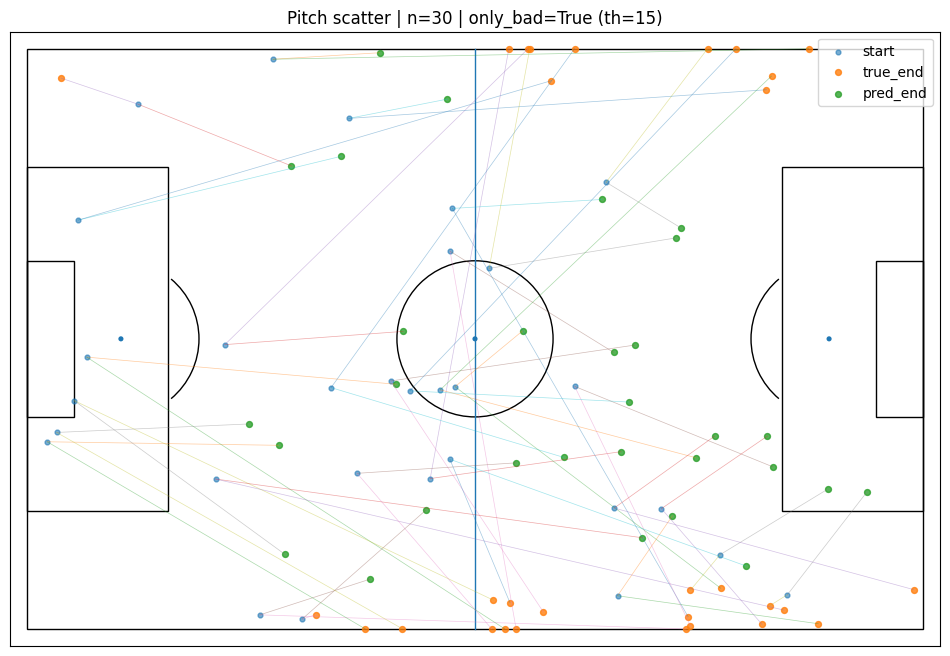

In [190]:
plot_on_pitch(
    miss_predicted_gru[(miss_predicted_gru['end_y']<5) | (miss_predicted_gru['end_y']>63)].sample(30, random_state=42),
    true_cols=("end_x","end_y"),
    pred_cols=("pred_gru_x","pred_gru_y"),
    err_col="err_gru",
    only_bad=True,
    bad_th=15,
    with_lines=True,
    max_points=1500
)

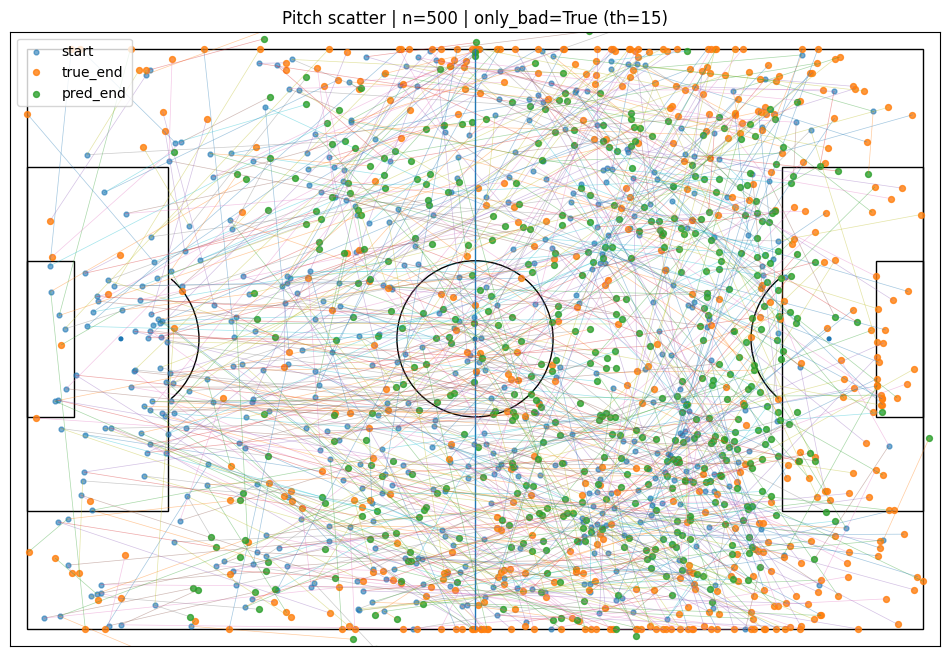

In [193]:
plot_on_pitch(
    miss_predicted_gru[miss_predicted_gru['period_id']==2].sample(500, random_state=42),
    true_cols=("end_x","end_y"),
    pred_cols=("pred_gru_x","pred_gru_y"),
    err_col="err_gru",
    only_bad=True,
    bad_th=15,
    with_lines=True,
    max_points=1500
)

In [194]:
miss_predicted_gru[miss_predicted_gru['result_name']=='Unsuccessful']

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
177      126283          1          13       997.233     4639     142258   
214      126283          1          14      1087.986     4639     188348   
321      126283          1          22      1430.853     4639     412018   
574      126283          1          29      2162.367     2354     344559   
597      126283          1          30      2212.033     2354     500145   
...         ...        ...         ...           ...      ...        ...   
356186   126480          1           6       564.367     4639     491802   
356423   126480          2          70      2037.400     4639     345445   
356438   126480          2          74      2150.533     4220     500530   
356625   126480          2          84      2847.767     4639     407605   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name    start_x    start_y       end_x  \
177           629      Pass  Unsuccessful  14.527695  21.594692   71.613255   
214           688      Pass  Unsuccessful  67.065180  53.216936  102.647076   
321           867      Pass  Unsuccessful  57.254925  41.138640   58.112985   
574          1260      Pass  Unsuccessful  97.926150  61.444310  101.494428   
597          1290      Pass  Unsuccessful  62.055315  14.816996   81.472335   
...           ...       ...           ...        ...        ...         ...   
356186        356      Pass  Unsuccessful  74.544225  43.501776   94.034745   
356423       2574      Pass  Unsuccessful  94.347435   1.769360  102.778095   
356438       2608      Pass  Unsuccessful  63.731640  50.077920   91.648830   
356625       2892      Pass  Unsuccessful  67.990440  14.316380   99.930117   
356720        508      Pass  Unsuccessful  29.311275  45.776920   83.430585   

            end_y  is_home game_episode  start_zone  result_name_bin  \
177      0.000000    False    126283_13          25                0   
214     31.934364    False    126283_14          79                0   
321     68.000000    False    126283_22          54                0   
574     40.285308     True    126283_29          95                0   
597      6.245868     True    126283_30          19                0   
...           ...      ...          ...         ...              ...   
356186  49.360656     True     126480_6          68                0   
356423  31.028468     True    126480_70          10                0   
356438  17.662048    False    126480_74          67                0   
356625  30.908516     True    126480_84          19                0   
356720  57.047240    False     126480_9          63                0   

        pred_gru_x  pred_gru_y    err_gru  
177      68.812912   19.569126  19.768475  
214      73.329010   40.836391  30.639763  
321      68.549301   44.883453  25.363190  
574      99.011810   63.673073  23.519161  
597      78.225235   23.495861  17.552946  
...            ...         ...        ...  
356186   81.205193   37.693336  17.341389  
356423   91.367287   11.281008  22.807208  
356438   75.804024   48.115768  34.329098  
356625   80.018333   14.622526  25.723775  
356720   57.556900   56.358131  25.882860  

[3554 rows x 20 columns]

In [196]:
train_df[train_raw['result_name']=='Unsuccessful']

/var/folders/68/7kt0lcf96vs3n4j0n3c75t600000gn/T/ipykernel_53419/720990809.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[train_raw['result_name']=='Unsuccessful']


game_episode  time_seconds    start_x    start_y  is_home  \
15       126283_25      1850.367  93.907170  37.503836        1   
34       126283_43       207.133  81.645900  64.645669        1   
43       126283_51      1017.646  73.033590  56.044852        0   
67       126283_76      2715.800  87.532095  11.378712        1   
75       126284_10       611.200  86.928975  47.324940        0   
...            ...           ...        ...        ...      ...   
15383    126480_32      2445.967  23.733465   0.941460        1   
15388    126480_39      2790.700  50.000160  47.371384        0   
15401    126480_51       717.400  40.491885   7.025828        1   
15408     126480_6       564.367  74.544225  43.501776        1   
15426    126480_79      2498.300   3.460160  21.290120        1   

       result_name_bin  start_zone player_id team_id type_name  ...   embT_30  \
15                   1          58    250036    2354      Pass  ...  0.210297   
34                   0          93     61979    2354      Pass  ...  0.210297   
43                   0          80    345446    4639      Pass  ...  0.057001   
67                   0          22    250037    2354      Pass  ...  0.210297   
75                   1          69    500480    4657      Pass  ... -0.241063   
...                ...         ...       ...     ...       ...  ...       ...   
15383                0           2    187316    4639      Pass  ...  0.057001   
15388                1          65    500533    4220      Pass  ... -0.130550   
15401                1           4    528953    4639      Pass  ...  0.057001   
15408                0          68    491802    4639      Pass  ...  0.057001   
15426                1          24    187316    4639      Pass  ...  0.057001   

        embZ_30   embA_30   embP_31   embT_31   embZ_31   embA_31  \
15    -0.019515 -0.078913  0.000819  0.199959  0.278289  0.208498   
34     0.100865 -0.078913  0.077044  0.199959  0.454891  0.208498   
43     0.082229 -0.078913  0.295105  0.503162  0.257944  0.208498   
67    -0.080768 -0.078913  0.236253  0.199959  0.345649  0.208498   
75    -0.080513 -0.078913 -0.070793  0.032651  0.341338  0.208498   
...         ...       ...       ...       ...       ...       ...   
15383 -0.254422 -0.078913  0.041379  0.503162  0.193403  0.208498   
15388  0.053404 -0.078913  0.034258 -0.111916  0.309838  0.208498   
15401 -0.169386 -0.078913  0.222707  0.503162  0.217278  0.208498   
15408  0.024800 -0.078913  0.166801  0.503162  0.335010  0.208498   
15426 -0.512075 -0.078913  0.041379  0.503162 -0.139987  0.208498   

       target_end_x_m  target_end_y_m  game_id  
15          94.921785       14.487264   126283  
34          97.919115       65.085513   126283  
43          83.786220       61.705009   126283  
67         100.030245       11.355524   126283  
75          92.234310       36.114120   126284  
...               ...             ...      ...  
15383       24.474555        1.045160   126480  
15388       50.373540       56.245180   126480  
15401       38.343165       15.139928   126480  
15408       94.034745       49.360656   126480  
15426       17.218425        5.559748   126480  

[1719 rows x 143 columns]

In [198]:
df[df['result_name']=='Unsuccessful']

game_id  period_id  episode_id  time_seconds  team_id  player_id  \
149      126283          1          12       940.933     2354      61979   
177      126283          1          13       997.233     4639     142258   
214      126283          1          14      1087.986     4639     188348   
244      126283          1          15      1169.467     2354     250037   
253      126283          1          18      1250.814     4639     412018   
...         ...        ...         ...           ...      ...        ...   
356423   126480          2          70      2037.400     4639     345445   
356438   126480          2          74      2150.533     4220     500530   
356625   126480          2          84      2847.767     4639     407605   
356639   126480          2          87      3020.800     4639     250902   
356720   126480          1           9       833.700     4220     354820   

        action_id type_name   result_name    start_x  ...  pred_lgb_x  \
149           588      Pass  Unsuccessful  80.991120  ...   86.719582   
177           629      Pass  Unsuccessful  14.527695  ...   79.807785   
214           688      Pass  Unsuccessful  67.065180  ...   87.104355   
244           737      Pass  Unsuccessful  82.461225  ...   91.079475   
253           761      Pass  Unsuccessful  36.823500  ...   43.824287   
...           ...       ...           ...        ...  ...         ...   
356423       2574      Pass  Unsuccessful  94.347435  ...   95.392014   
356438       2608      Pass  Unsuccessful  63.731640  ...   74.839378   
356625       2892      Pass  Unsuccessful  67.990440  ...   88.349289   
356639       2915      Pass  Unsuccessful  63.547890  ...   90.137451   
356720        508      Pass  Unsuccessful  29.311275  ...   54.872120   

        pred_lgb_y  pred_xgb_x  pred_xgb_y pred_gru_x  pred_gru_y     err_cb  \
149      59.501629   91.197304   61.085045  79.571182   61.387169  10.340545   
177      31.482405   82.551399   29.045584  68.812912   19.569126  19.224874   
214      44.834324   85.349312   42.523140  73.329010   40.836391  27.091284   
244      18.587770   93.447998   16.916401  87.427917   26.135300   9.083516   
253      60.366428   44.749554   61.938381  50.202747   61.480415   3.542110   
...            ...         ...         ...        ...         ...        ...   
356423    6.968207   96.636444    5.780243  91.367287   11.281008  26.500152   
356438   46.721031   73.241730   47.933464  75.804024   48.115768  29.838981   
356625   24.191864   88.623711   23.640528  80.018333   14.622526  21.494716   
356639   15.193080   90.938866   16.966484  77.706749    6.598537   3.446285   
356720   44.481331   60.508347   50.711754  57.556900   56.358131  26.315868   

          err_lgb    err_xgb    err_gru  
149      7.952195  10.668715   4.514363  
177     32.531402  31.036896  19.768475  
214     20.198642  20.281391  30.639763  
244     11.637483  10.502050  14.442326  
253      3.146149   2.885478   8.283581  
...           ...        ...        ...  
356423  25.168440  25.984471  22.807208  
356438  33.570555  35.428519  34.329098  
356625  13.387643  13.440926  25.723775  
356639  18.805984  20.251305   5.304326  
356720  31.200769  23.781661  25.882860  

[6801 rows x 29 columns]

In [206]:
df['target_end_x_m']

KeyError: 'target_end_x_m'

[ALL] rows=15435  mean_err=16.582
[BAD>= 15.0] rows=7120  mean_err=25.506


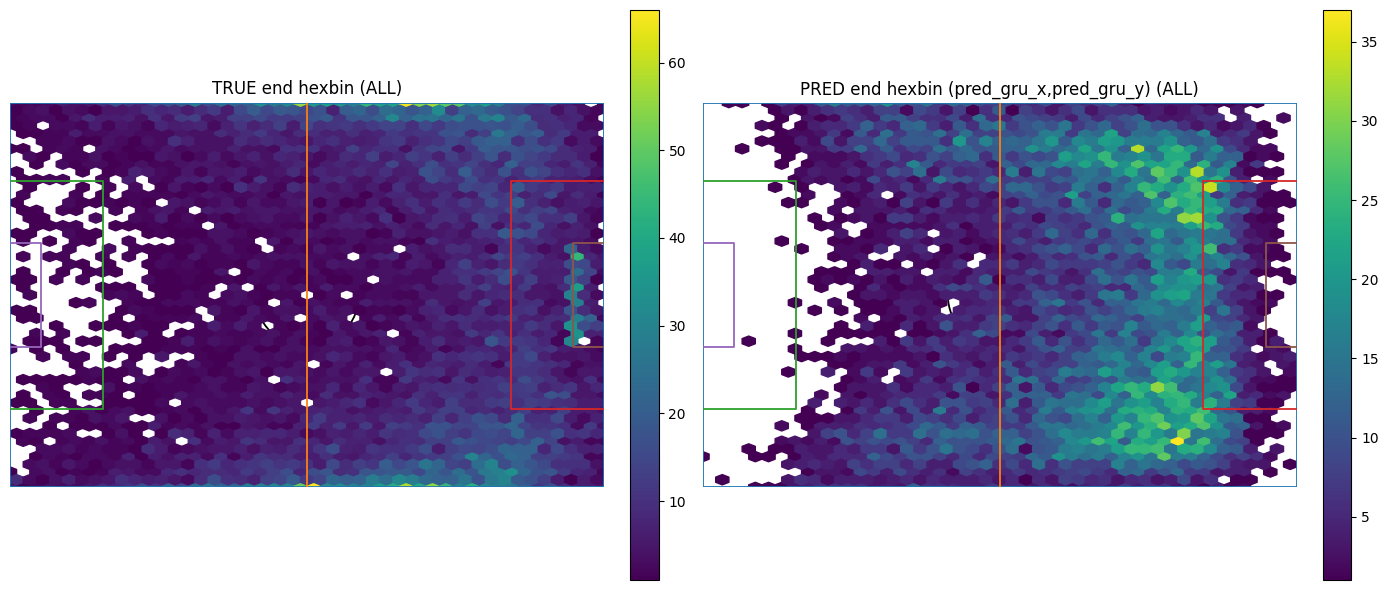

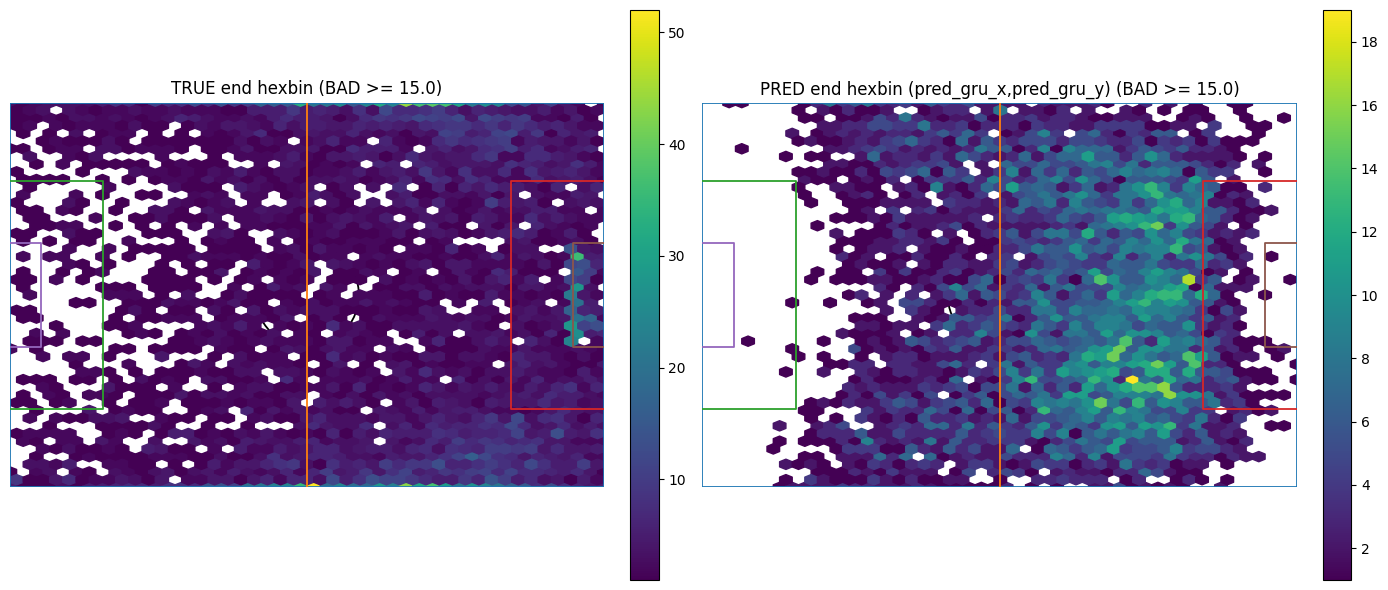

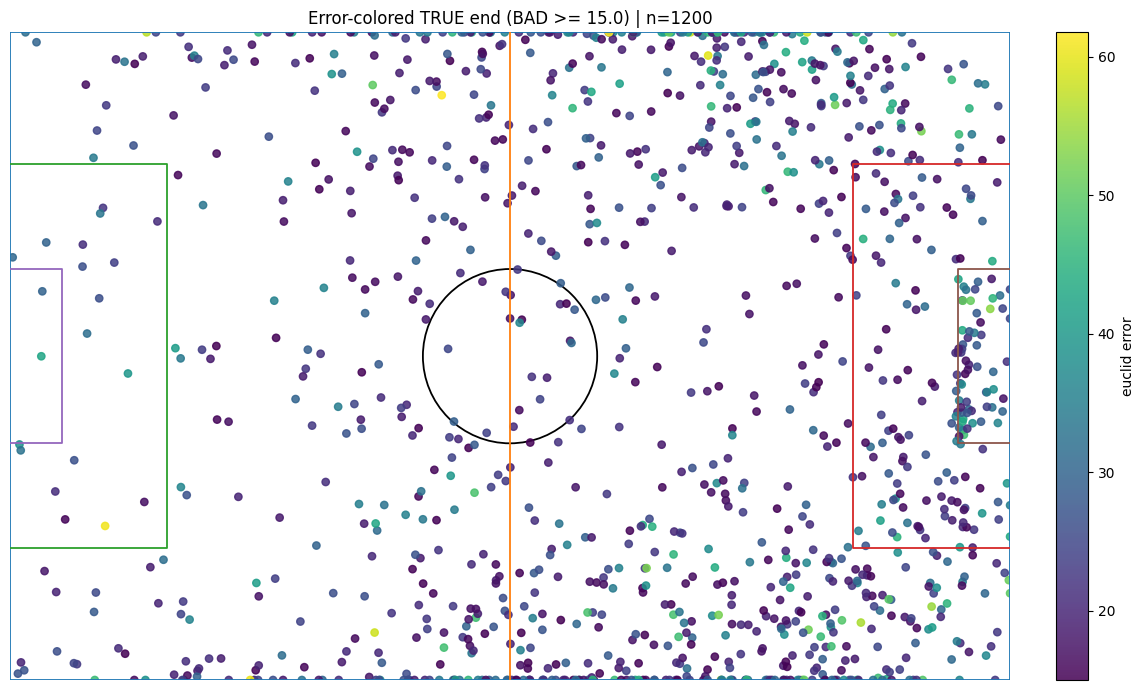

[BAD & near sideline] rows=2105  mean_err=27.567


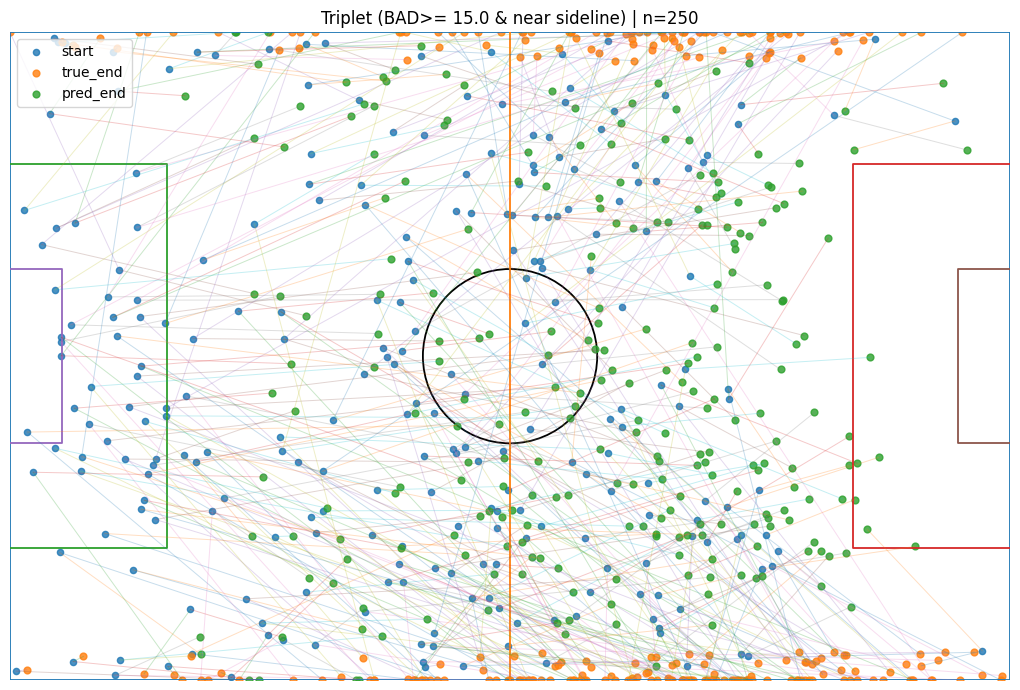

[BAD & near right box] rows=914  mean_err=25.414


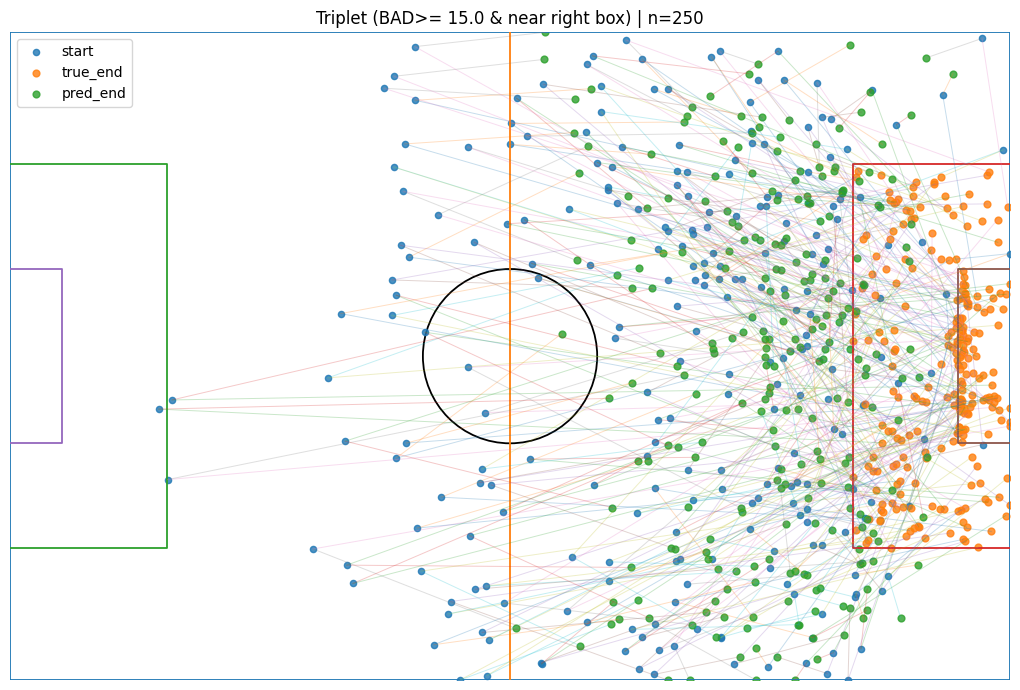

game_episode  game_id  period_id  episode_id type_name   result_name  \
294568     126444_7   126444          1           7      Pass  Unsuccessful   
241706    126414_41   126414          2          41      Pass  Unsuccessful   
317250    126458_28   126458          1          28      Pass  Unsuccessful   
101773    126338_22   126338          1          22      Pass  Unsuccessful   
230510    126408_46   126408          2          46      Pass  Unsuccessful   
284414    126438_62   126438          2          62      Pass    Successful   
273559    126432_48   126432          2          48      Pass  Unsuccessful   
43764     126306_61   126306          2          61      Pass  Unsuccessful   
219875    126402_67   126402          2          67      Pass  Unsuccessful   
59378     126315_16   126315          1          16      Pass    Successful   
348305    126476_29   126476          1          29      Pass    Successful   
24036     126295_75   126295          2          75      Pass  Unsuccessful   
87386     126330_47   126330          1          47      Pass  Unsuccessful   
340878    126472_16   126472          1          16      Pass  Unsuccessful   
164445    126372_20   126372          1          20      Pass  Unsuccessful   
334470    126468_22   126468          1          22      Pass  Unsuccessful   
138830     126358_6   126358          1           6      Pass  Unsuccessful   
132034   126355_107   126355          2         107      Pass  Unsuccessful   
112080    126343_66   126343          2          66      Pass    Successful   
102735    126338_48   126338          2          48      Pass  Unsuccessful   
346031    126475_13   126475          1          13      Pass  Unsuccessful   
354090     126479_5   126479          1           5      Pass  Unsuccessful   
249311    126418_51   126418          2          51      Pass    Successful   
136727    126357_65   126357          2          65      Pass    Successful   
295773    126445_38   126445          1          38      Pass  Unsuccessful   
107571    126341_32   126341          1          32      Pass  Unsuccessful   
135440     126356_8   126356          1           8      Pass  Unsuccessful   
144247    126361_38   126361          2          38      Pass    Successful   
241740    126414_43   126414          2          43      Pass    Successful   
111890    126343_57   126343          2          57      Pass    Successful   

        is_home    start_x    start_y  target_end_x_m  target_end_y_m  \
294568    False  42.208635  40.207856        0.641445        0.508001   
241706     True  43.728510   9.114516       87.210690       68.000000   
317250    False  16.854810   4.780944       11.890620       68.000000   
101773     True   7.943869  26.812808       96.370050       58.401800   
230510     True  17.500140   8.396028       76.228845       59.707808   
284414     True  62.181840   7.242272      101.481555       65.593514   
273559    False  33.779445  57.965852       84.878850        1.928956   
43764     False  41.625990   4.976172      103.988010       56.986108   
219875     True  44.010645  52.381148      103.905060        4.702132   
59378      True  50.159445  21.295084       85.174845       62.573607   
348305    False  50.708175  42.891544       95.918970        1.119620   
24036     False  66.466995   8.880596       80.643885       68.000000   
87386      True  18.789120  25.175028       18.664800       67.909764   
340878     True  22.330245  30.622440      104.550879       18.581612   
164445     True   5.964231  31.712548       78.652560       68.000000   
334470    False  34.283445  65.665472       80.212335        0.000000   
138830     True  58.974300  22.898728      104.005335        0.000000   
132034     True  29.307285   4.588028       62.893320       68.000000   
112080     True  27.730605  14.106328       45.329550       61.400124   
102735     True  60.827655  52.749368       90.680730        0.357862   
346031     True  33.4219

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) 설정: 사용할 예측 컬럼 선택
# =========================
PRED_X_COL = "pred_gru_x"
PRED_Y_COL = "pred_gru_y"

df['target_end_x_m'] = df['end_x']
df['target_end_y_m'] = df['end_y']

# df 컬럼 체크(없으면 여기서 바로 에러로 잡힘)
need_cols = ["start_x","start_y","target_end_x_m","target_end_y_m",PRED_X_COL,PRED_Y_COL]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"df에 필요한 컬럼이 없음: {missing}\n"
                     f"예측 컬럼(PRED_X_COL/PRED_Y_COL) 이름을 현재 df에 맞게 바꿔줘.")

# =========================
# 1) 유틸: pitch 그리기(간단 버전)
# =========================
def draw_pitch(ax, xlim=(0,105), ylim=(0,68), lw=1.3):
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    # Outer lines
    ax.plot([0,105,105,0,0],[0,0,68,68,0], lw=lw)
    # Halfway line
    ax.plot([52.5,52.5],[0,68], lw=lw)
    # Center circle
    circ = plt.Circle((52.5,34), 9.15, fill=False, lw=lw)
    ax.add_patch(circ)
    # Penalty areas (approx)
    # Left
    ax.plot([0,16.5,16.5,0],[13.84,13.84,54.16,54.16], lw=lw)
    # Right
    ax.plot([105,88.5,88.5,105],[13.84,13.84,54.16,54.16], lw=lw)
    # 6-yard boxes (approx)
    ax.plot([0,5.5,5.5,0],[24.84,24.84,43.16,43.16], lw=lw)
    ax.plot([105,99.5,99.5,105],[24.84,24.84,43.16,43.16], lw=lw)

# =========================
# 2) 에러 계산 + 기본 클립(옵션)
# =========================
work = df.copy()

# 혹시 예측이 범위 밖이면(모델에 따라) 일단 pitch 범위로 클립해서 "시각화용"으로만 보정
work[PRED_X_COL] = work[PRED_X_COL].clip(0, 105)
work[PRED_Y_COL] = work[PRED_Y_COL].clip(0, 68)

work["err"] = np.sqrt(
    (work[PRED_X_COL] - work["target_end_x_m"])**2 +
    (work[PRED_Y_COL] - work["target_end_y_m"])**2
)

# =========================
# 3) 필터: only_bad / 라인근처 / 박스근처
# =========================
def filter_bad(df_in, th=15.0):
    return df_in[df_in["err"] >= th].copy()

def filter_near_sideline(df_in, margin=3.0):
    # y가 0 또는 68 근처
    y = df_in["target_end_y_m"]
    return df_in[(y <= margin) | (y >= 68-margin)].copy()

def filter_near_right_box(df_in, x_min=88.5, y_min=13.84, y_max=54.16):
    x = df_in["target_end_x_m"]; y = df_in["target_end_y_m"]
    return df_in[(x >= x_min) & (y >= y_min) & (y <= y_max)].copy()

# =========================
# 4) 샘플링: df.sample
# =========================
def sample_rows(df_in, n=500, seed=42):
    n = min(n, len(df_in))
    return df_in.sample(n=n, random_state=seed)

# =========================
# 5) 플롯 A: True vs Pred 히트맵(2개)
# =========================
def plot_hexbin_true_pred(df_in, gridsize=45, title_suffix=""):
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    ax1, ax2 = axes

    # TRUE
    draw_pitch(ax1)
    hb1 = ax1.hexbin(df_in["target_end_x_m"], df_in["target_end_y_m"],
                     gridsize=gridsize, mincnt=1)
    ax1.set_title(f"TRUE end hexbin {title_suffix}")
    fig.colorbar(hb1, ax=ax1, fraction=0.046, pad=0.04)

    # PRED
    draw_pitch(ax2)
    hb2 = ax2.hexbin(df_in[PRED_X_COL], df_in[PRED_Y_COL],
                     gridsize=gridsize, mincnt=1)
    ax2.set_title(f"PRED end hexbin ({PRED_X_COL},{PRED_Y_COL}) {title_suffix}")
    fig.colorbar(hb2, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# =========================
# 6) 플롯 B: error 컬러 scatter (true_end만)
# =========================
def plot_error_scatter(df_in, n=800, seed=42, title="Error-colored TRUE end scatter"):
    samp = sample_rows(df_in, n=n, seed=seed)
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    draw_pitch(ax)
    sc = ax.scatter(
        samp["target_end_x_m"], samp["target_end_y_m"],
        c=samp["err"], s=28, alpha=0.85
    )
    ax.set_title(f"{title} | n={len(samp)}")
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="euclid error")
    plt.tight_layout()
    plt.show()

# =========================
# 7) 플롯 C: start / true_end / pred_end + 연결선 (샘플)
# =========================
def plot_triplet_scatter(df_in, n=250, seed=42, title="Triplet scatter"):
    samp = sample_rows(df_in, n=n, seed=seed).copy()

    fig, ax = plt.subplots(1,1, figsize=(12,7))
    draw_pitch(ax)

    ax.scatter(samp["start_x"], samp["start_y"], s=20, alpha=0.8, label="start")
    ax.scatter(samp["target_end_x_m"], samp["target_end_y_m"], s=24, alpha=0.8, label="true_end")
    ax.scatter(samp[PRED_X_COL], samp[PRED_Y_COL], s=24, alpha=0.8, label="pred_end")

    # 연결선 (start->true, start->pred)
    for _, r in samp.iterrows():
        ax.plot([r["start_x"], r["target_end_x_m"]], [r["start_y"], r["target_end_y_m"]], lw=0.7, alpha=0.25)
        ax.plot([r["start_x"], r[PRED_X_COL]], [r["start_y"], r[PRED_Y_COL]], lw=0.7, alpha=0.25)

    ax.legend(loc="upper left")
    ax.set_title(f"{title} | n={len(samp)}")
    plt.tight_layout()
    plt.show()

# =========================
# 8) 실행 예시: (a) 전체 / (b) only_bad / (c) 라인근처 bad / (d) 오른쪽 박스 bad
# =========================
TH = 15.0
only_bad = filter_bad(work, th=TH)

print(f"[ALL] rows={len(work)}  mean_err={work['err'].mean():.3f}")
print(f"[BAD>= {TH}] rows={len(only_bad)}  mean_err={only_bad['err'].mean():.3f}")

# 히트맵: 전체 vs bad
plot_hexbin_true_pred(work, title_suffix="(ALL)")
plot_hexbin_true_pred(only_bad, title_suffix=f"(BAD >= {TH})")

# 에러컬러 scatter: bad에서만(너무 많으면 샘플링)
plot_error_scatter(only_bad, n=1200, seed=42, title=f"Error-colored TRUE end (BAD >= {TH})")

# 트리플 산점도: bad에서 샘플
plot_triplet_scatter(only_bad, n=300, seed=42, title=f"Triplet scatter (BAD >= {TH})")

# 라인 근처 bad
bad_line = filter_near_sideline(only_bad, margin=3.0)
print(f"[BAD & near sideline] rows={len(bad_line)}  mean_err={bad_line['err'].mean():.3f}")
plot_triplet_scatter(bad_line, n=250, seed=42, title=f"Triplet (BAD>= {TH} & near sideline)")

# 오른쪽 박스 근처 bad
bad_rbox = filter_near_right_box(only_bad)
print(f"[BAD & near right box] rows={len(bad_rbox)}  mean_err={bad_rbox['err'].mean():.3f}")
plot_triplet_scatter(bad_rbox, n=250, seed=42, title=f"Triplet (BAD>= {TH} & near right box)")

# top-k worst 테이블(눈으로 feature 같이 보기 좋게)
show_cols = [c for c in ["game_episode","game_id","period_id","episode_id","type_name","result_name","is_home",
                         "start_x","start_y","target_end_x_m","target_end_y_m",PRED_X_COL,PRED_Y_COL,"err"] if c in work.columns]
topk = only_bad.sort_values("err", ascending=False).head(30)[show_cols]
display(topk)